In [1]:
import json
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
from per_size_model import PerSizeModel

In [2]:
model_sizes = ["0.6B", "1.7B", "4B", "8B", "14B", "32B"]
alphas = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
drafts = [1, 2, 3, 4, 5, 6, 8, 10]
parameters = {0:0.76, 1:2, 2:4.4, 3:8, 4:14, 5:32}
h = {0:1024, 1:2048, 2:2560, 3:4096, 4:5120, 5:5120}
nlayers = {0:28, 1:28, 2:36, 3:36, 4:40, 5:64}
DATA_DIR = "."

In [3]:
def model_size_from_filename(filename):
    return int(filename.split('B')[0].split('-')[-1])

def alpha_from_filename(filename):
    return float(filename.split('alpha-')[-1].split('_')[0])

def draft_from_filename(filename):
    return int(filename.split('draft-')[-1].split('_')[0])

def prompt_length_from_filename(filename):
    return int(filename.split('prompt-')[-1].split('_')[0])

def output_length_from_filename(filename):
    return int(filename.split('output-')[-1].split('_')[0])

In [4]:
def expected_acceptance_length(alpha, draft):
    if alpha == 1.0:
        return draft + 1
    else:
        return (1. - alpha ** (draft + 1)) / (1. - alpha)

In [5]:
def getTTFT(filename):
    with open(filename, 'r') as file:
        data = json.load(file)
    ttft=[]
    rps=[]
    for i in range(len(data)):
        ttft.append(data[i]['time_to_first_token_ms']['successful']['mean'])
        rps.append((data[i]['requests_per_second']['successful']['mean']))
    ttft, rps=np.array(ttft), np.array(rps)
    indx=np.argsort(rps)
    ttft = ttft[indx]
    rps = rps[indx]
    ttft = ttft[:-3]
    rps = rps[:-3]
    return rps, ttft

def getITL(filename):
    with open(filename, 'r') as file:
        data = json.load(file)
    itl=[]
    rps=[]
    for i in range(len(data)):
        itl.append(data[i]['inter_token_latency_ms']['successful']['mean'])
        rps.append((data[i]['requests_per_second']['successful']['mean']))
    indx=np.argsort(rps)
    itl = itl[indx]
    rps = rps[indx]
    itl = itl[:-3]
    rps = rps[:-3]

    return rps, itl

def getRequestLatency(filename):
    with open(filename, 'r') as file:
        data = json.load(file)
    lat=[]
    rps=[]

    for i in range(len(data)):
        lat.append(data[i]['request_latency']['successful']['mean'])
        rps.append((data[i]['requests_per_second']['successful']['mean']))
    lat, rps=np.array(lat), np.array(rps)
    indx=np.argsort(rps)
    lat = lat[indx]
    rps = rps[indx]
    lat = lat[:-3]
    rps = rps[:-3]
    return  rps, lat

def getTPOT(filename):
    with open(filename, 'r') as file:
        data = json.load(file)
    tpot=[]
    rps=[]
    for i in range(len(data)):
        tpot.append(data[i]['time_per_output_token_ms']['successful']['mean'])
        rps.append((data[i]['requests_per_second']['successful']['mean']))
    tpot, rps=np.array(tpot), np.array(rps)
    indx=np.argsort(rps)
    tpot = tpot[indx]
    rps = rps[indx]
    tpot = tpot[:-3]
    rps = rps[:-3]

    return  rps, tpot

  0%|          | 0/6 [00:00<?, ?it/s]

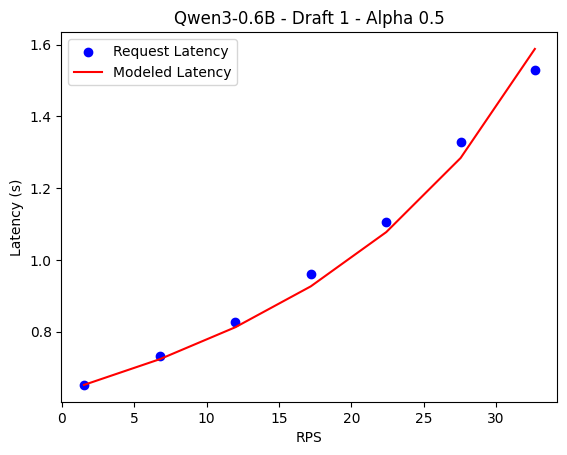

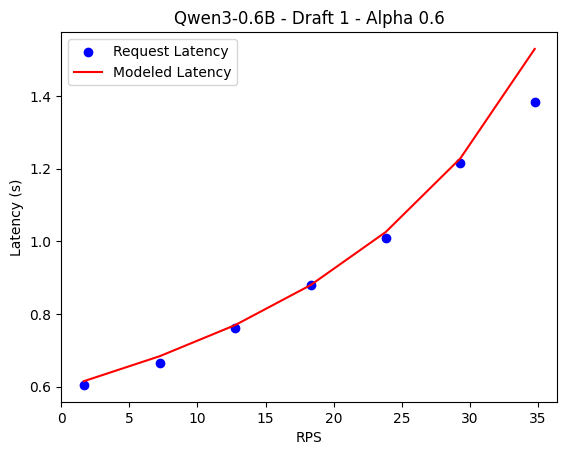

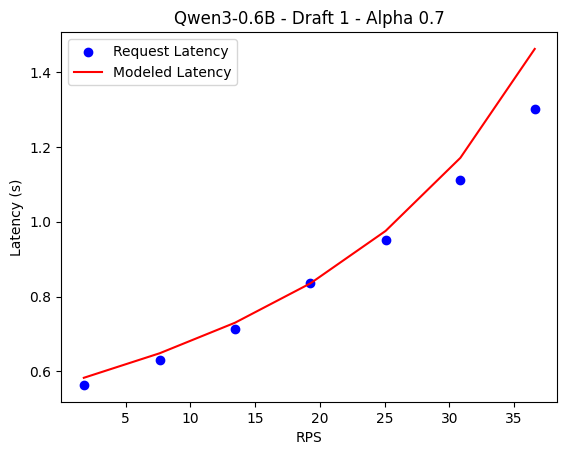

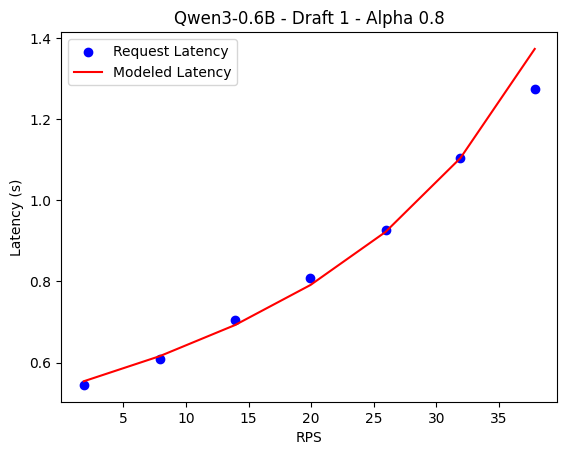

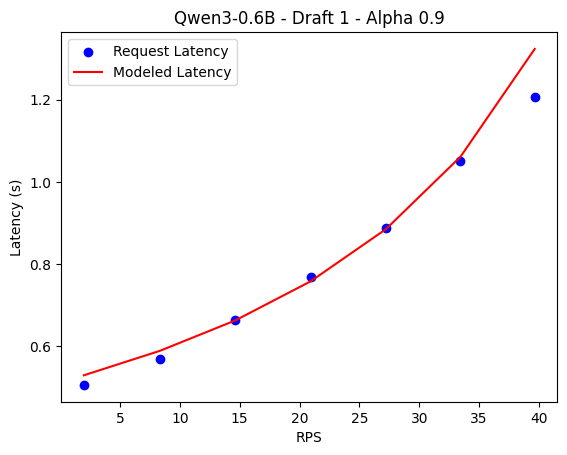

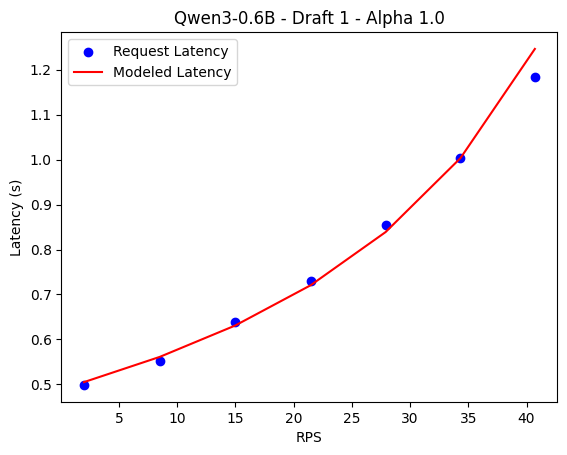

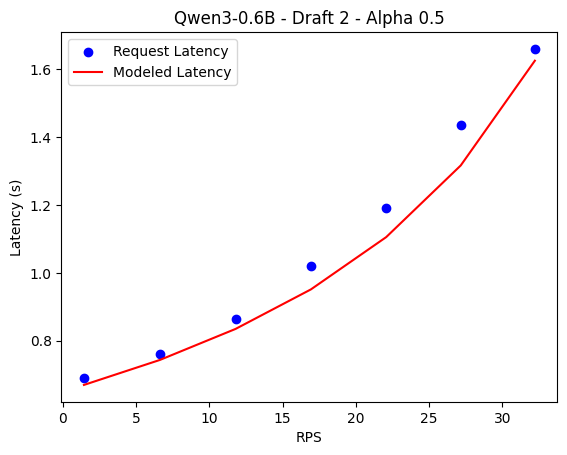

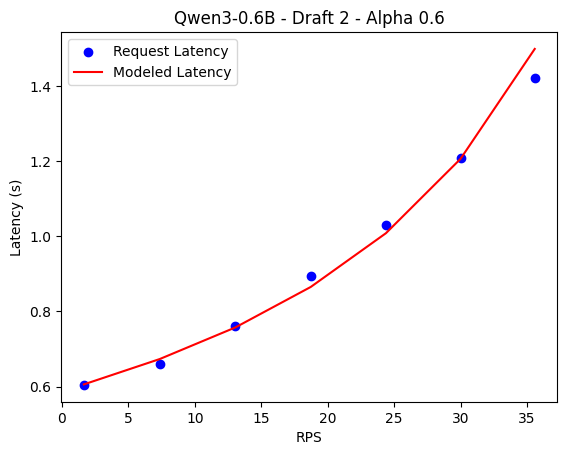

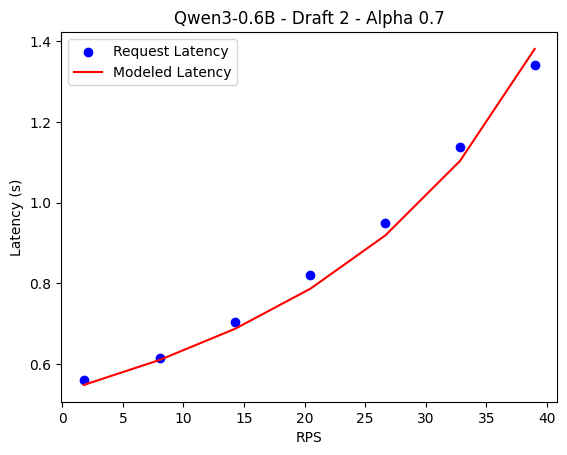

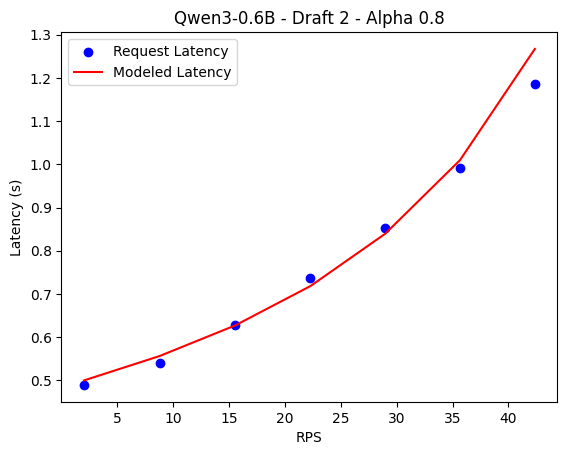

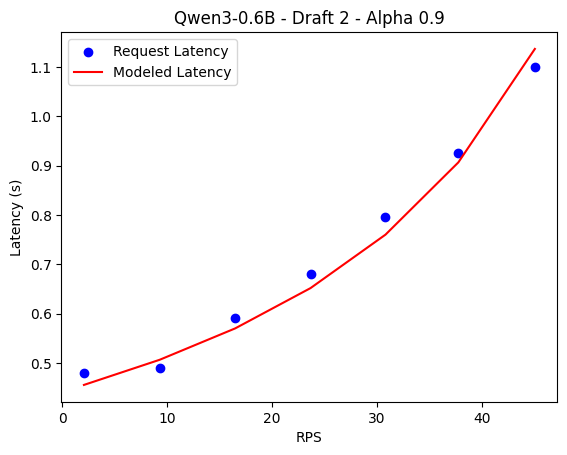

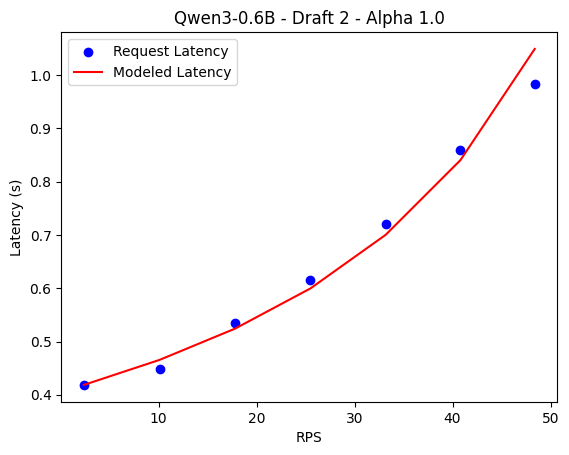

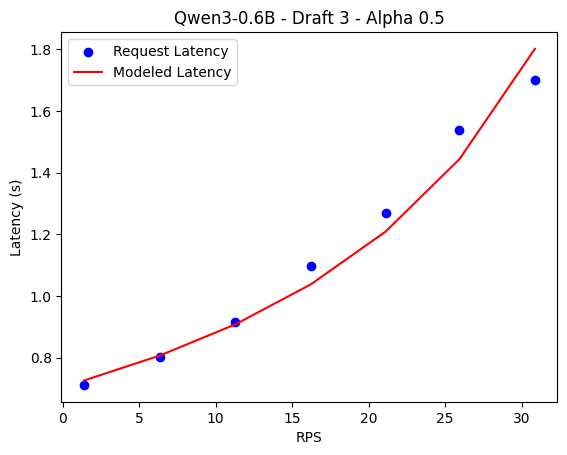

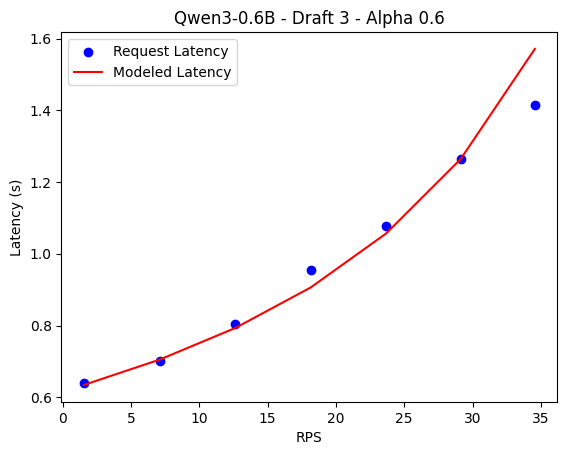

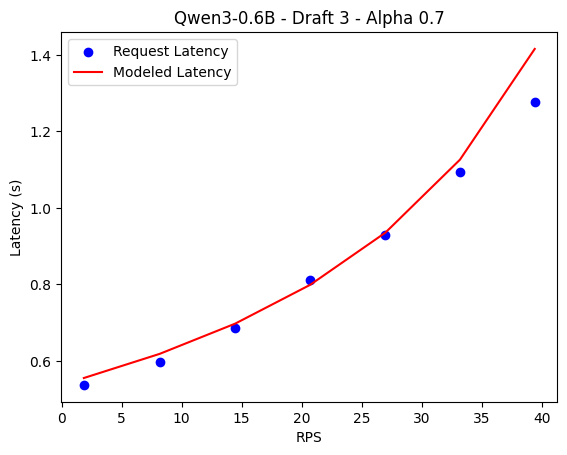

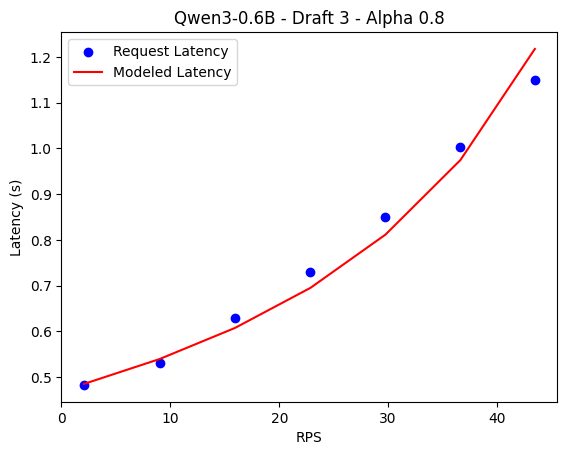

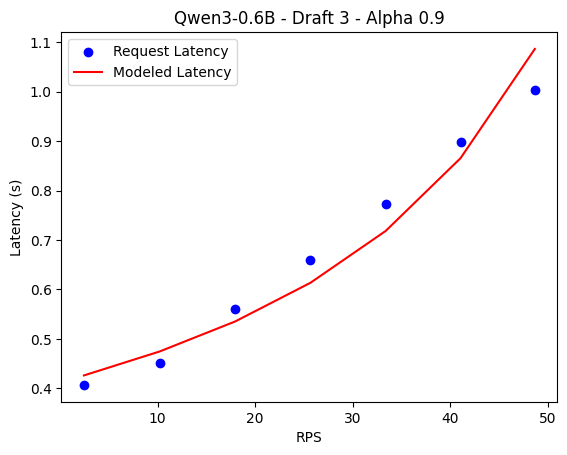

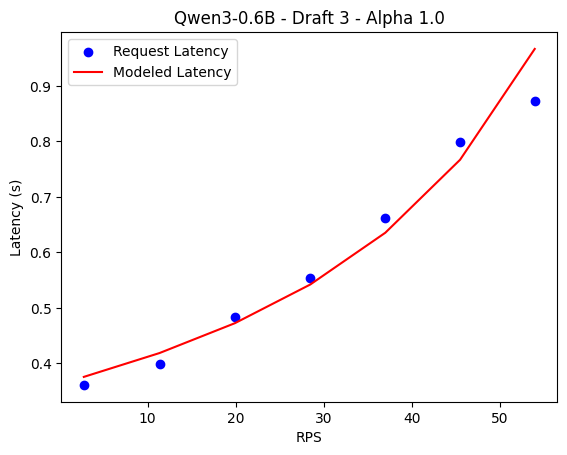

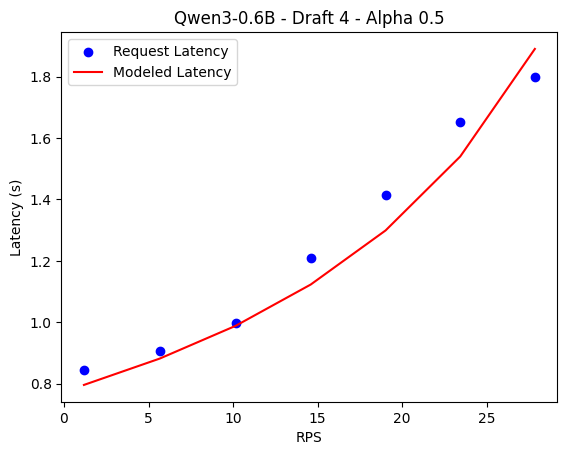

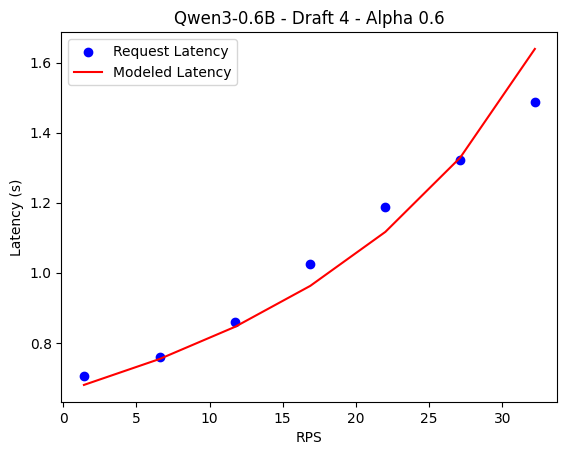

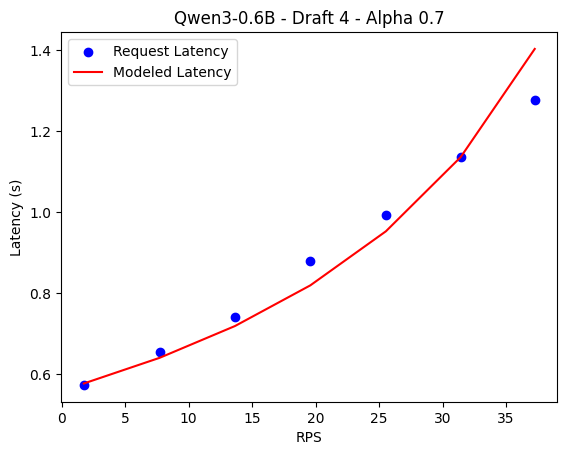

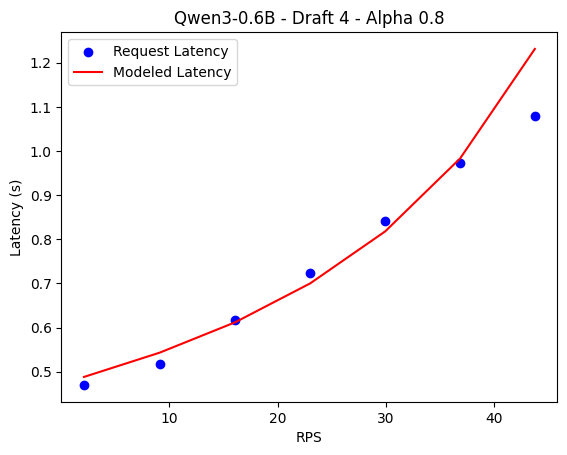

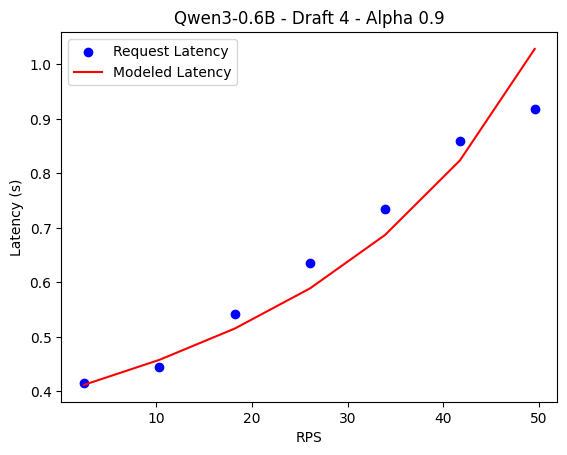

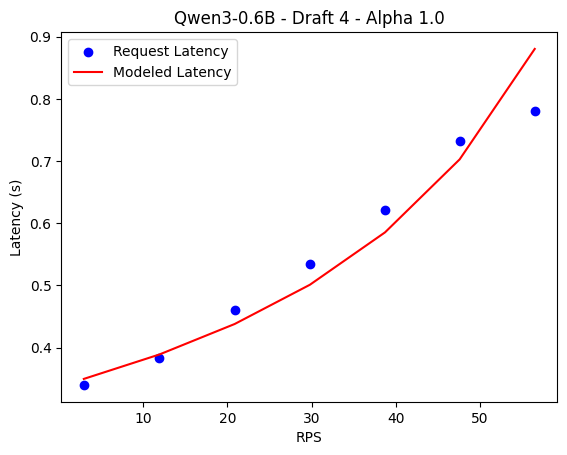

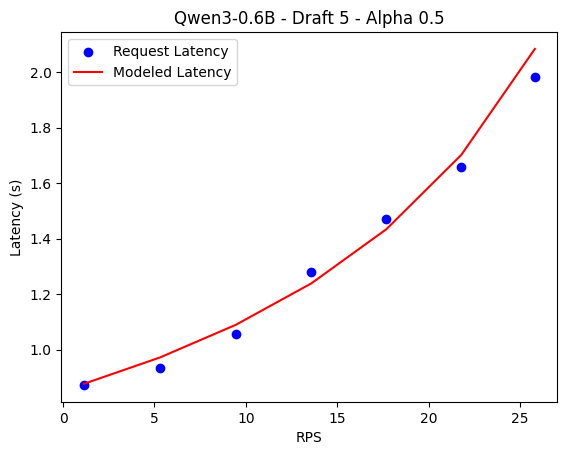

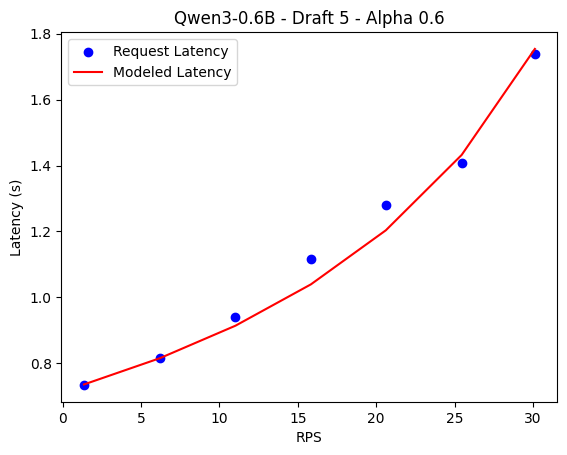

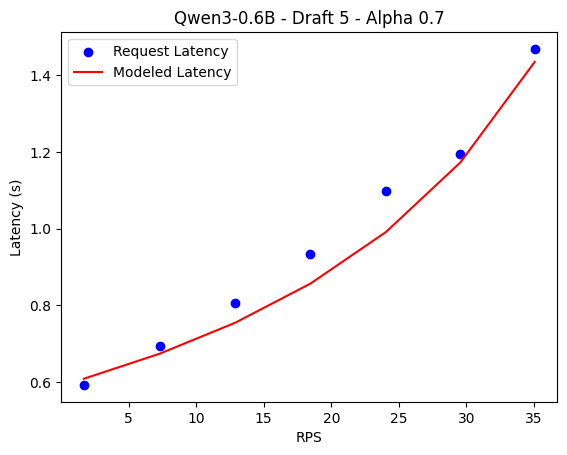

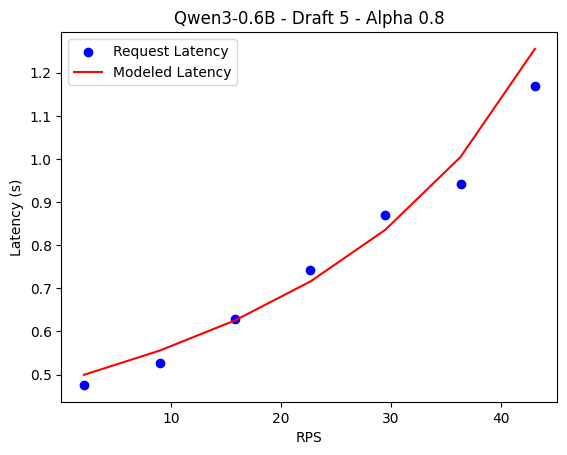

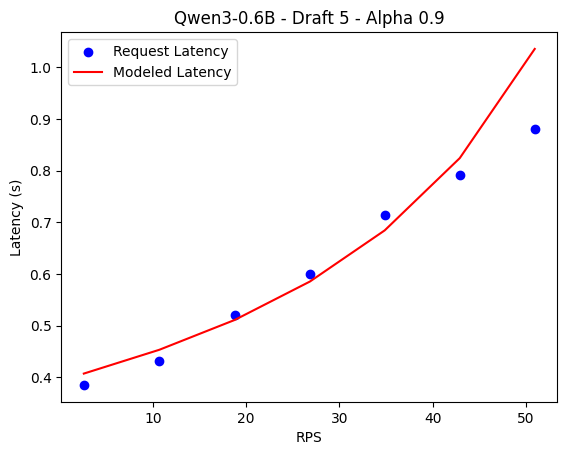

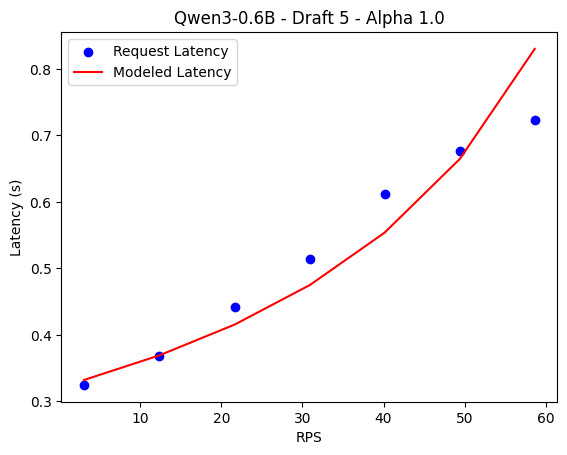

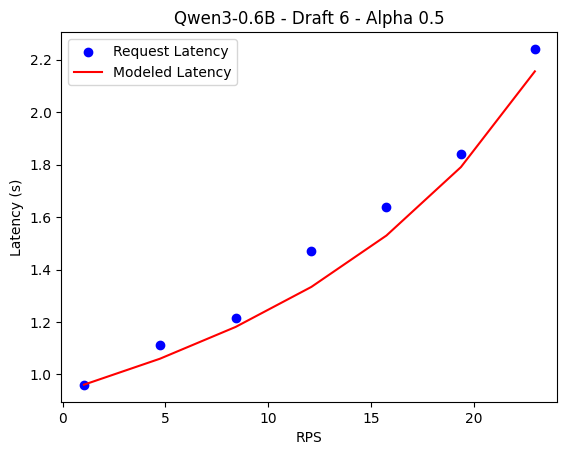

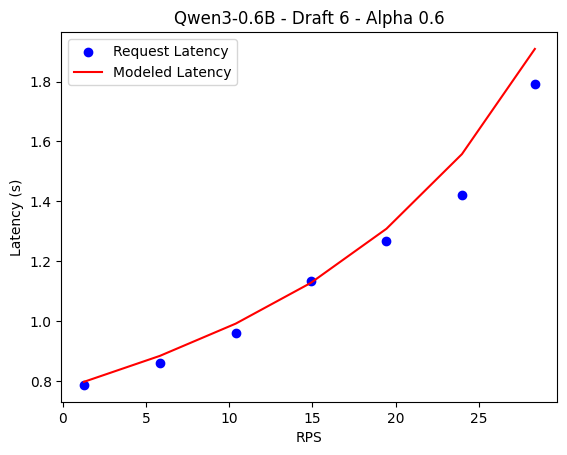

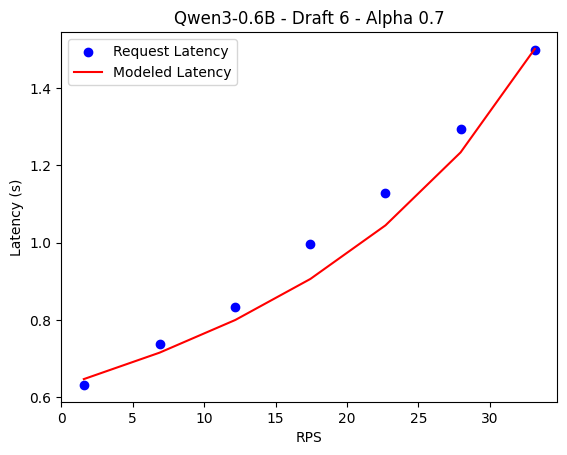

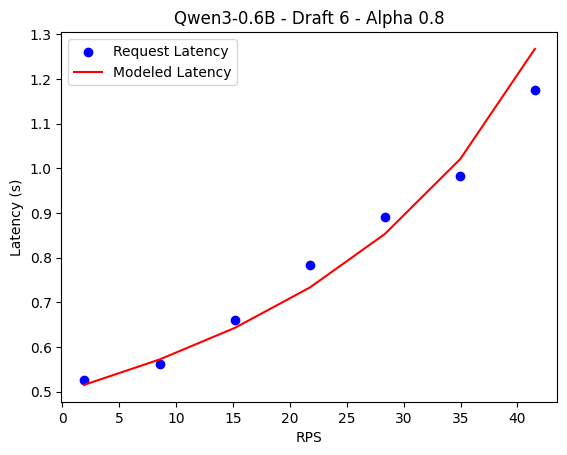

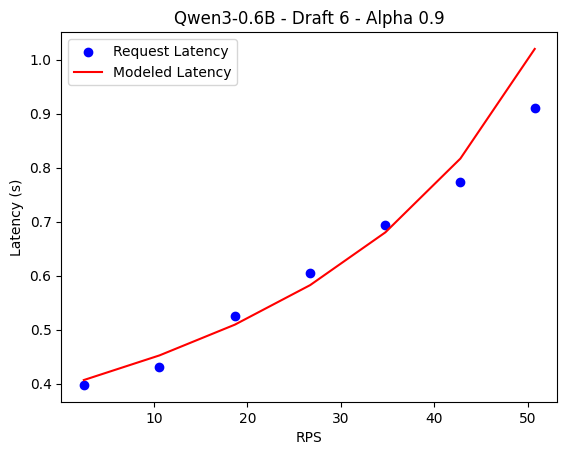

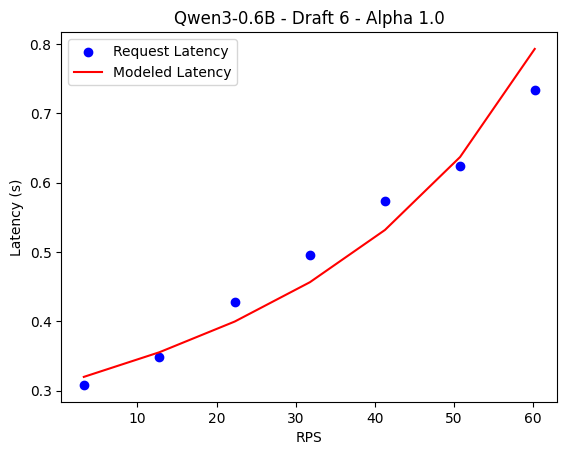

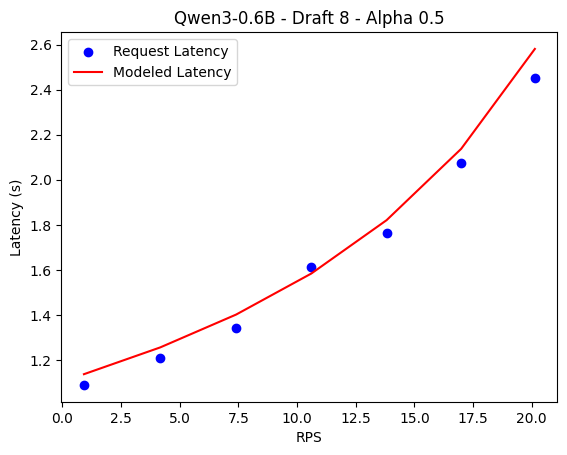

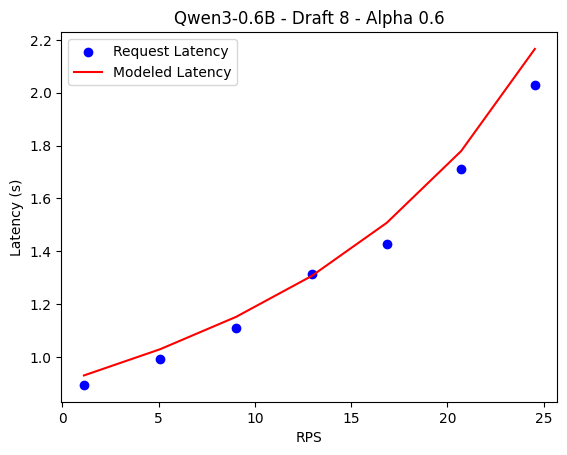

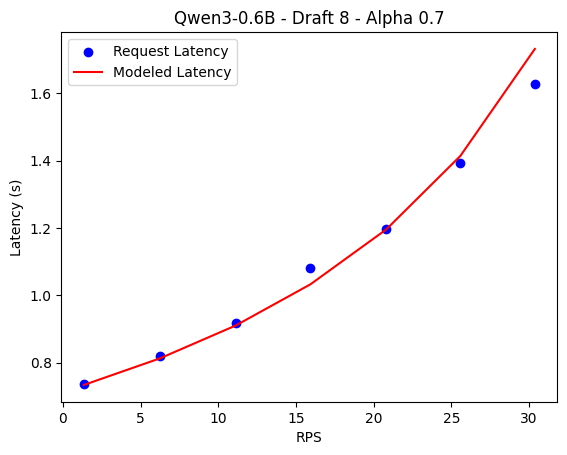

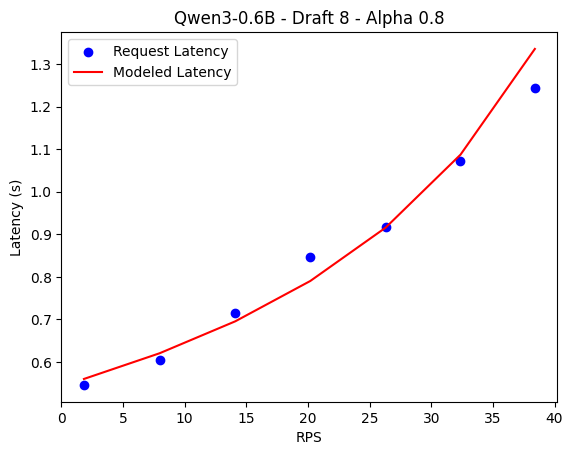

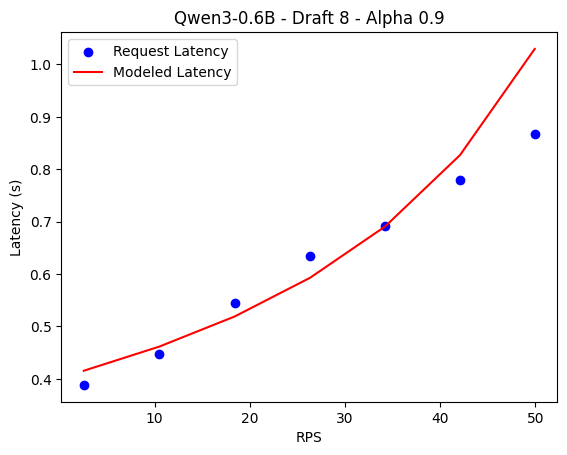

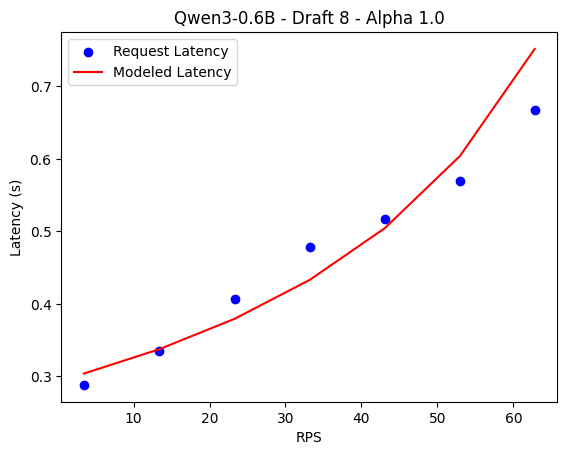

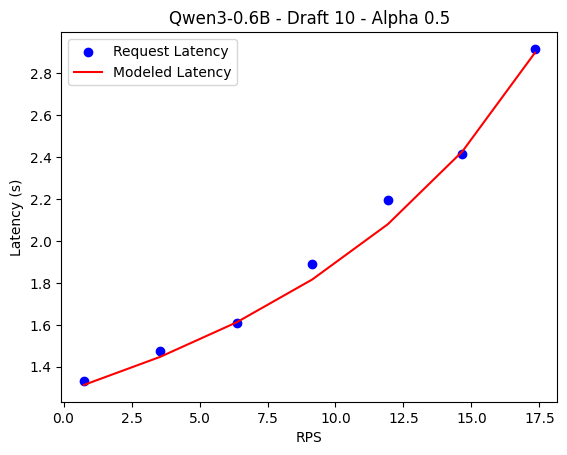

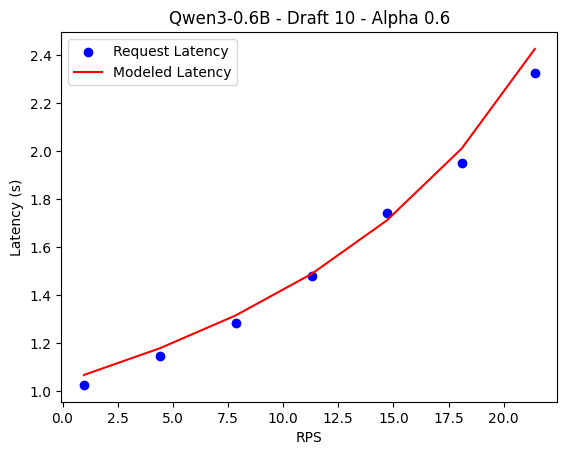

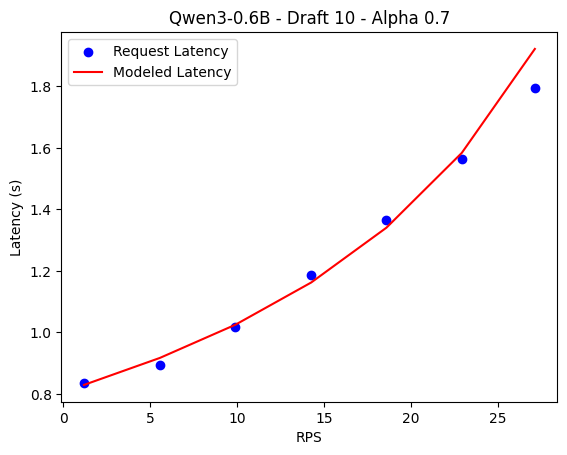

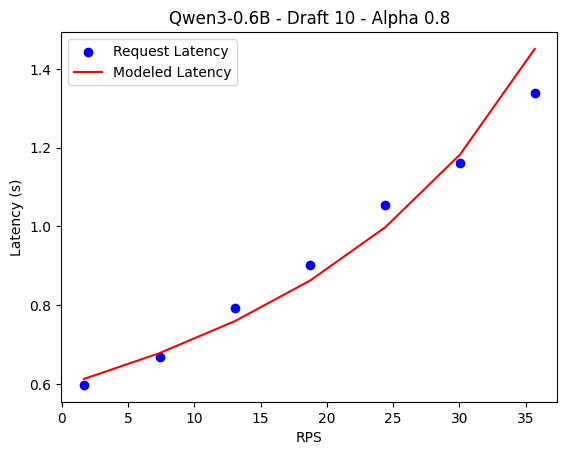

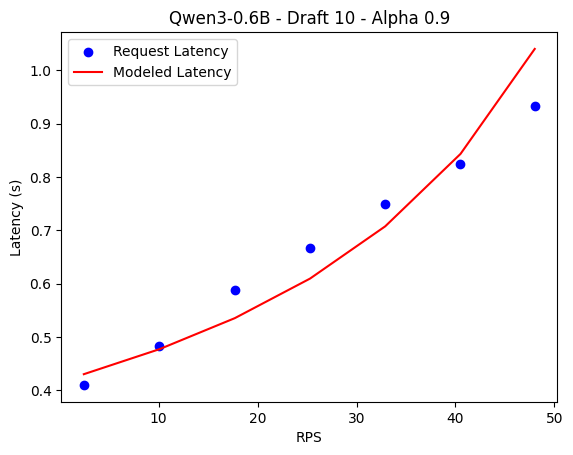

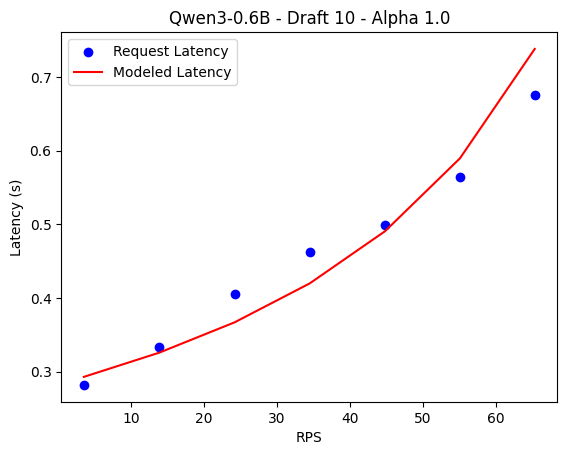

 17%|█▋        | 1/6 [00:02<00:11,  2.30s/it]

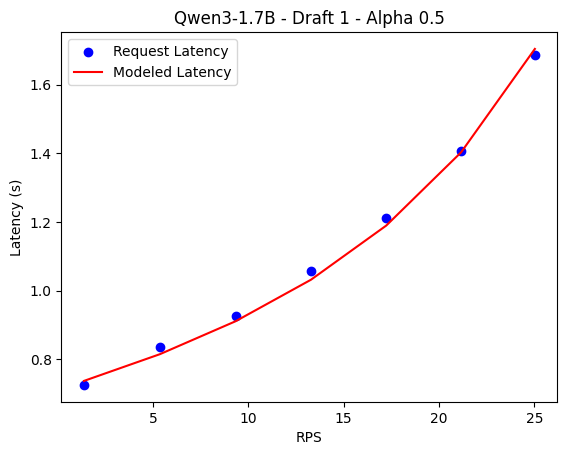

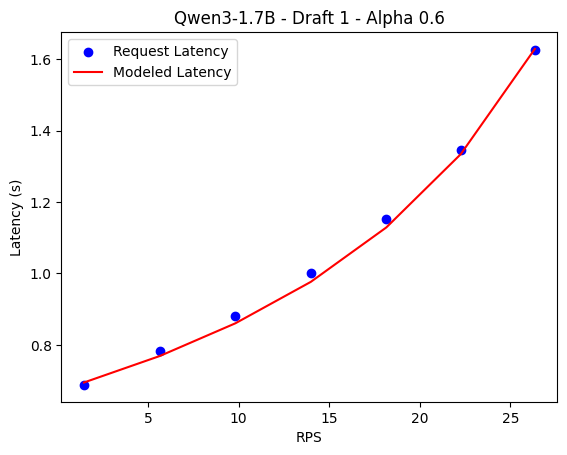

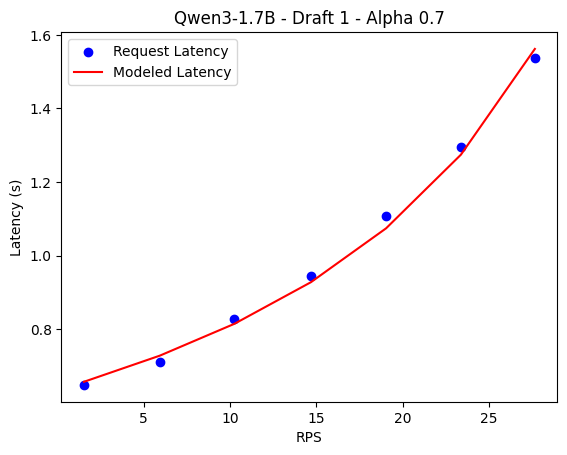

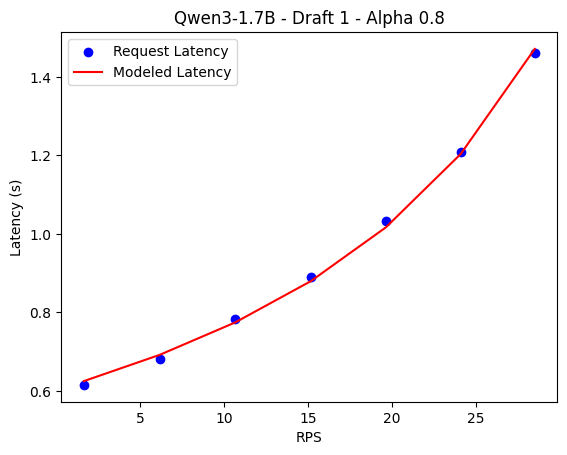

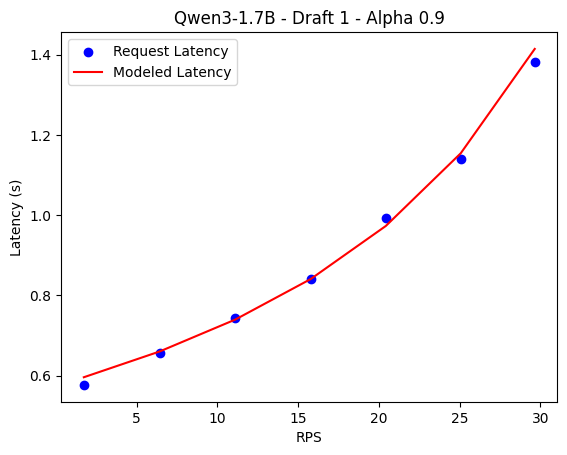

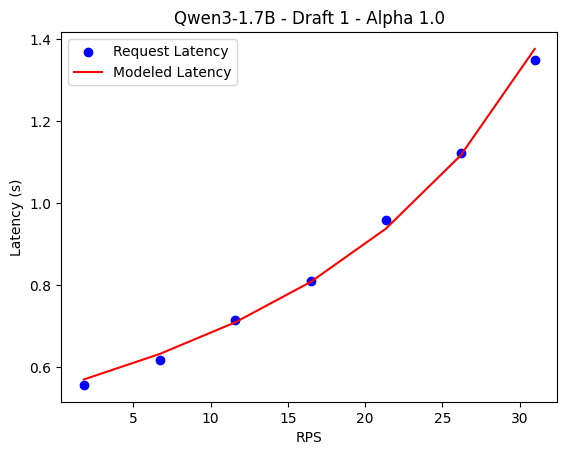

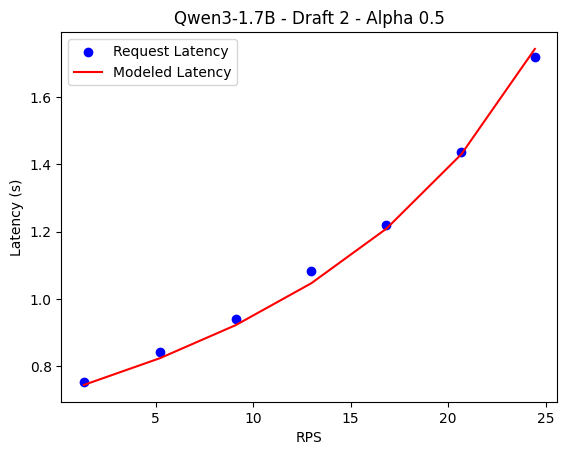

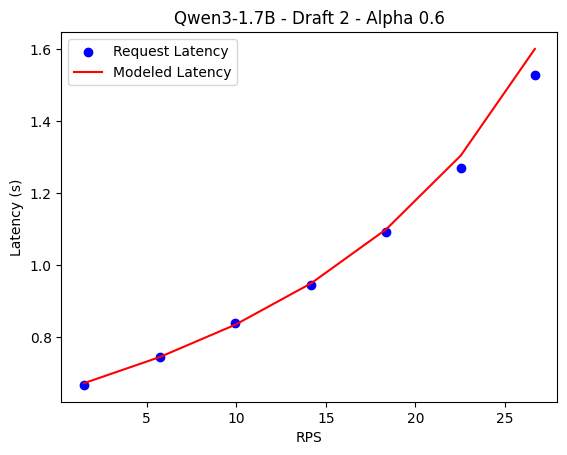

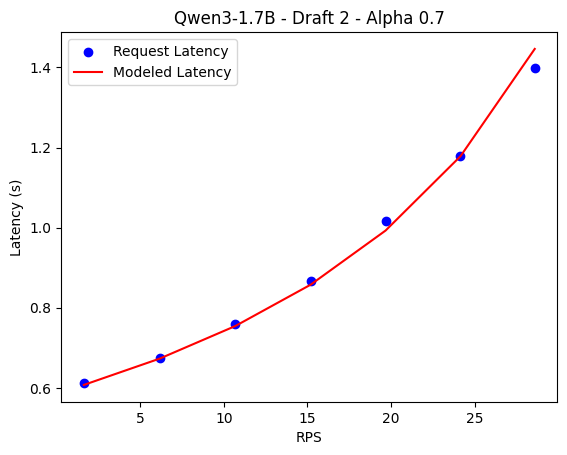

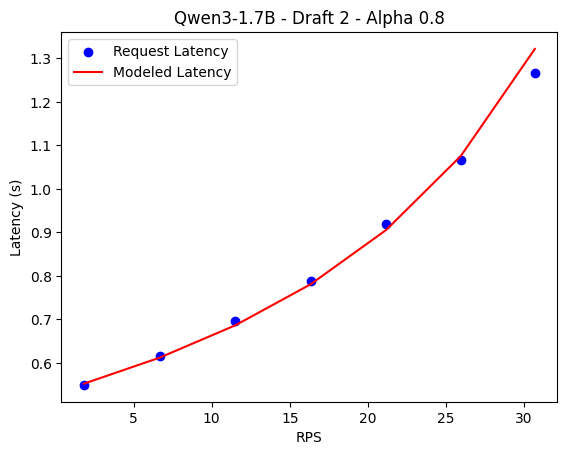

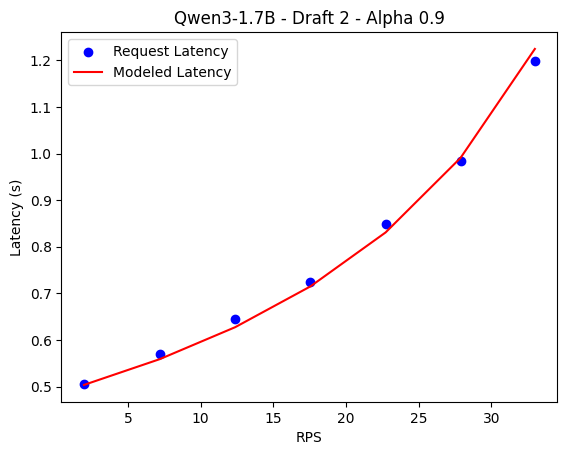

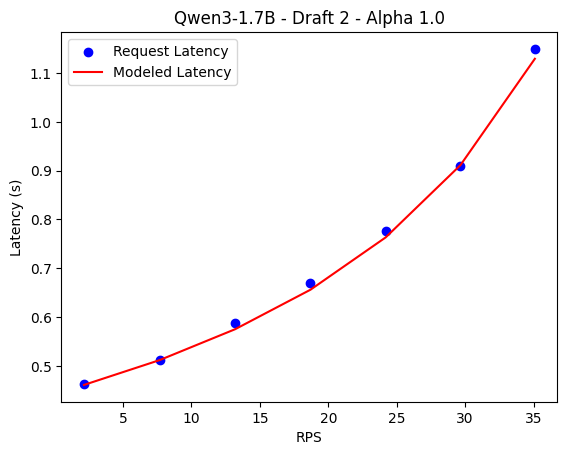

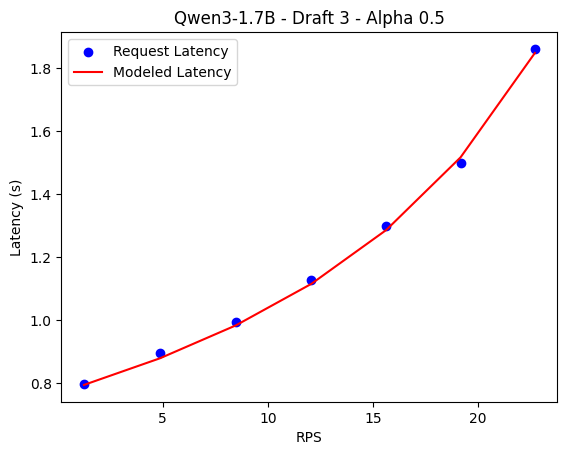

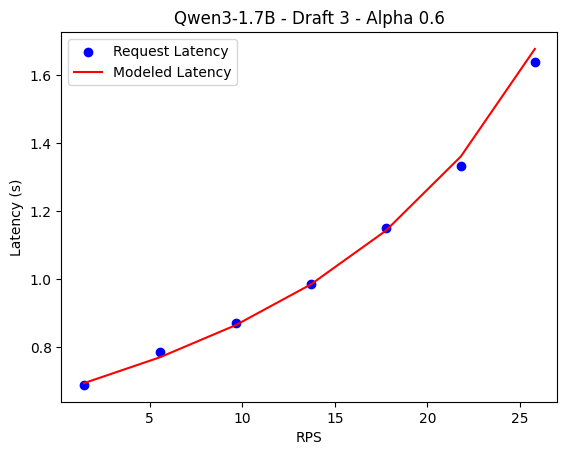

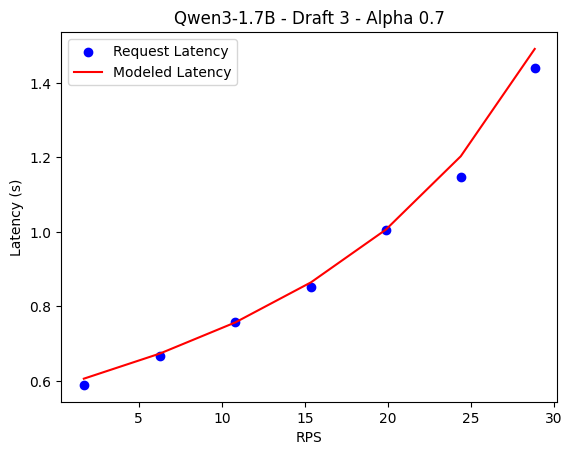

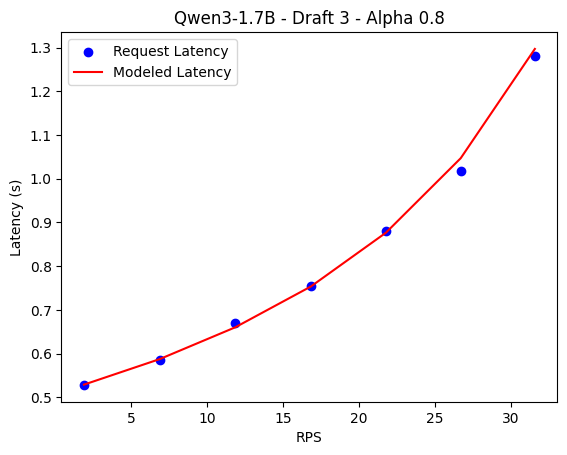

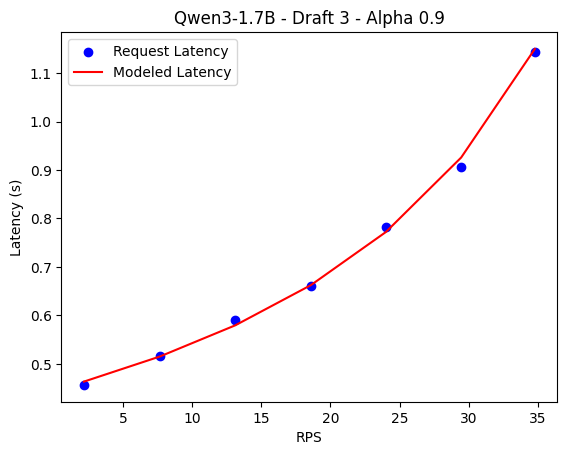

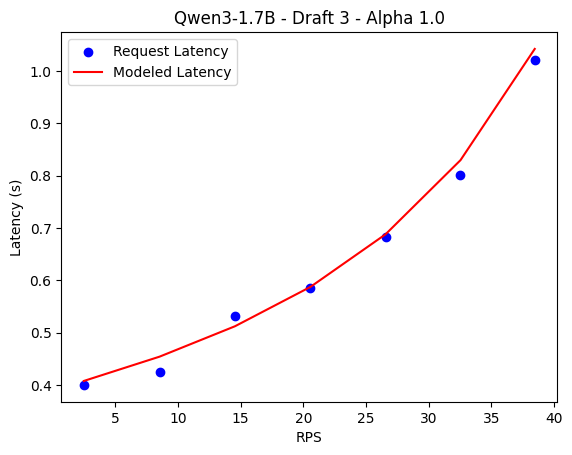

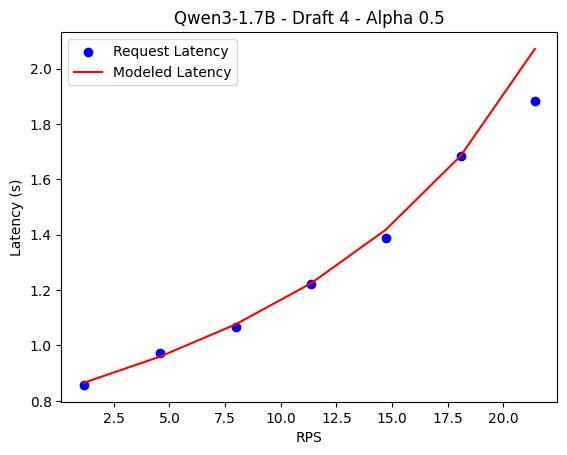

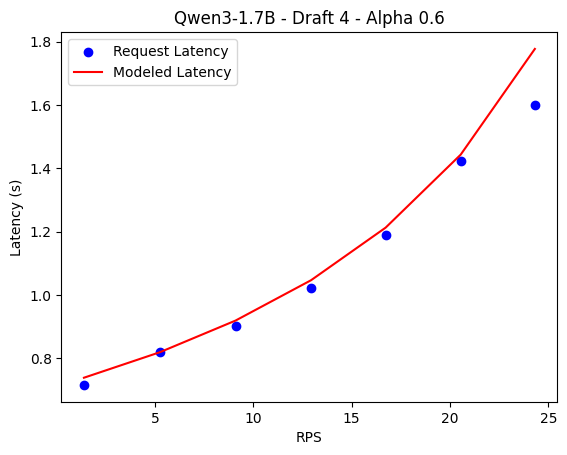

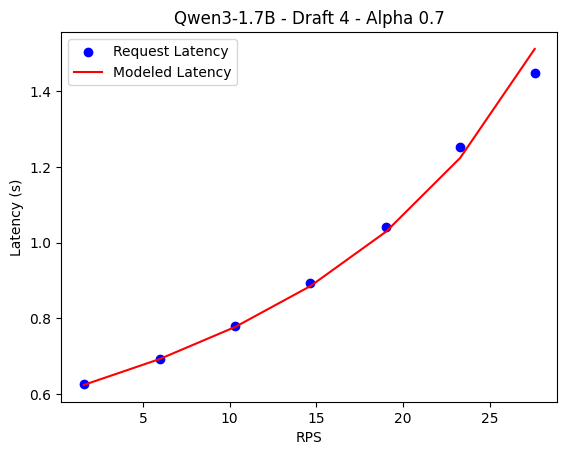

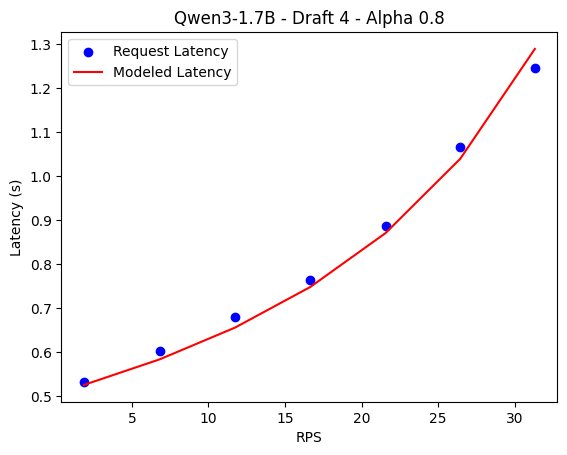

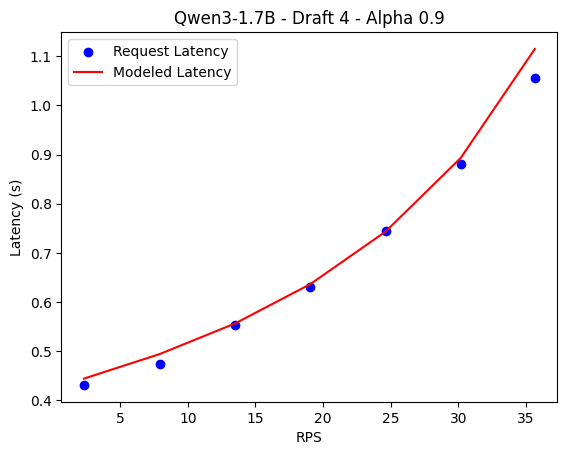

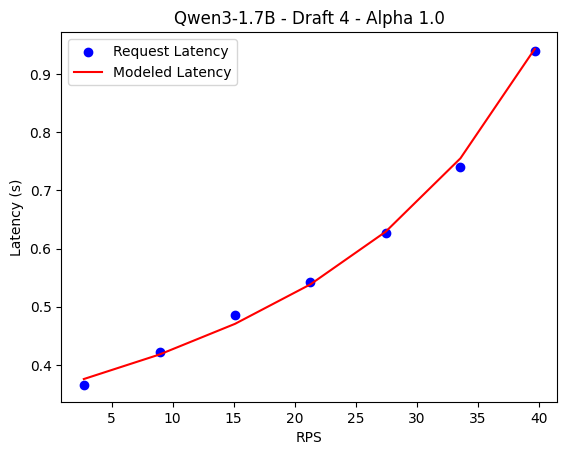

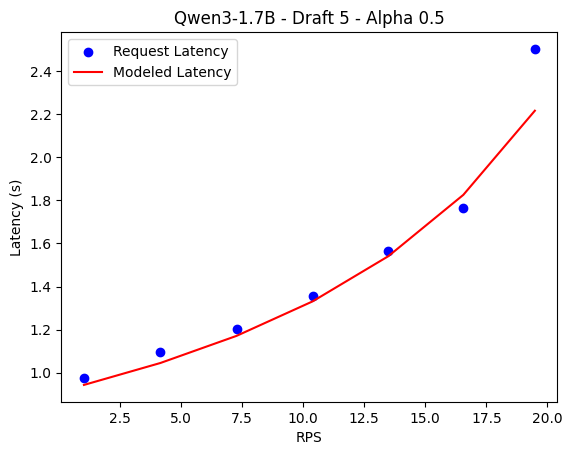

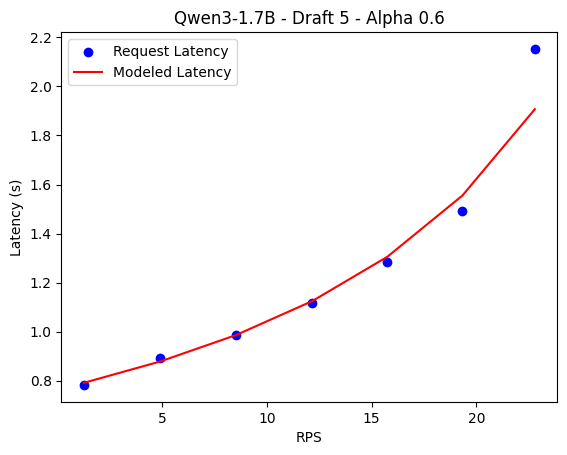

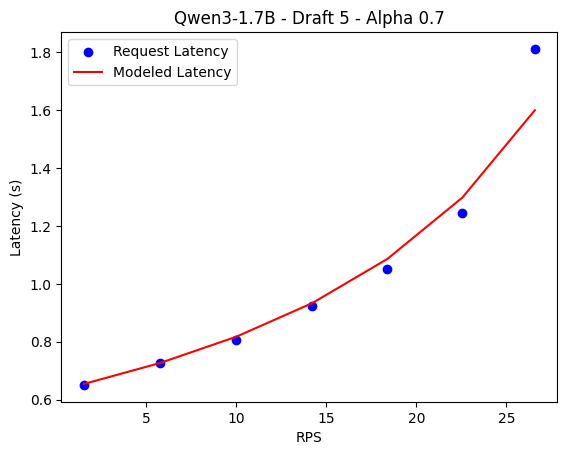

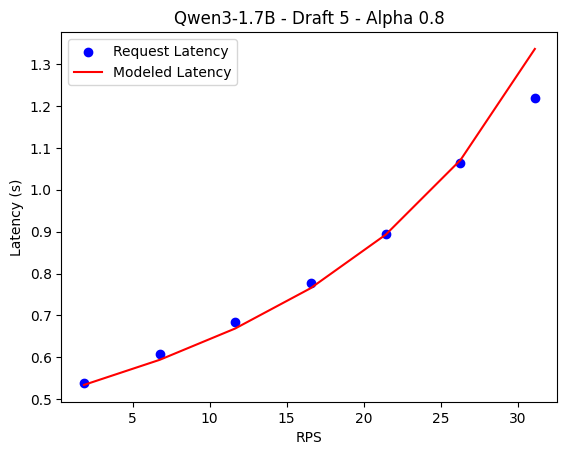

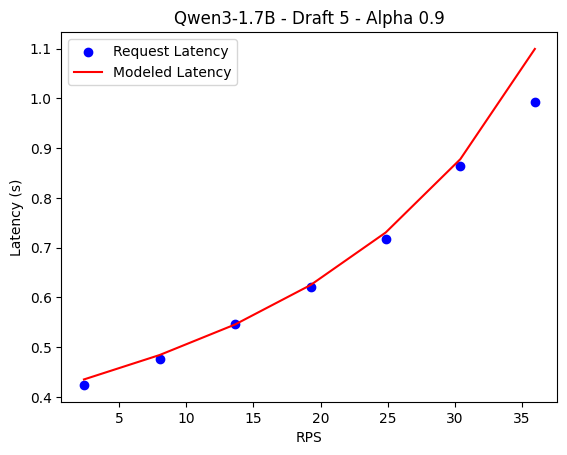

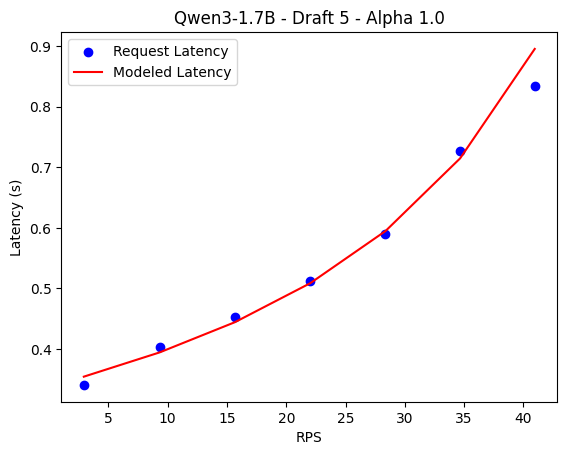

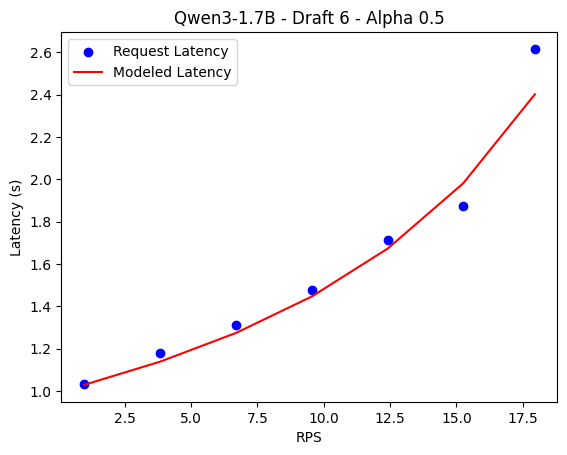

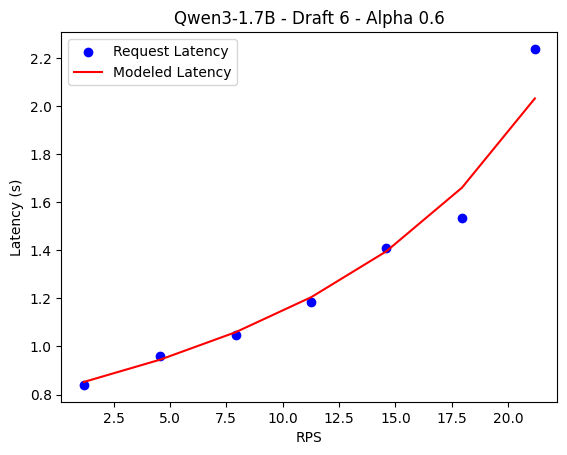

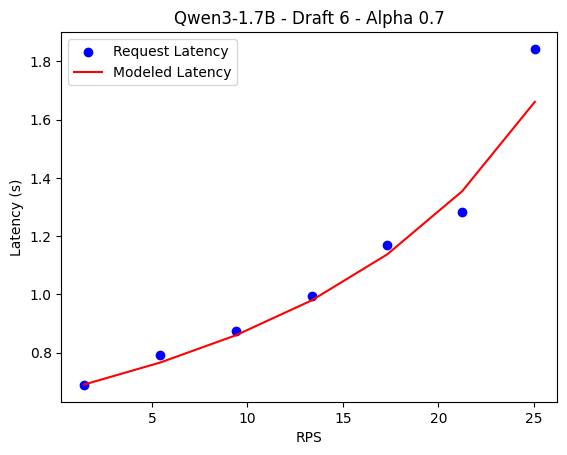

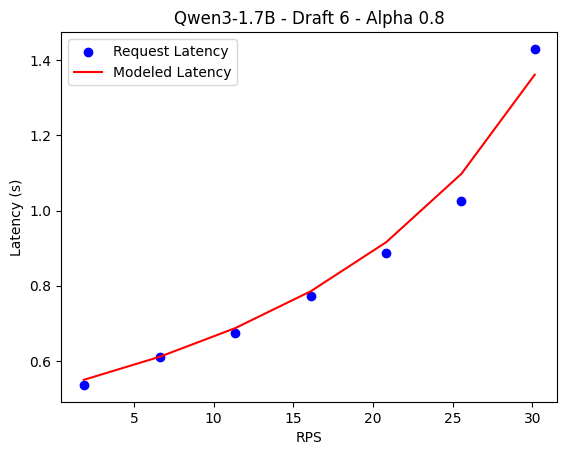

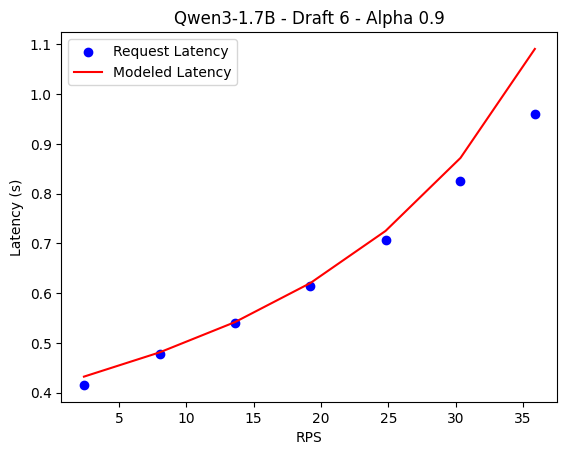

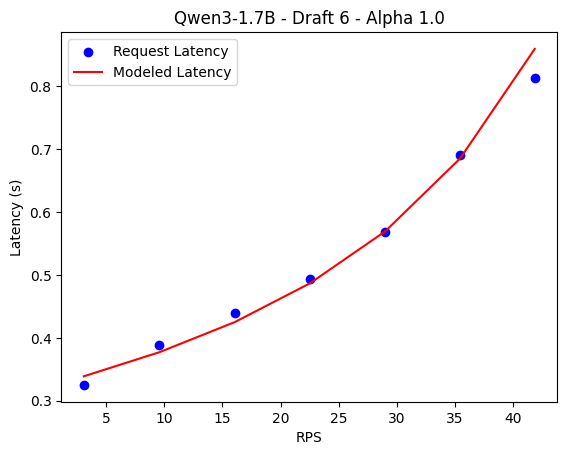

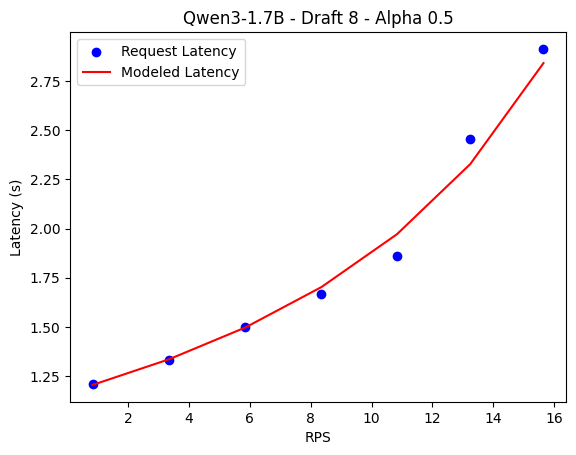

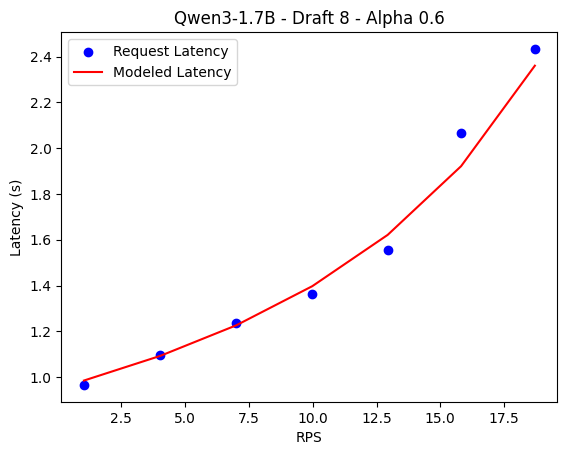

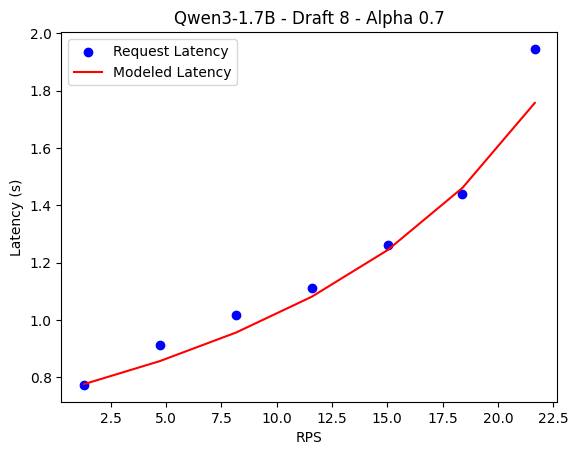

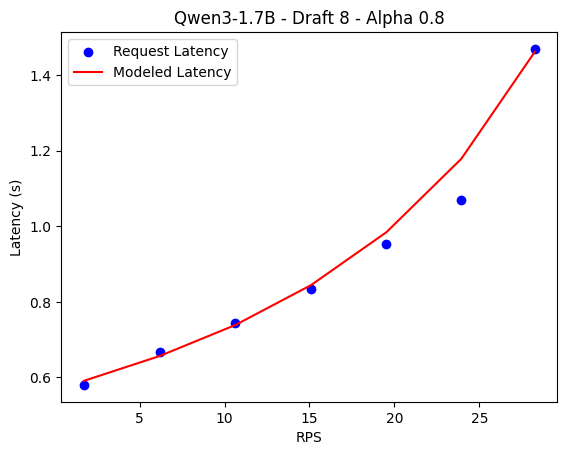

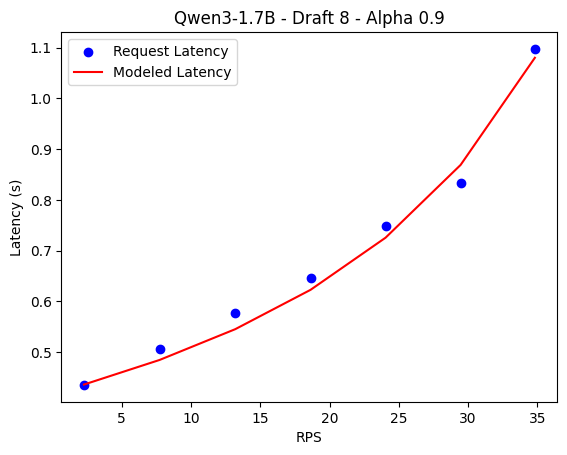

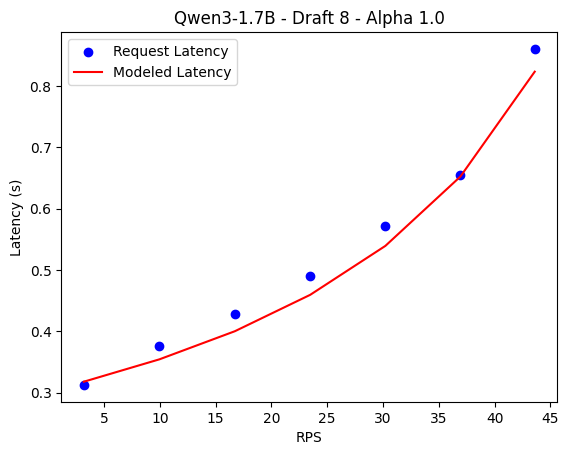

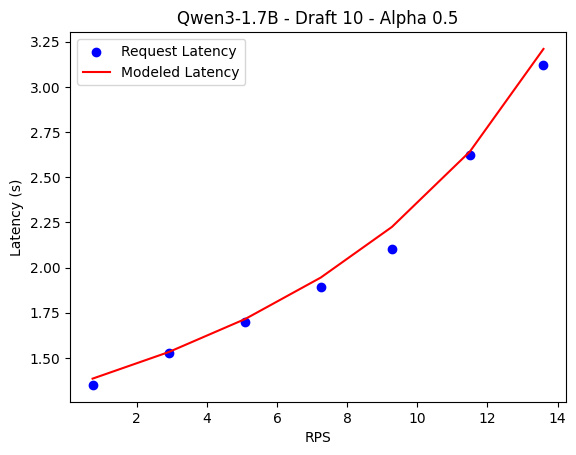

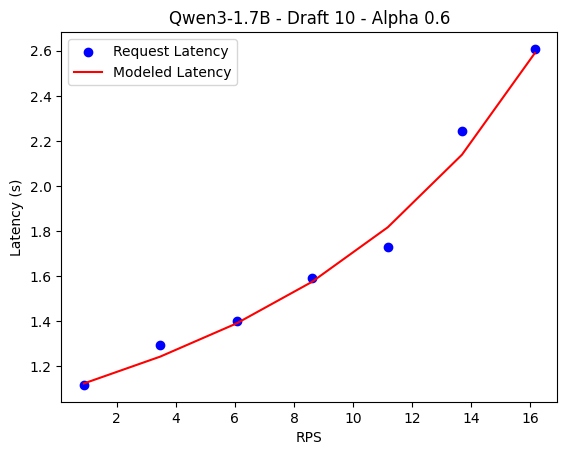

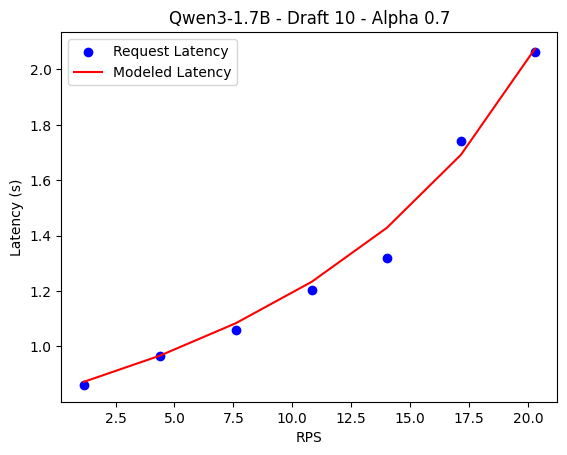

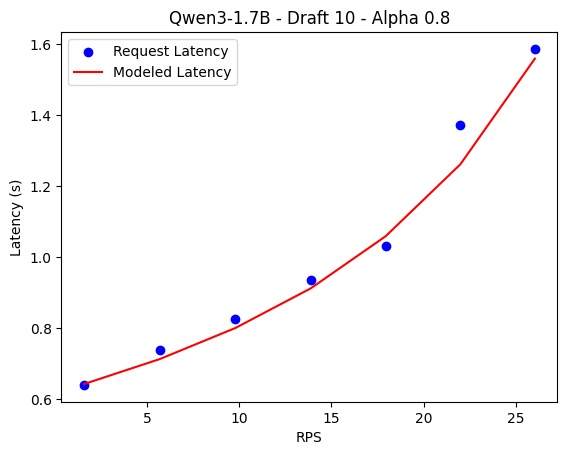

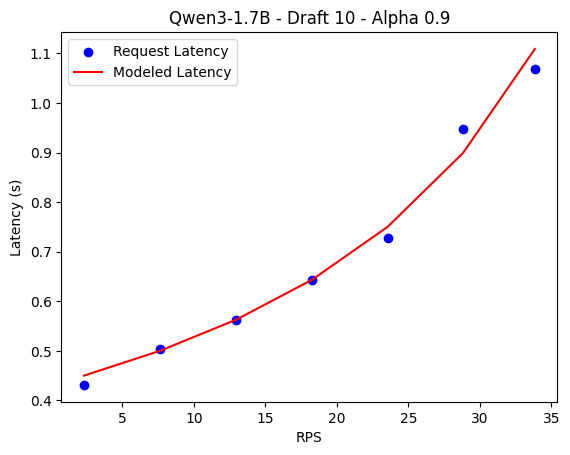

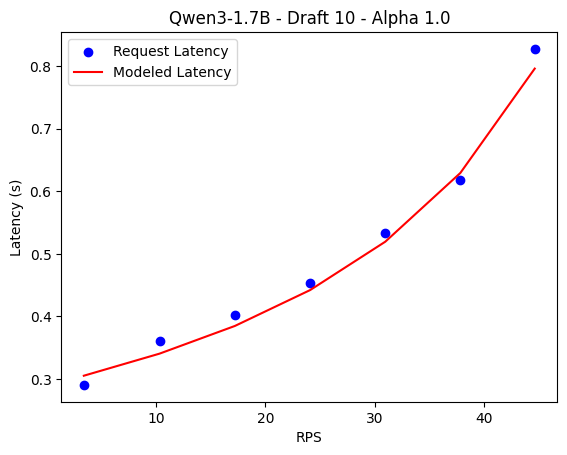

 33%|███▎      | 2/6 [00:04<00:09,  2.39s/it]

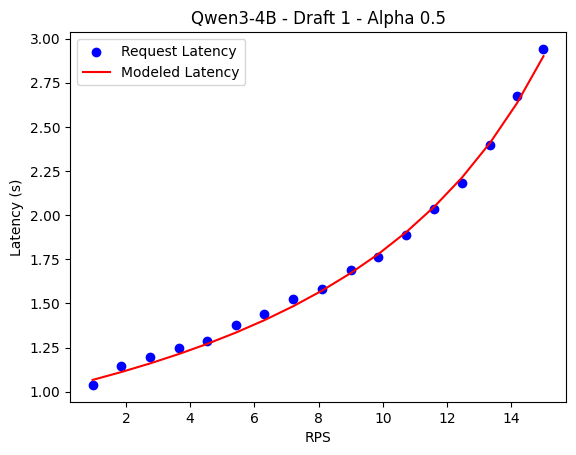

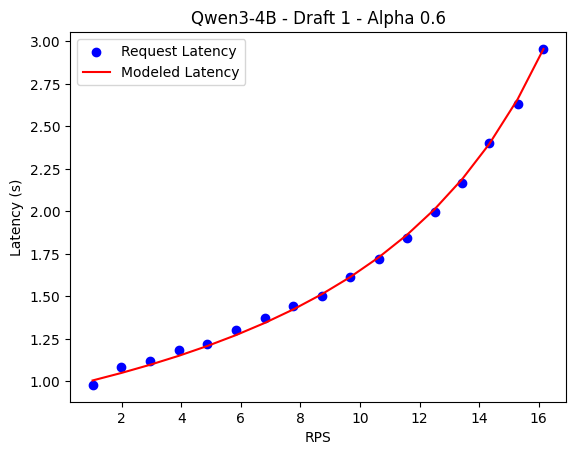

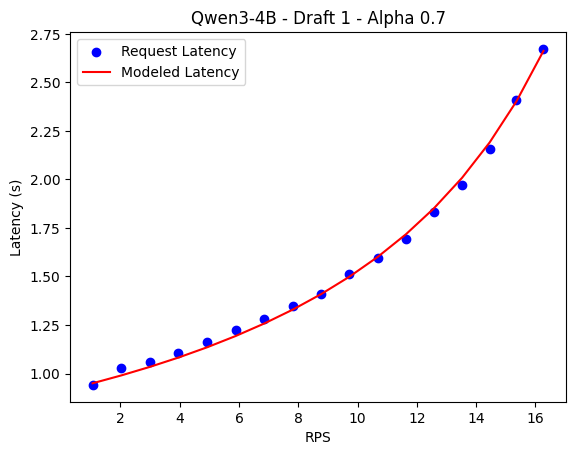

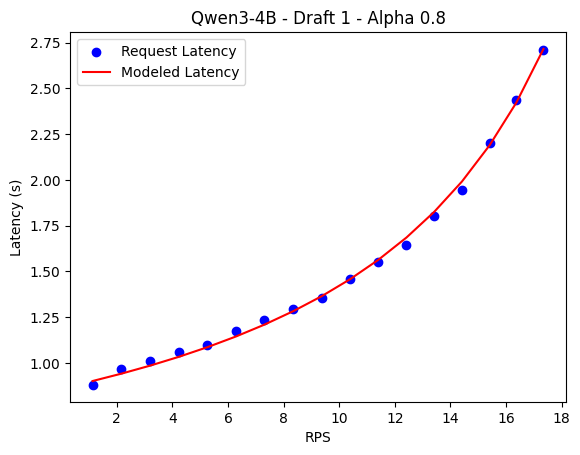

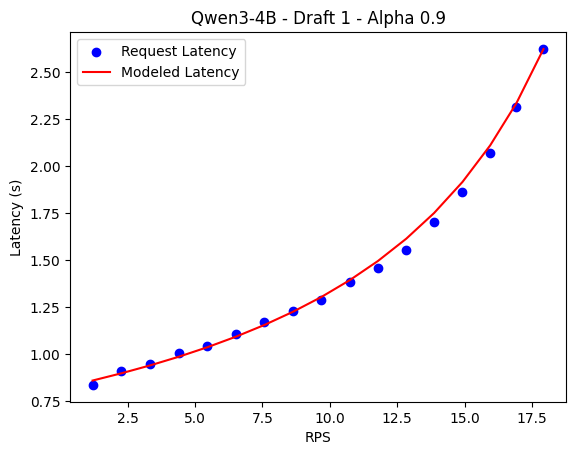

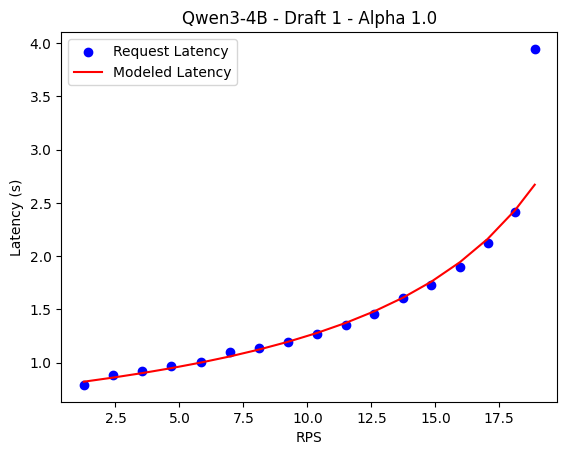

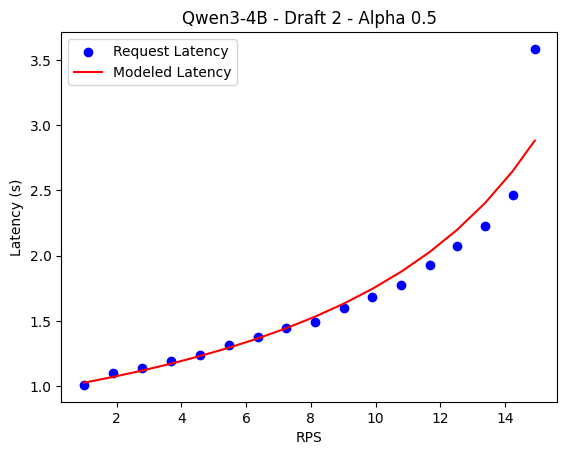

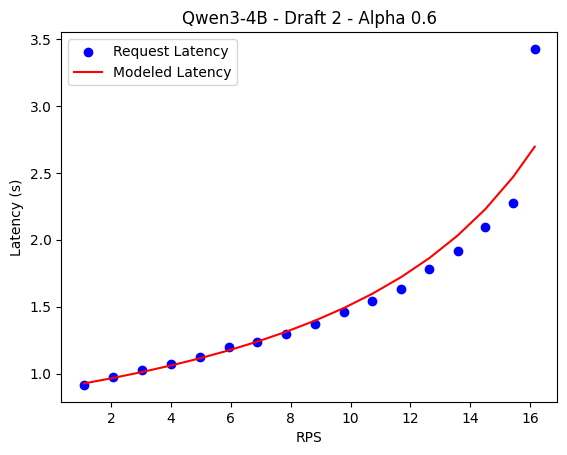

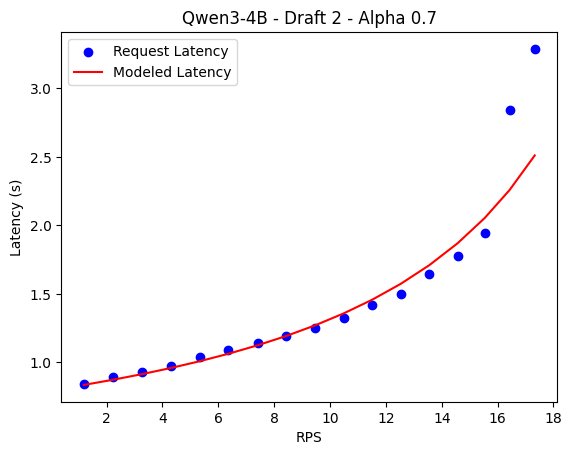

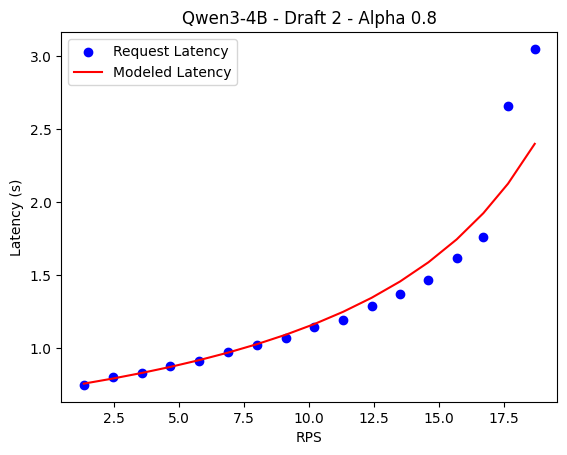

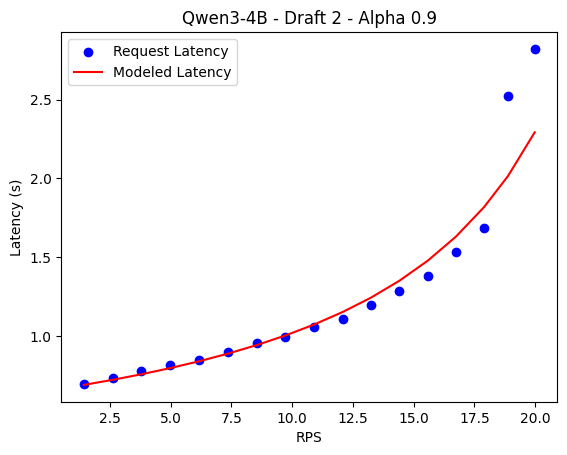

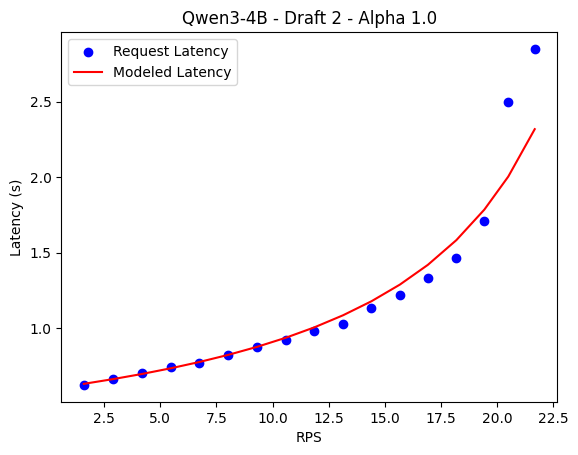

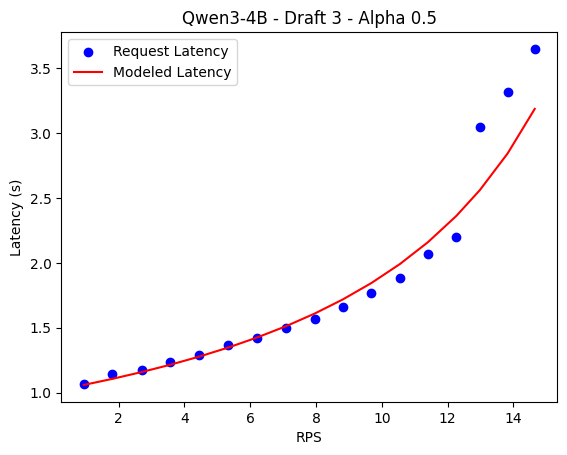

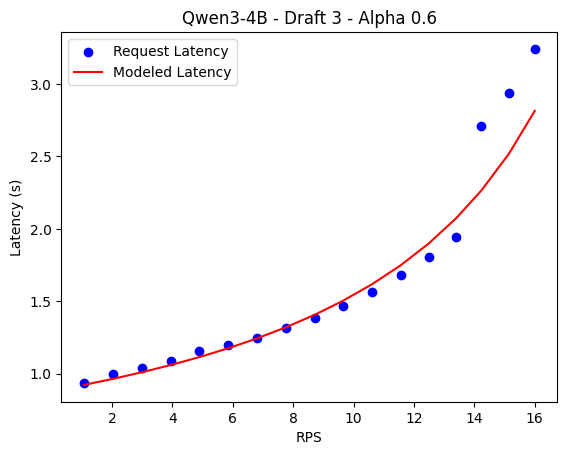

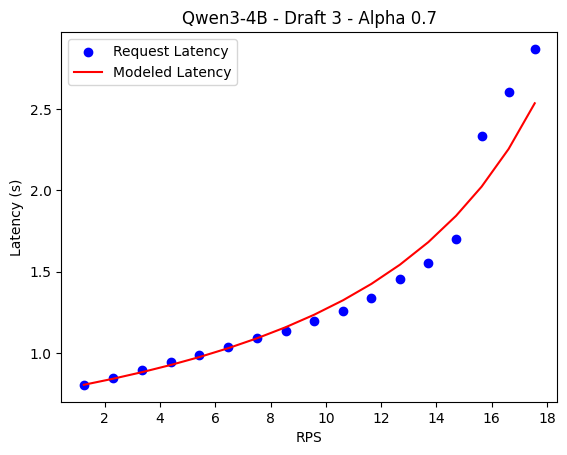

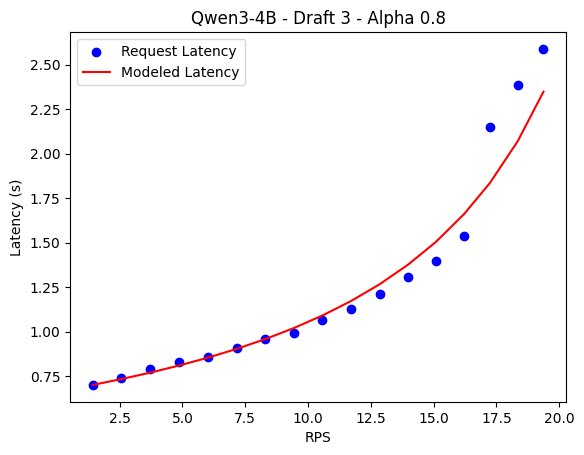

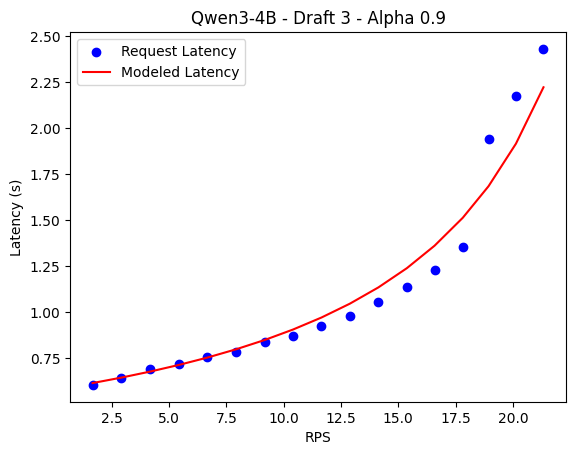

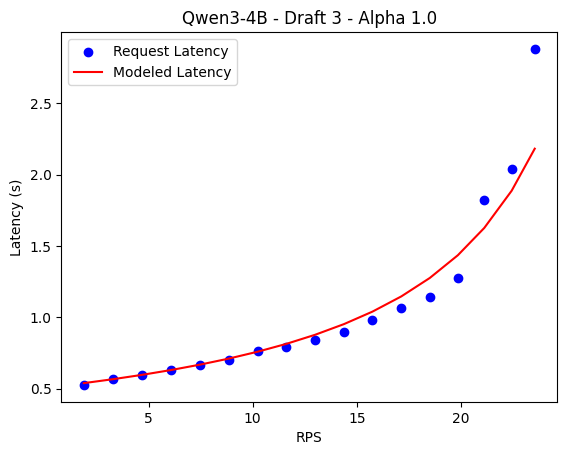

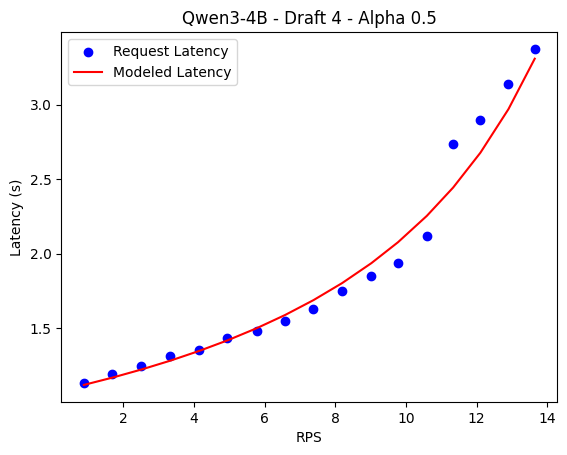

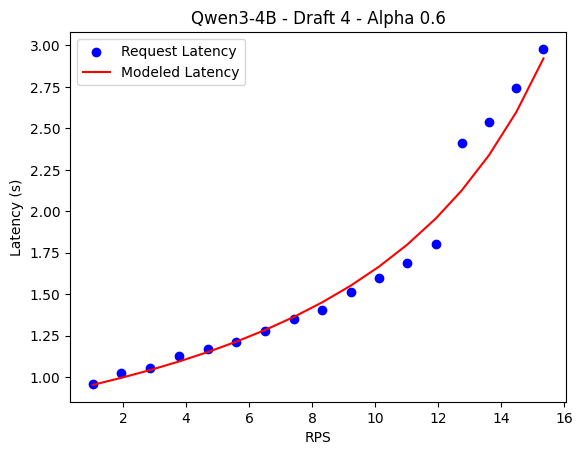

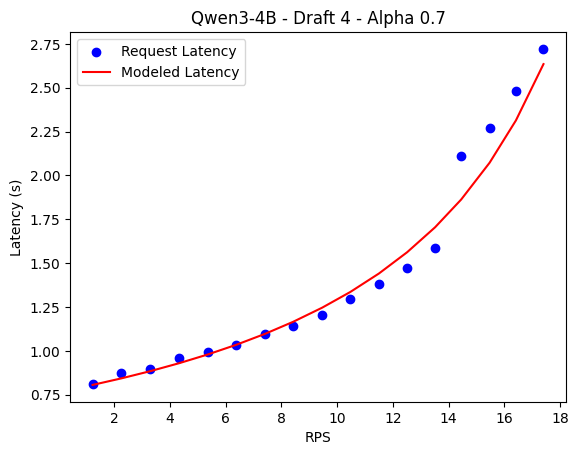

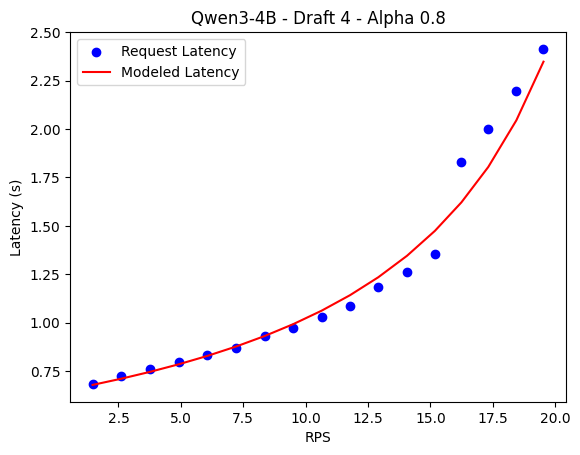

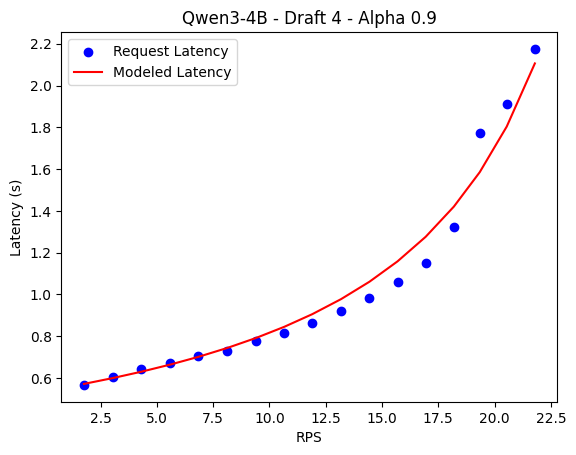

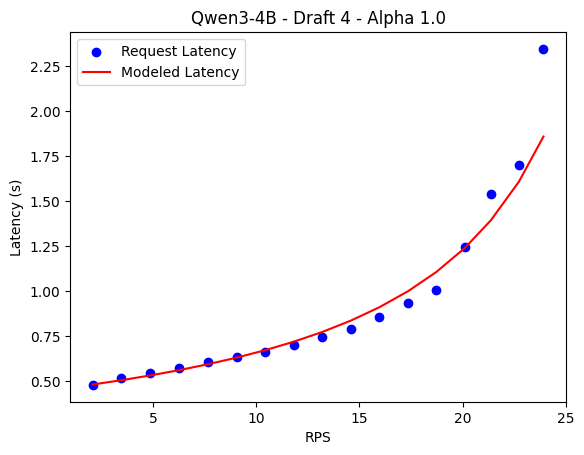

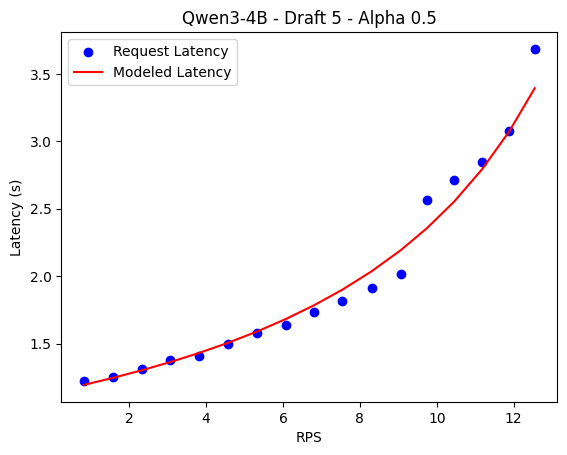

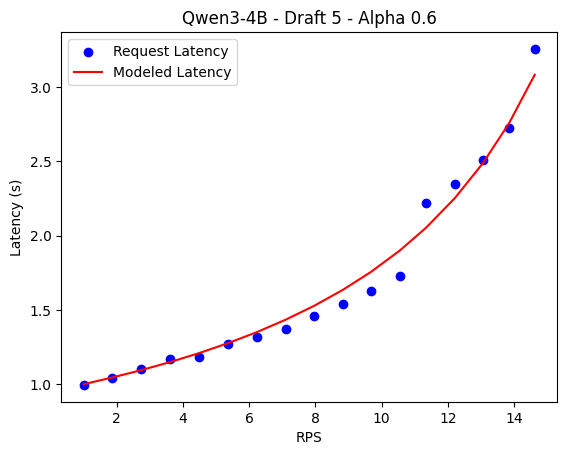

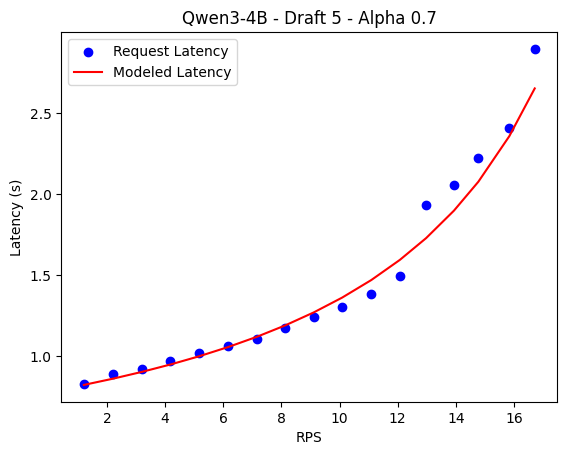

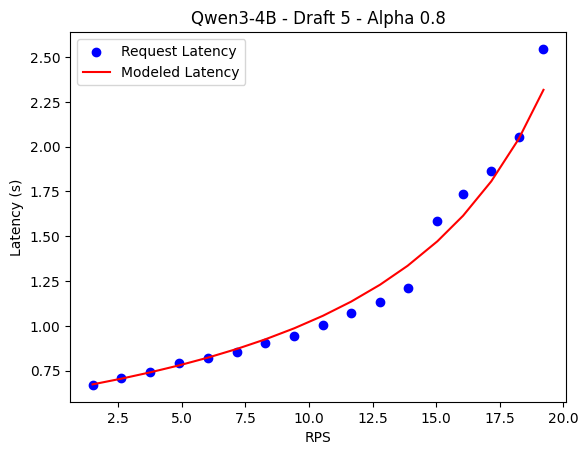

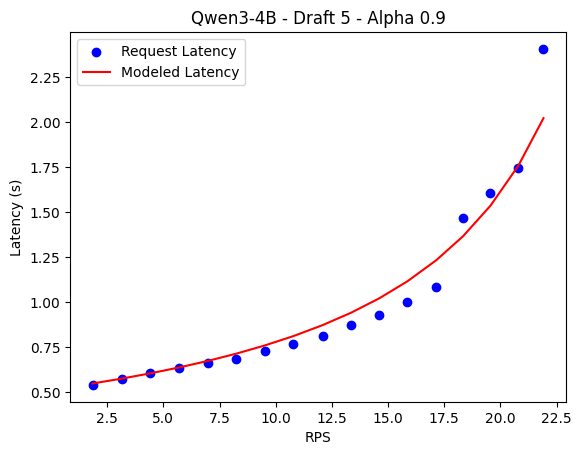

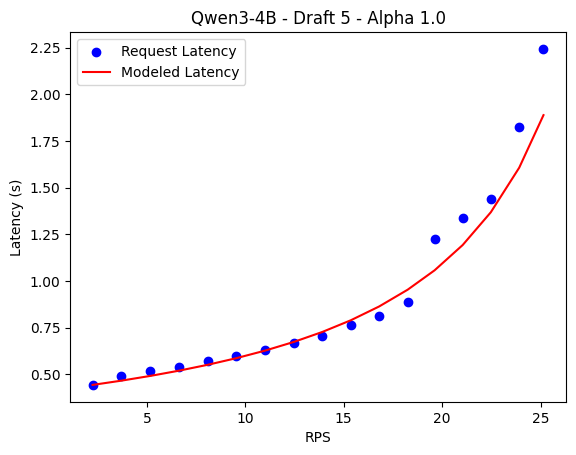

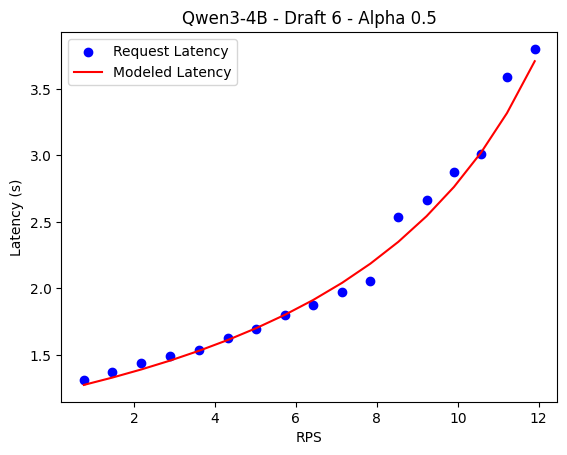

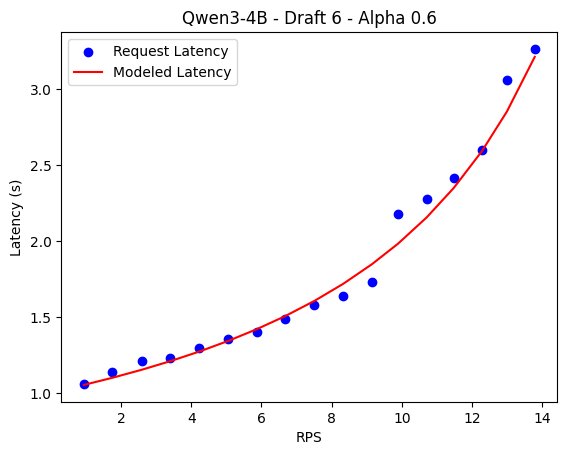

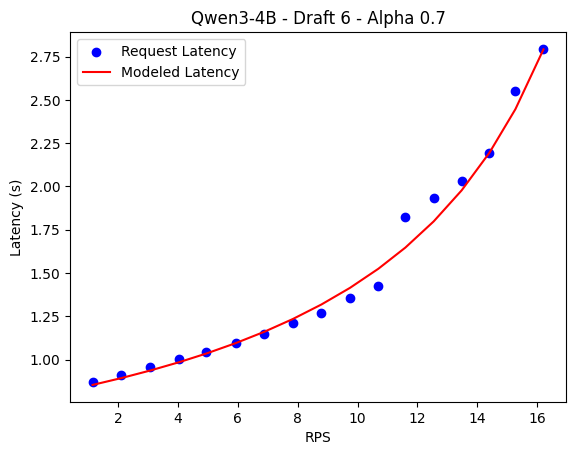

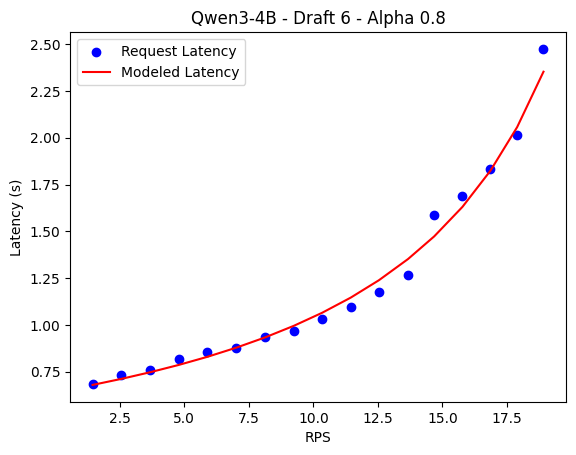

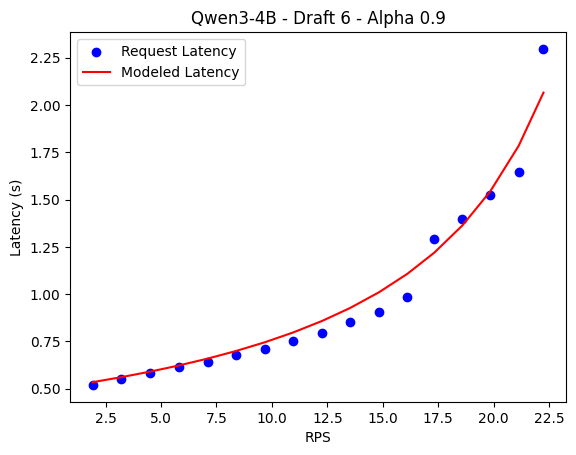

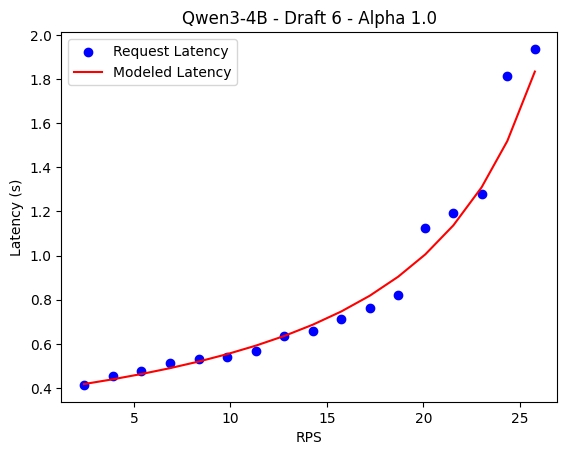

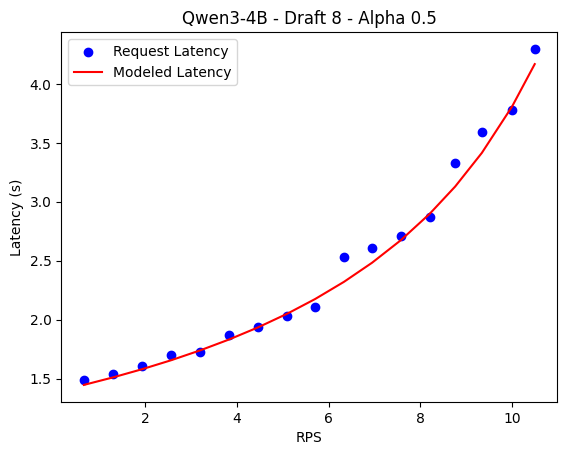

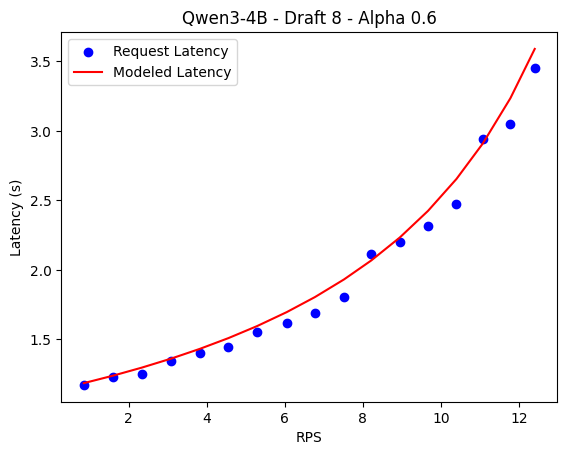

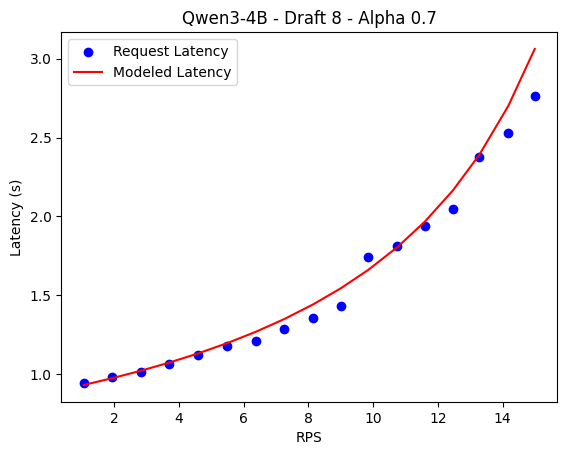

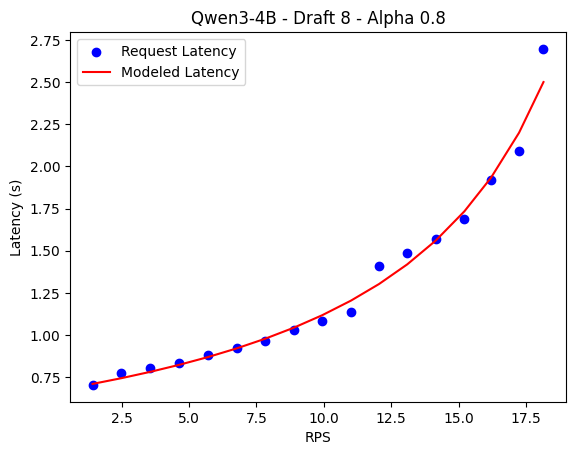

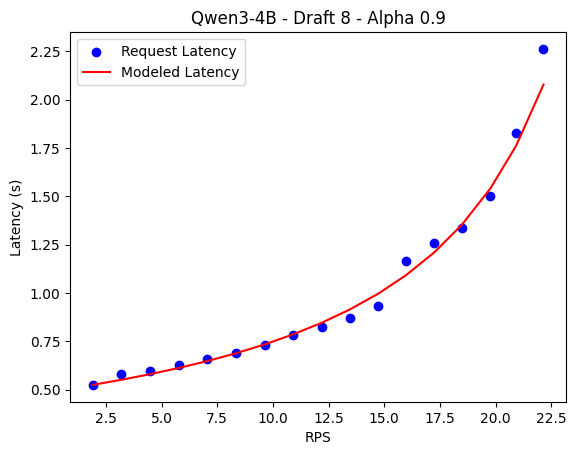

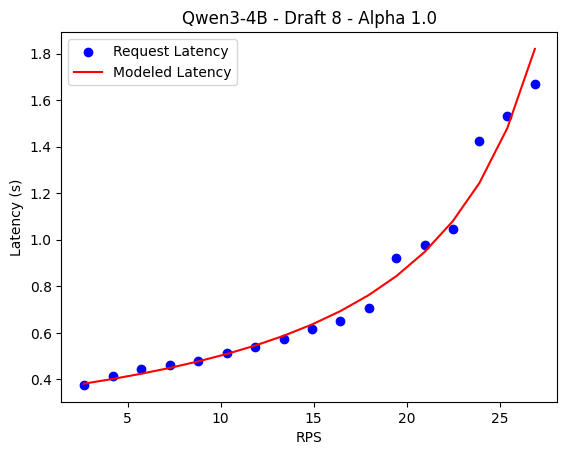

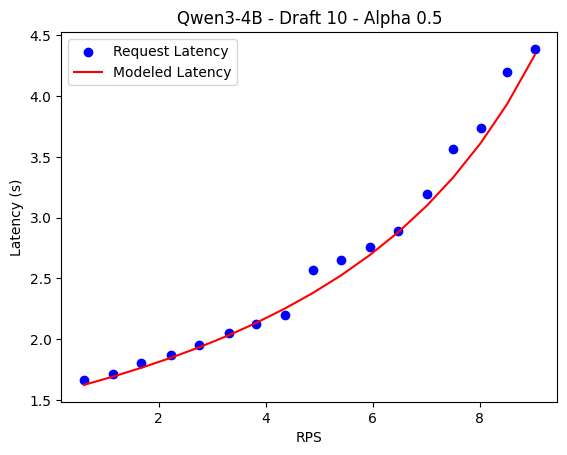

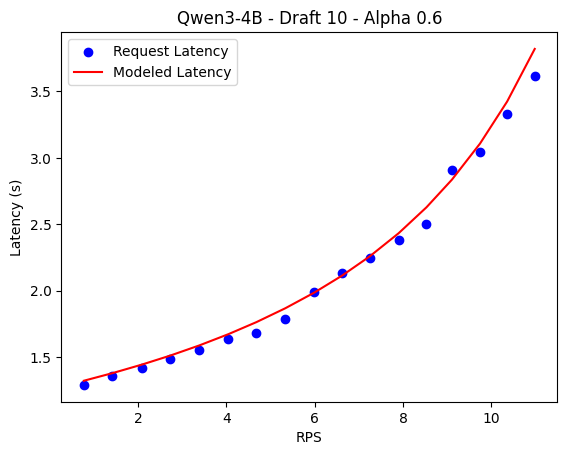

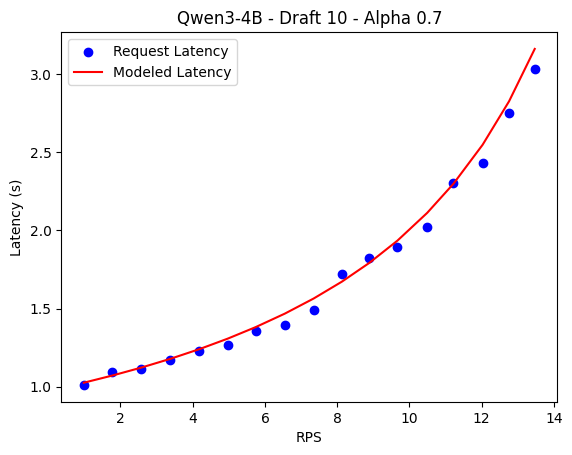

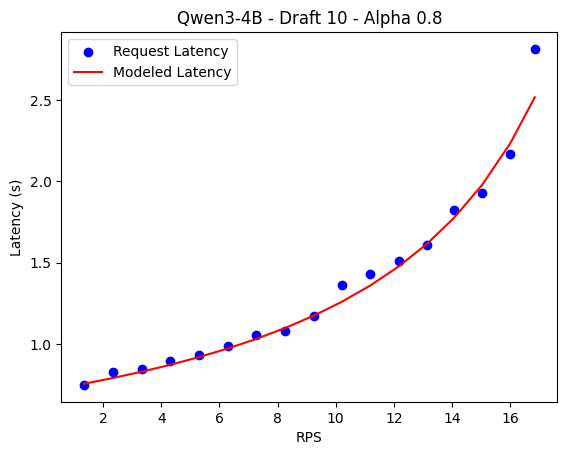

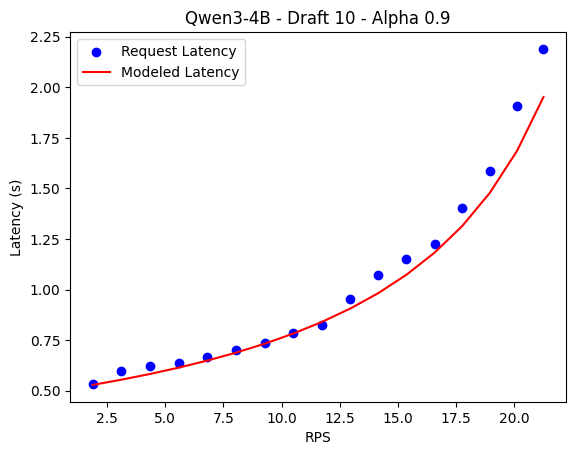

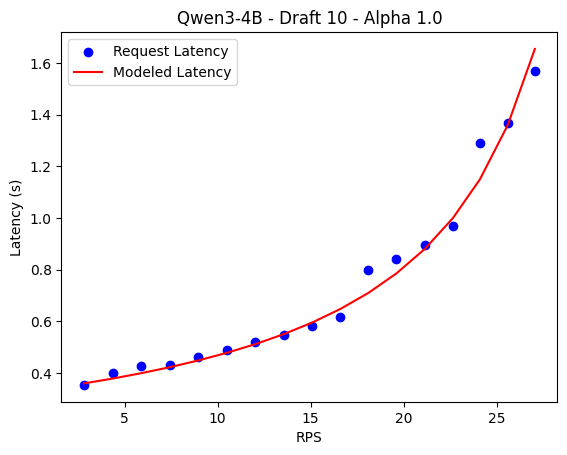

 50%|█████     | 3/6 [00:07<00:07,  2.50s/it]

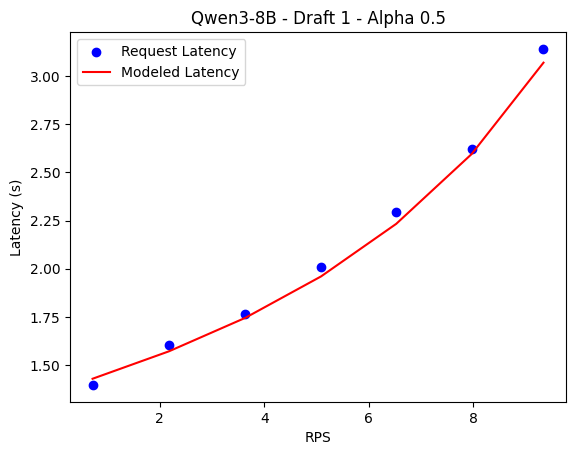

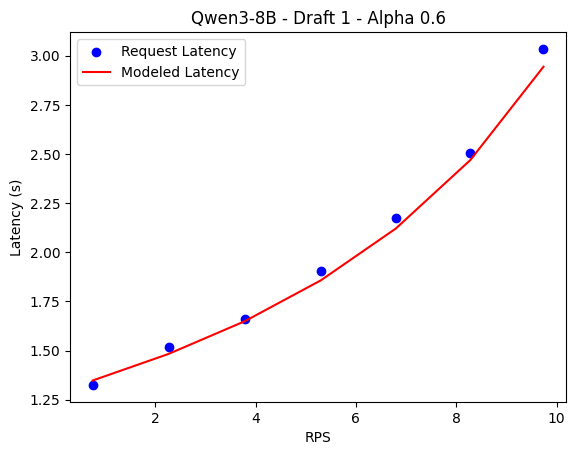

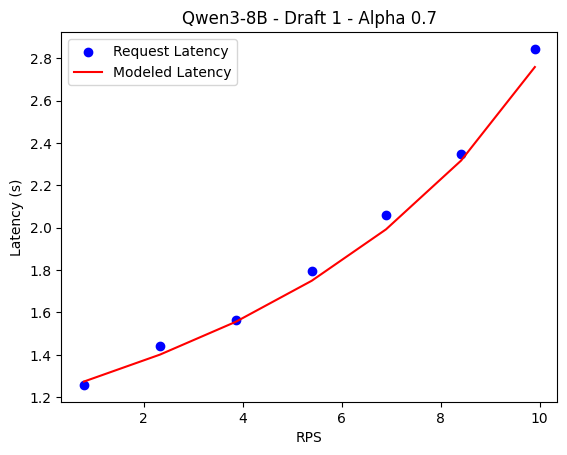

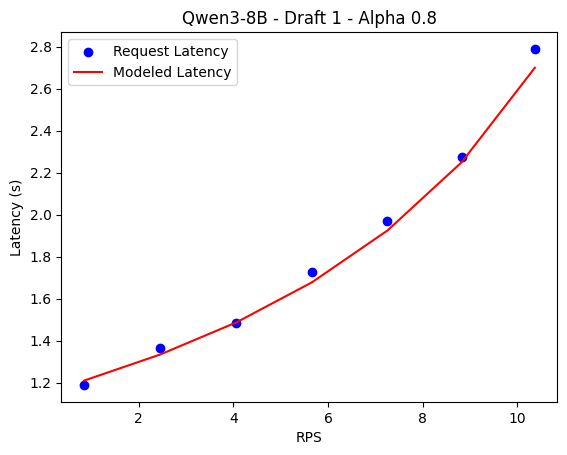

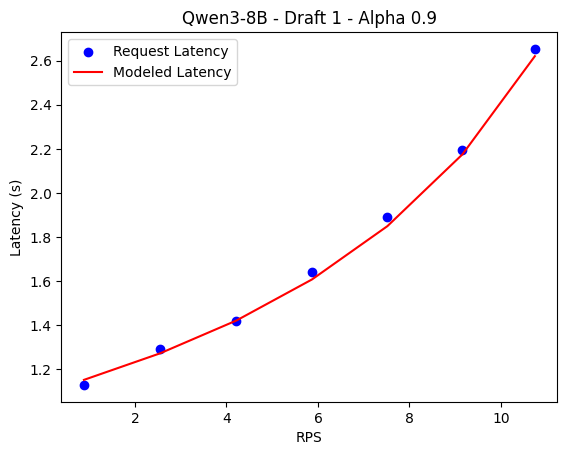

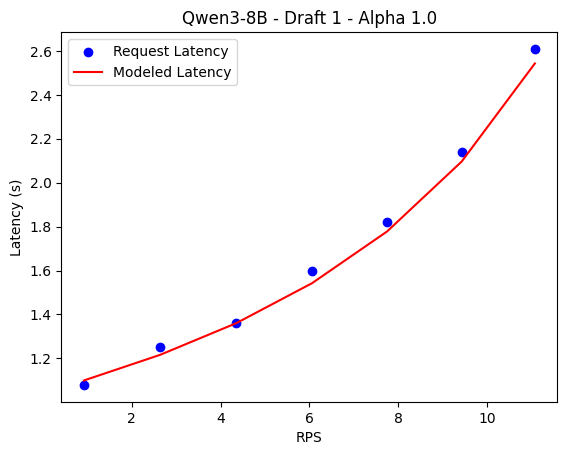

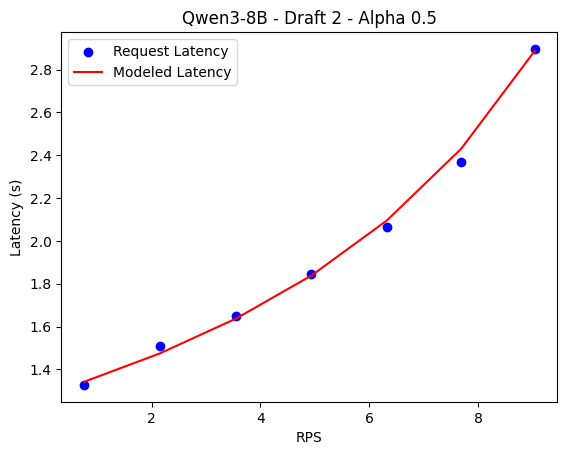

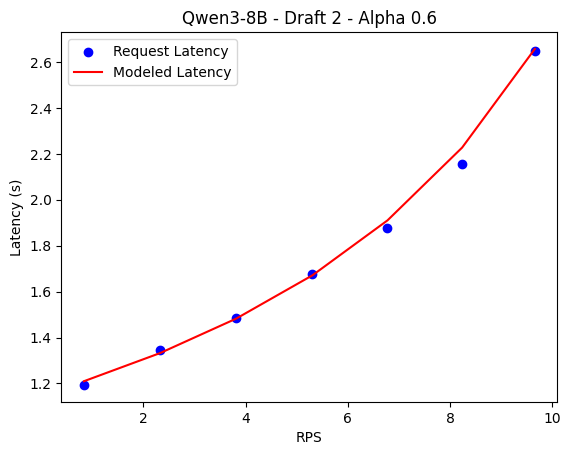

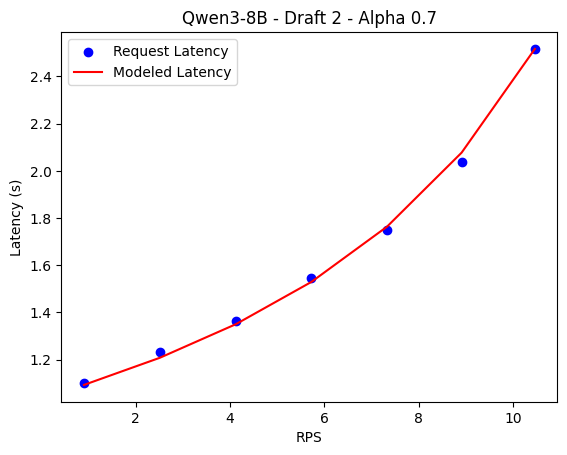

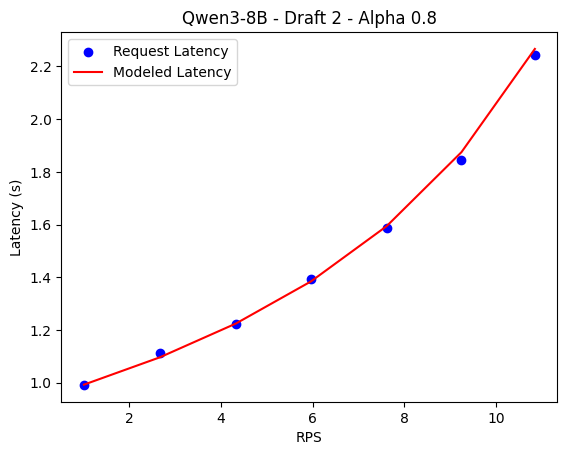

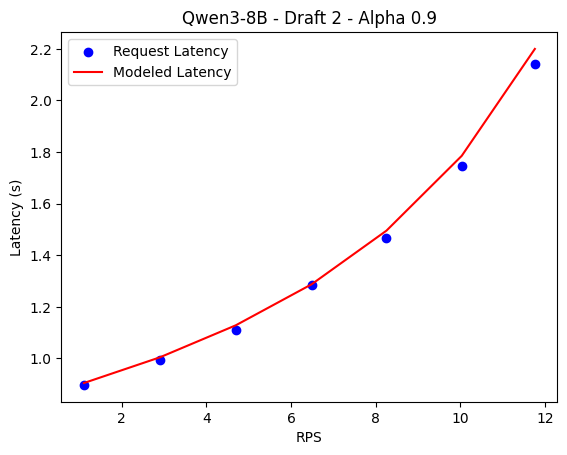

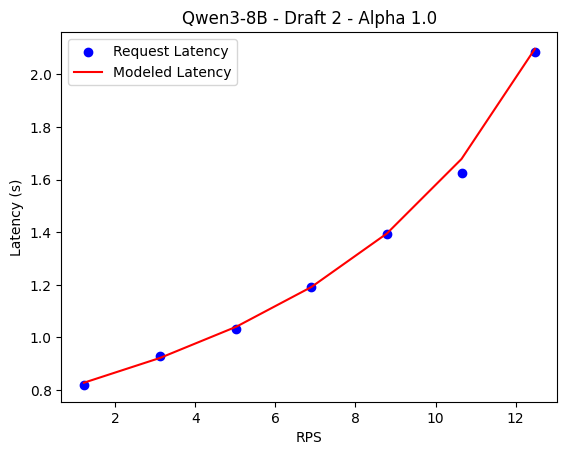

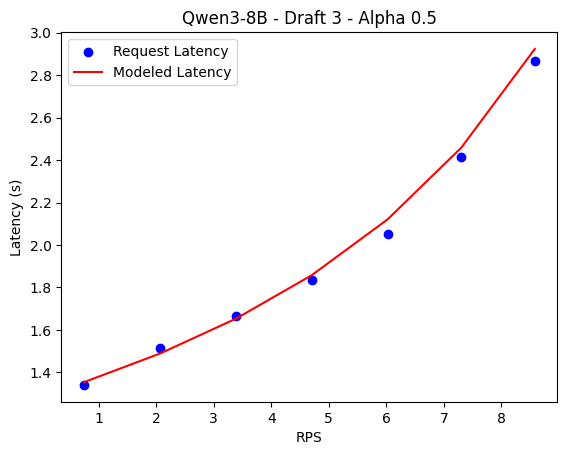

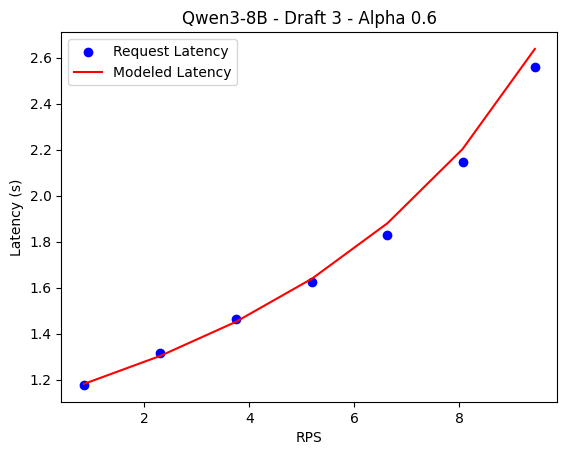

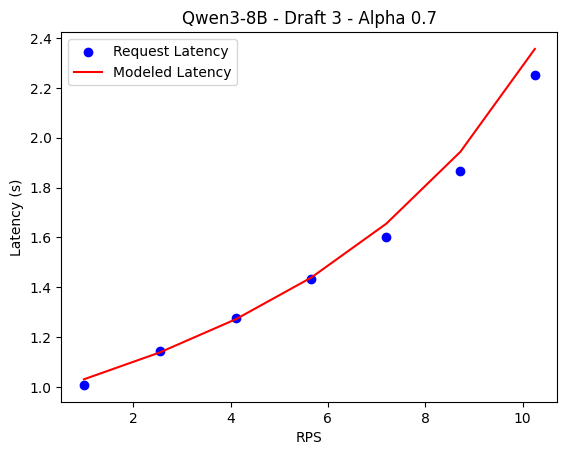

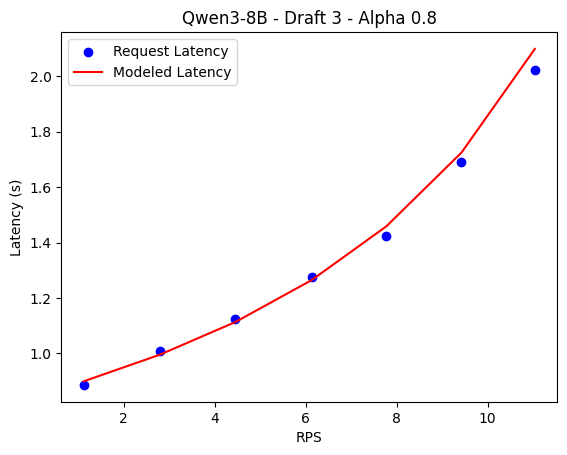

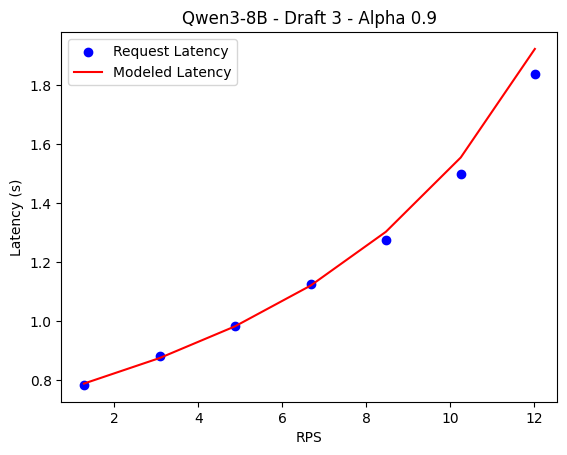

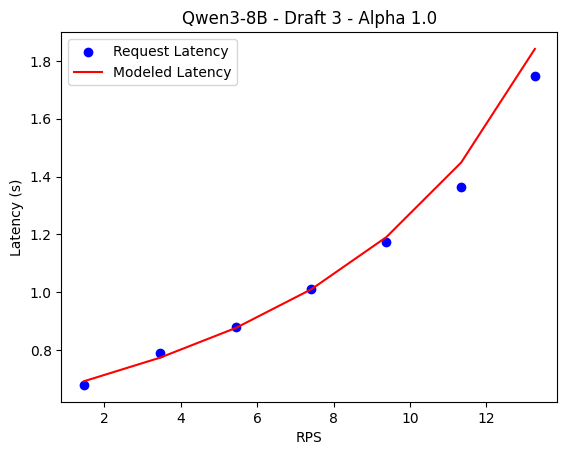

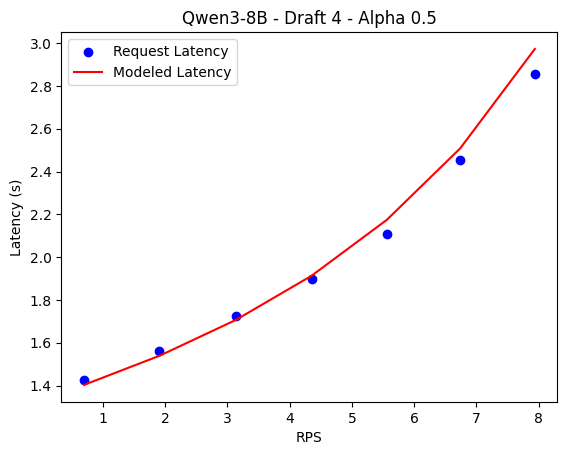

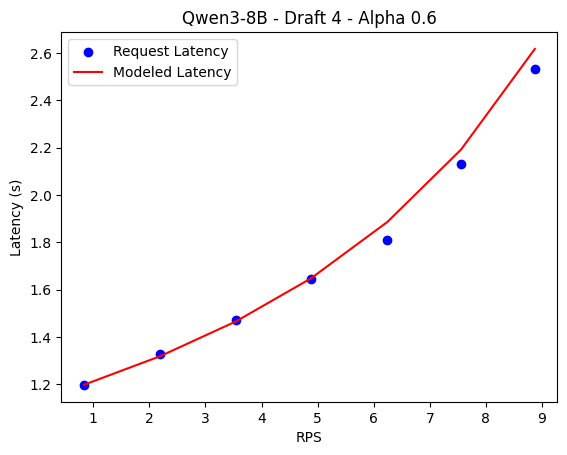

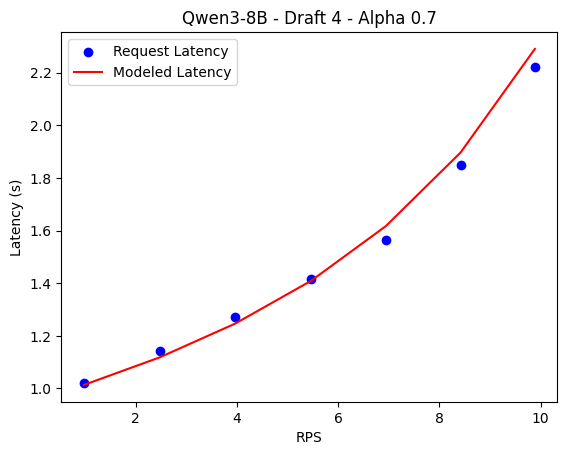

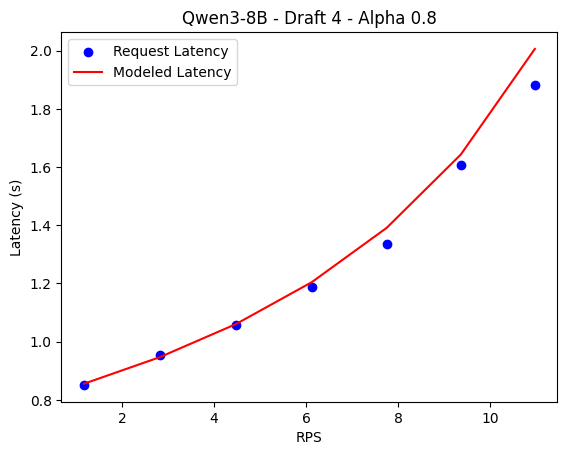

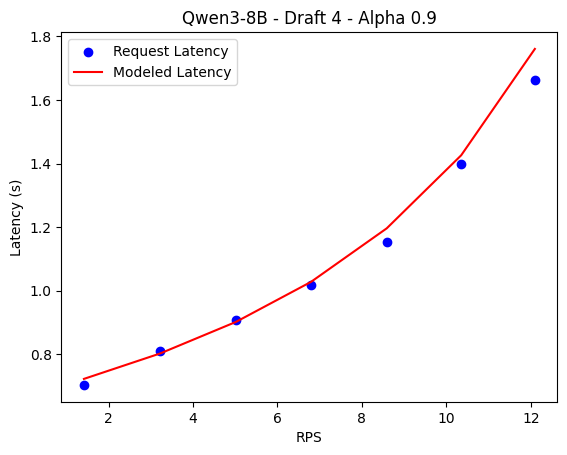

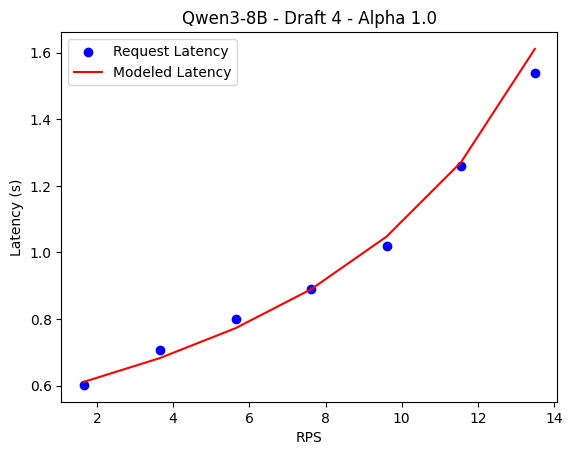

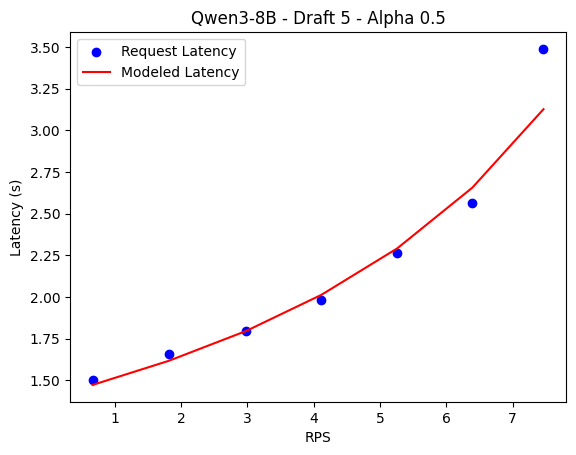

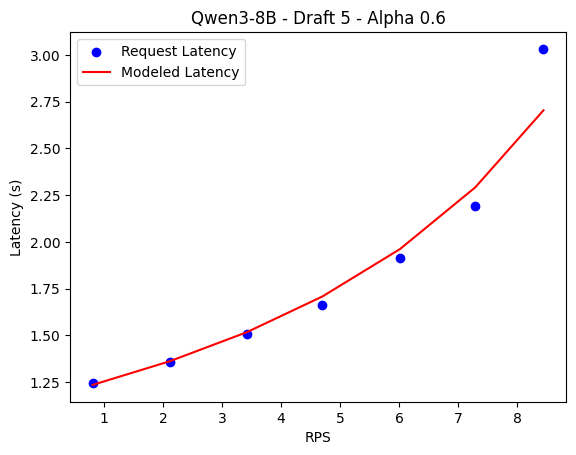

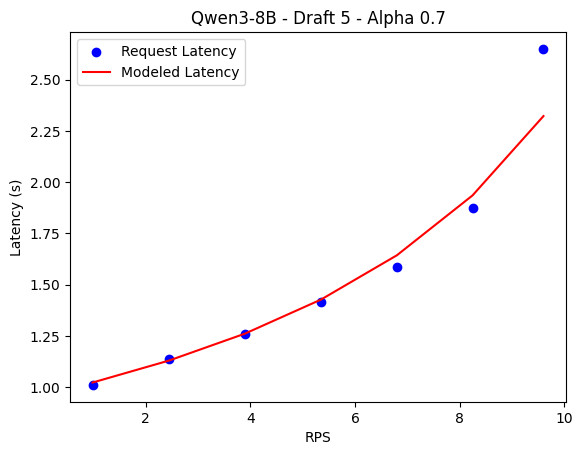

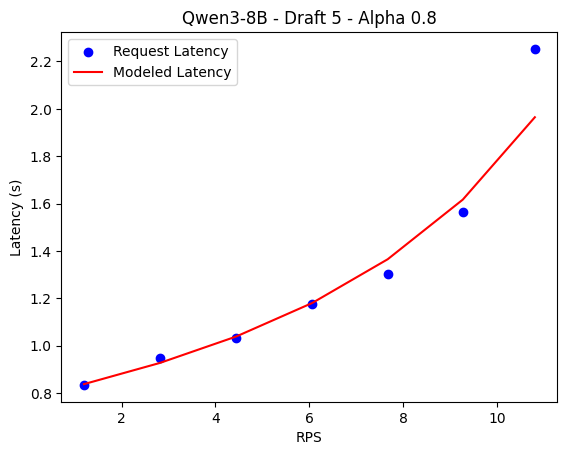

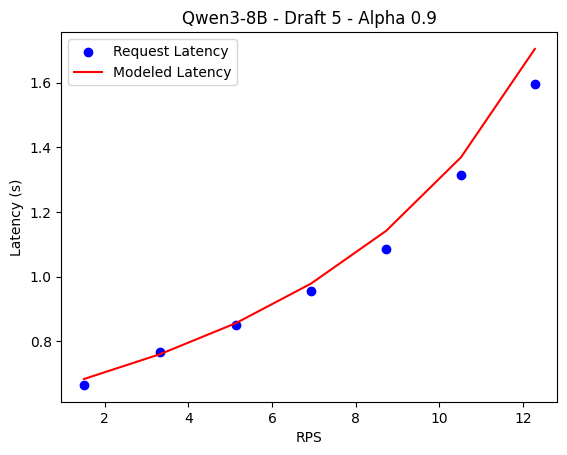

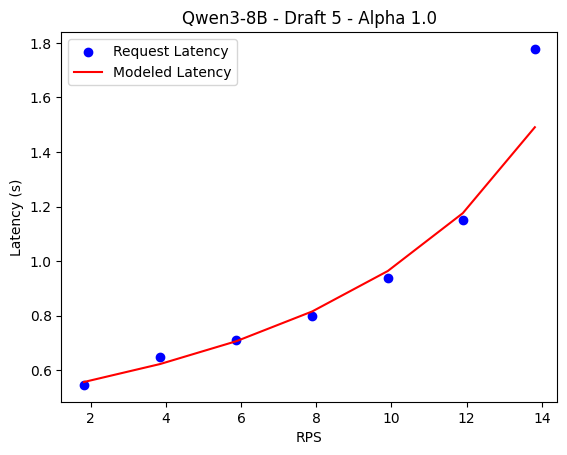

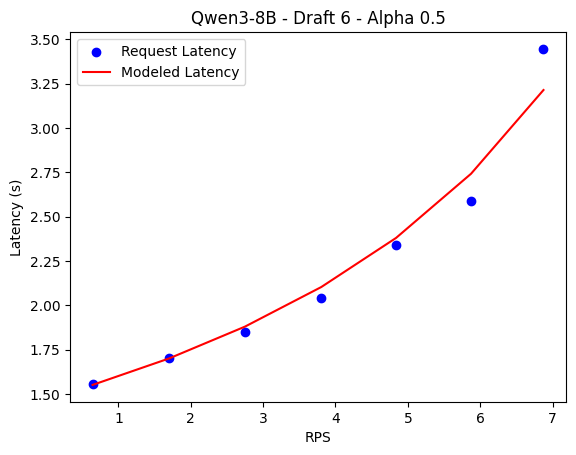

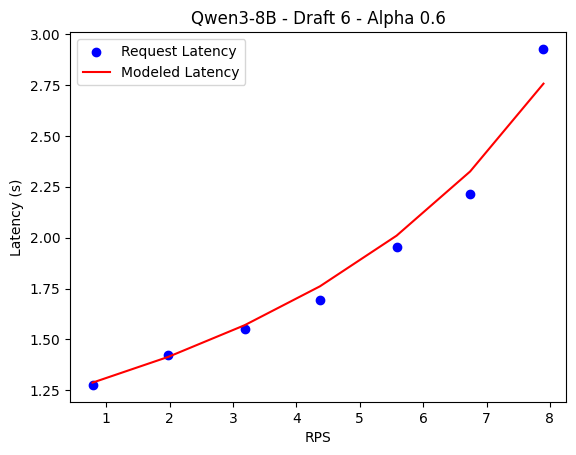

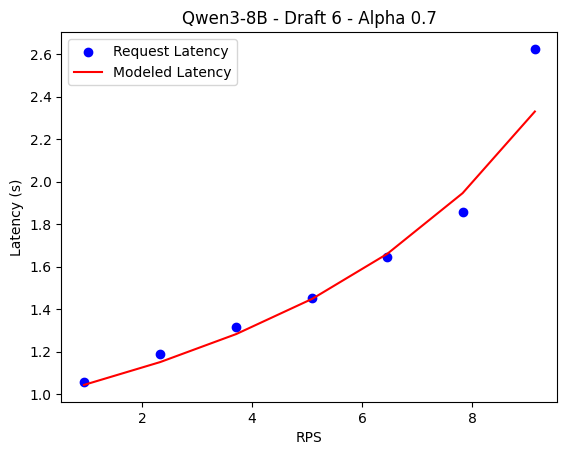

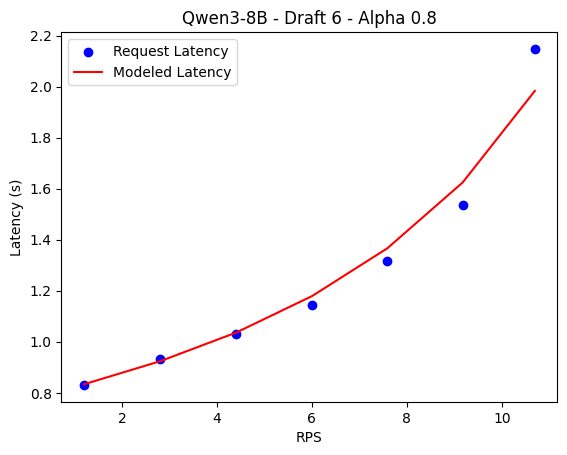

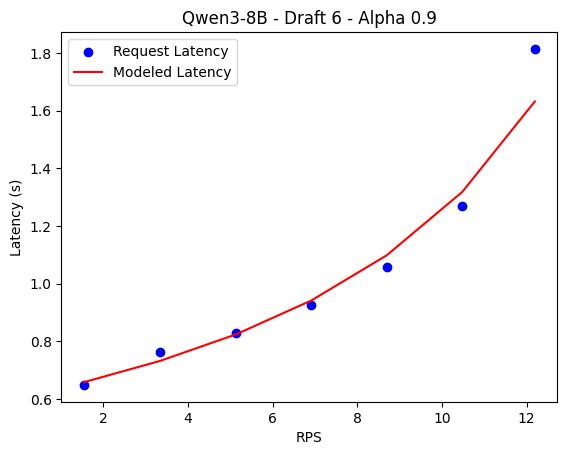

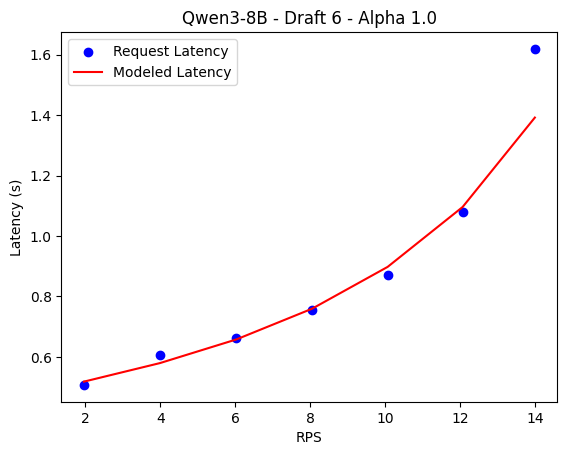

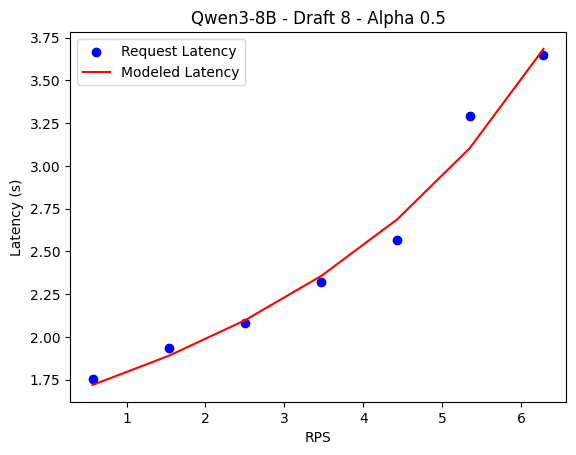

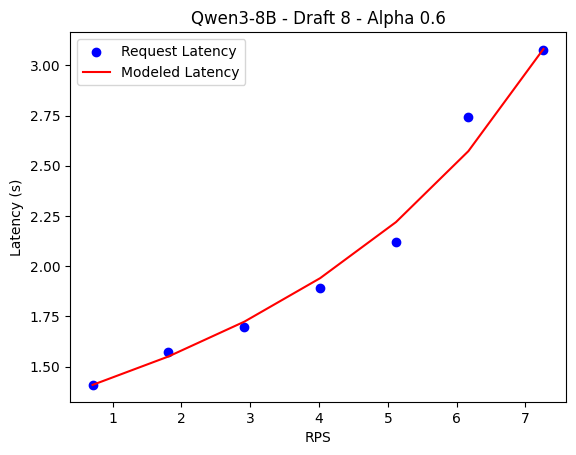

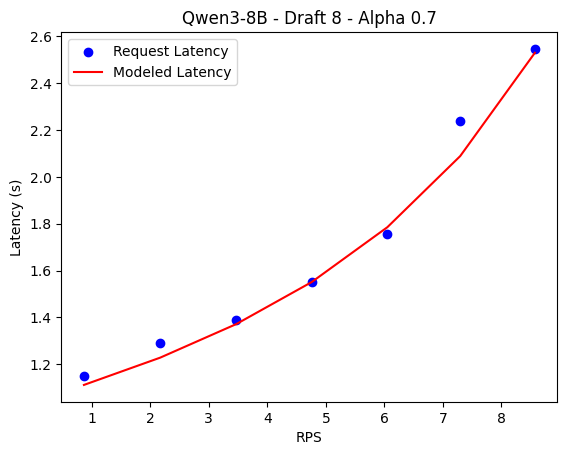

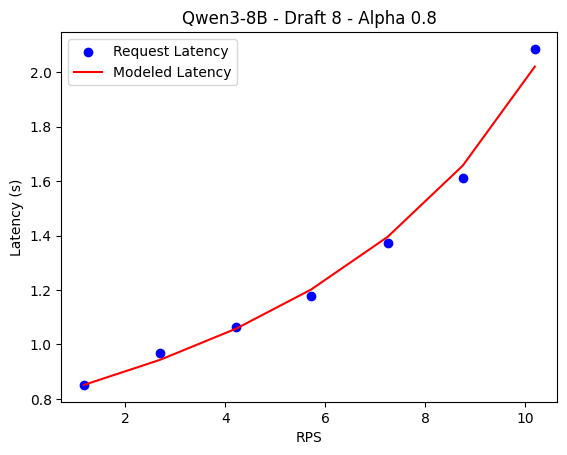

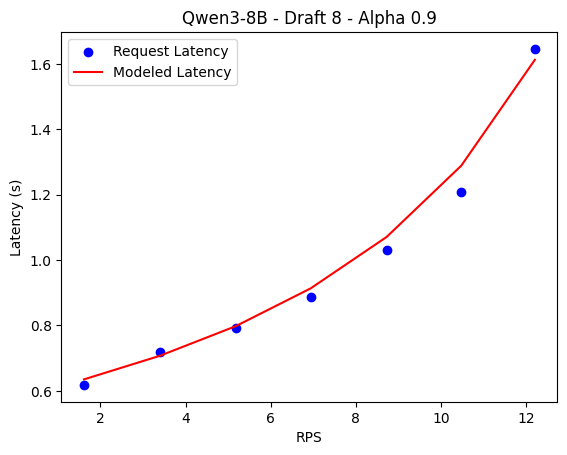

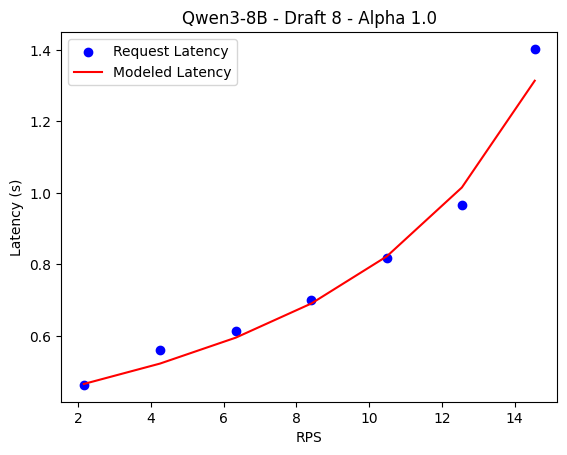

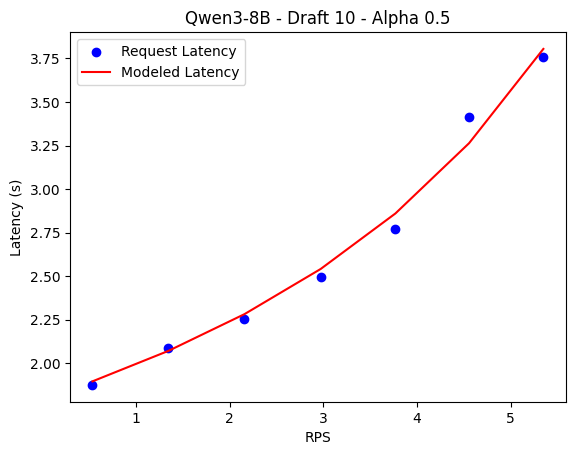

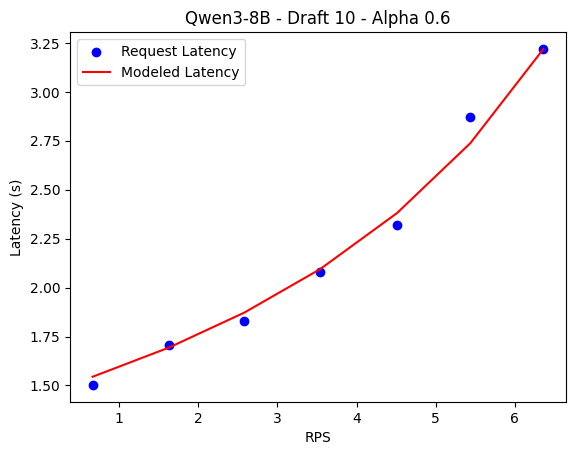

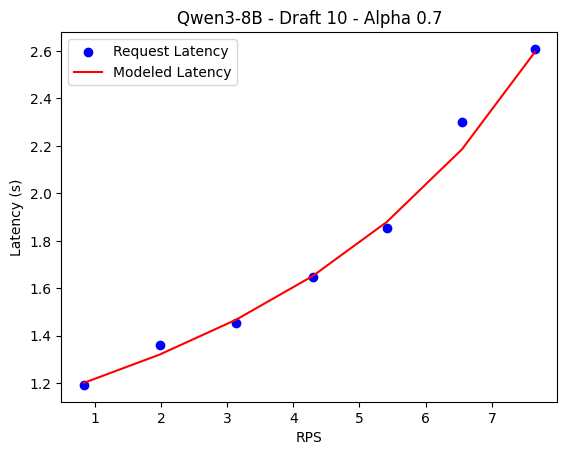

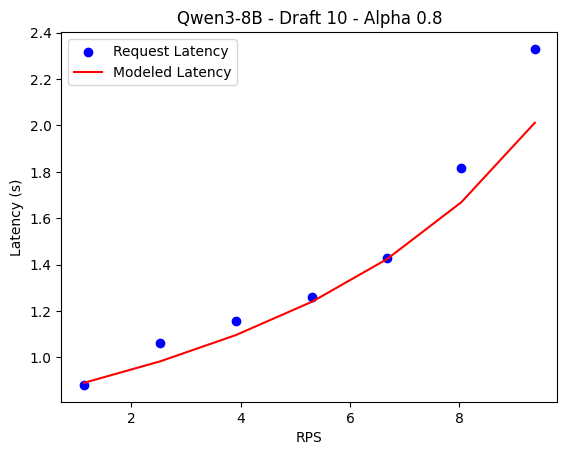

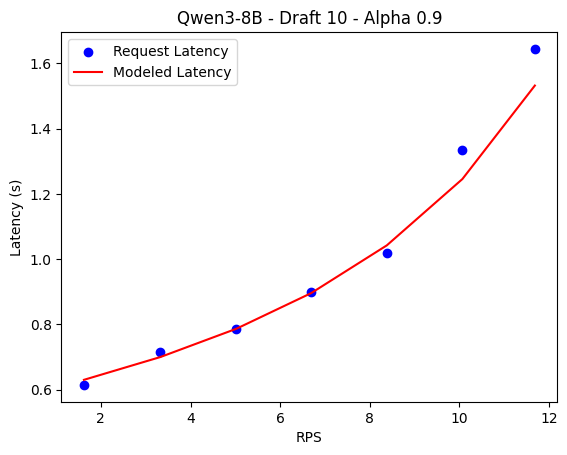

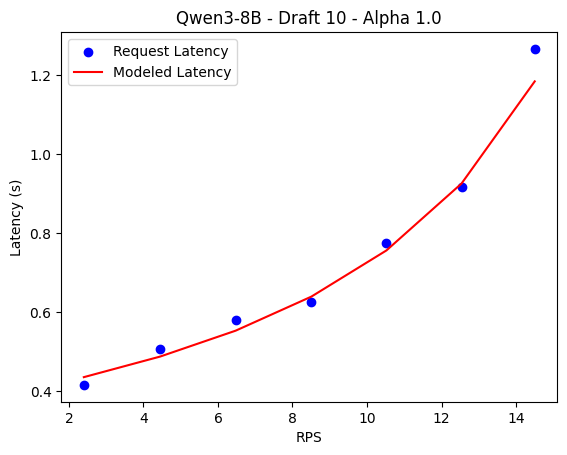

 67%|██████▋   | 4/6 [00:10<00:05,  2.55s/it]

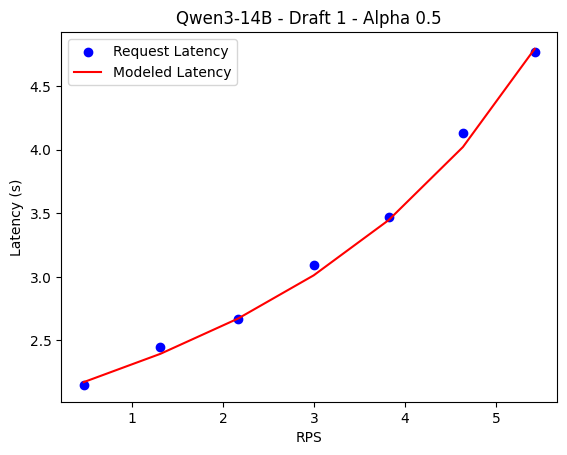

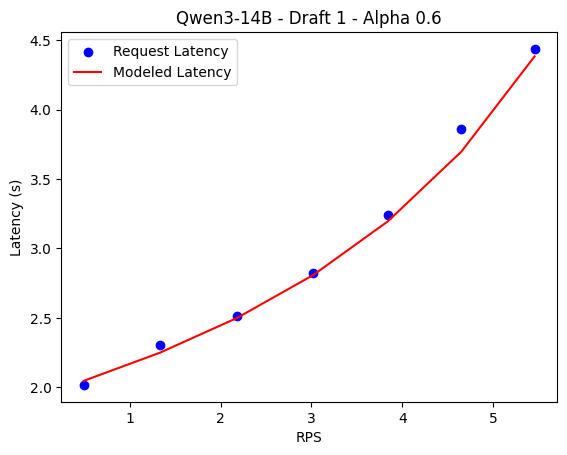

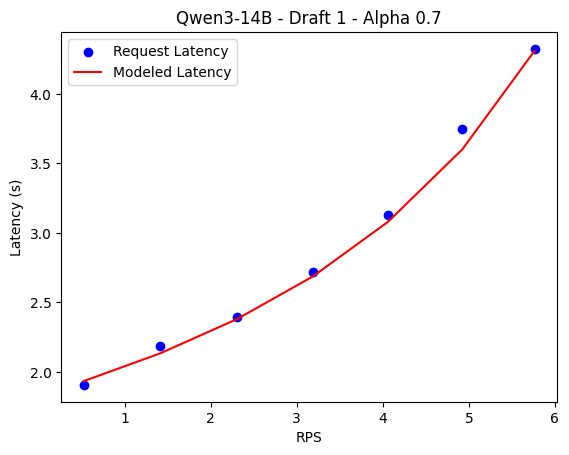

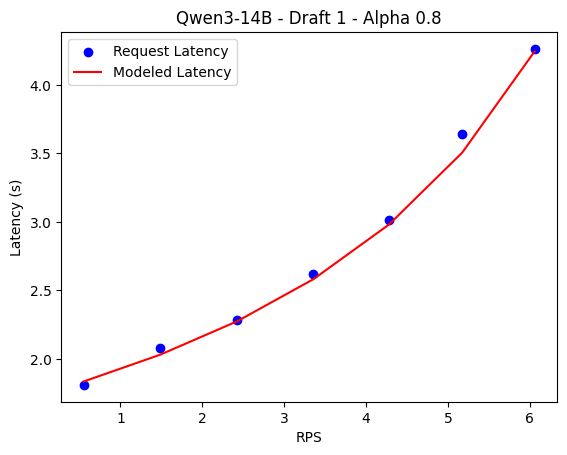

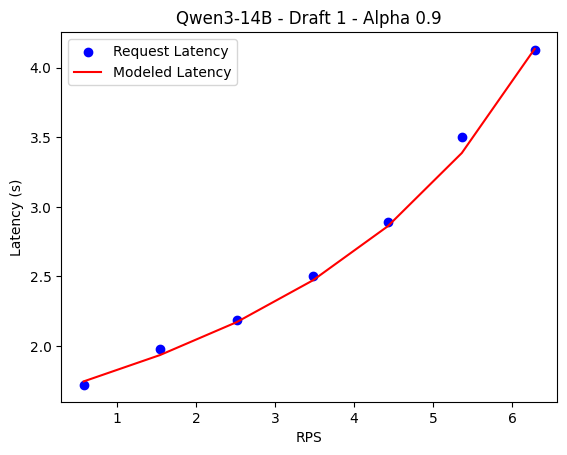

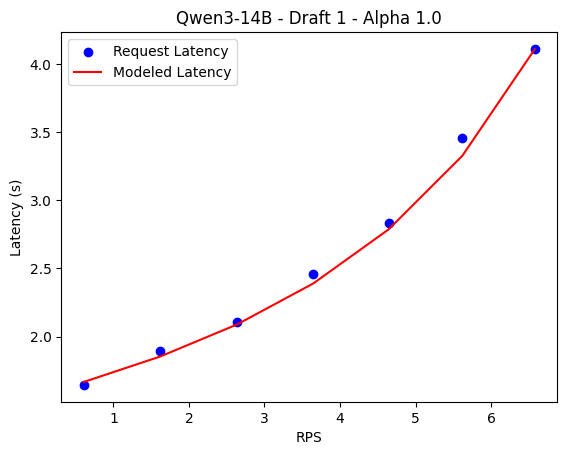

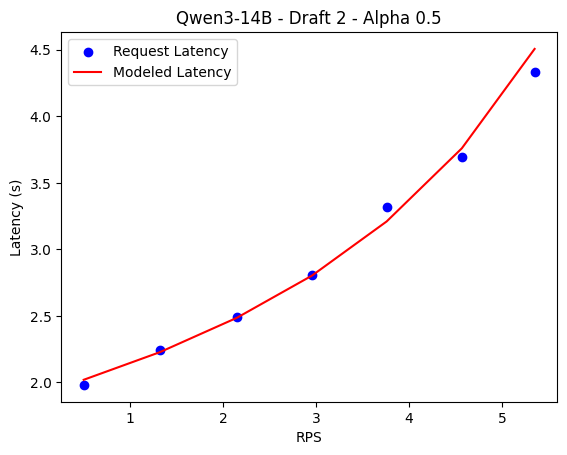

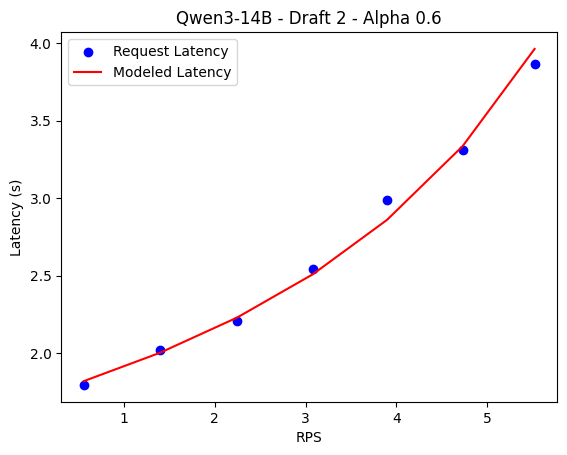

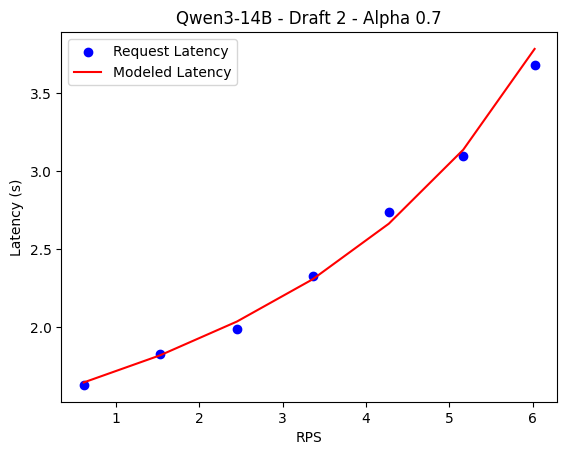

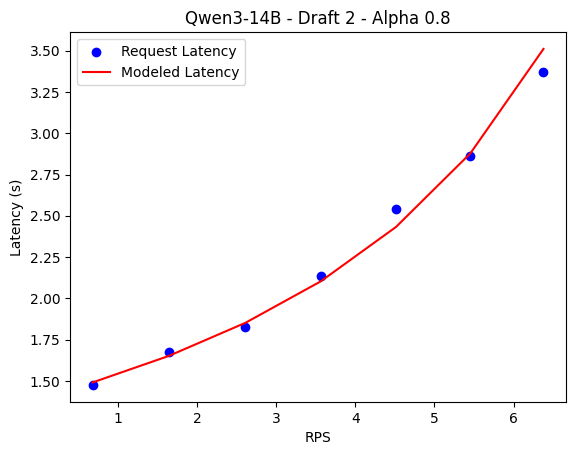

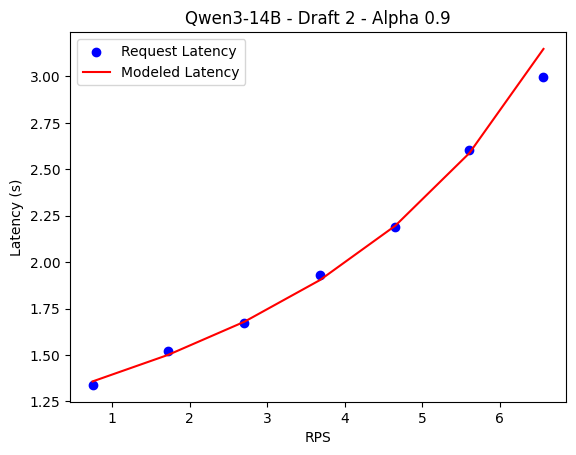

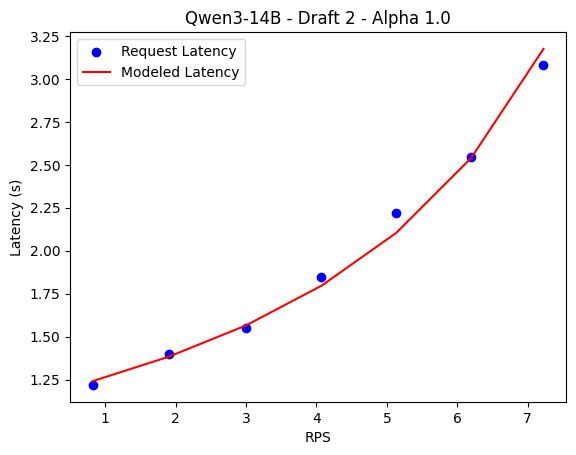

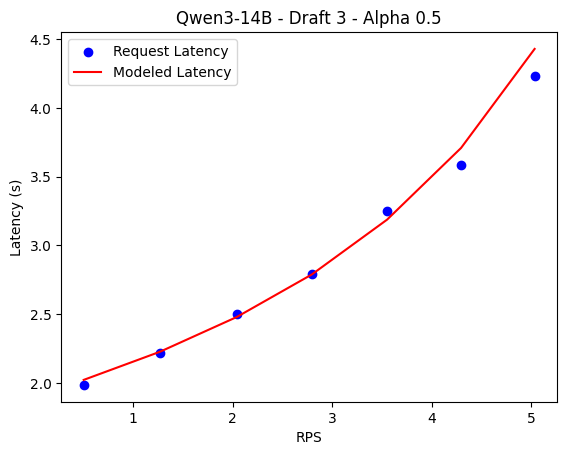

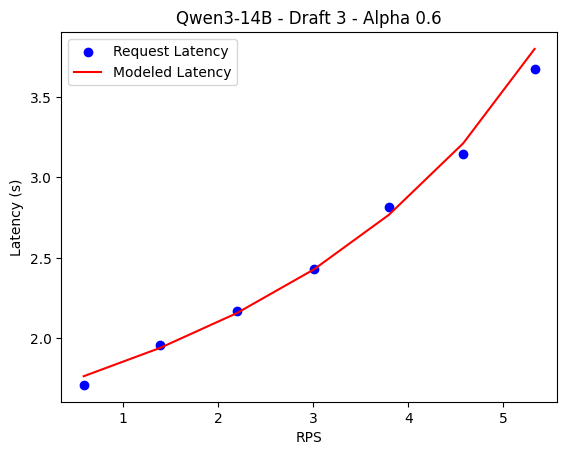

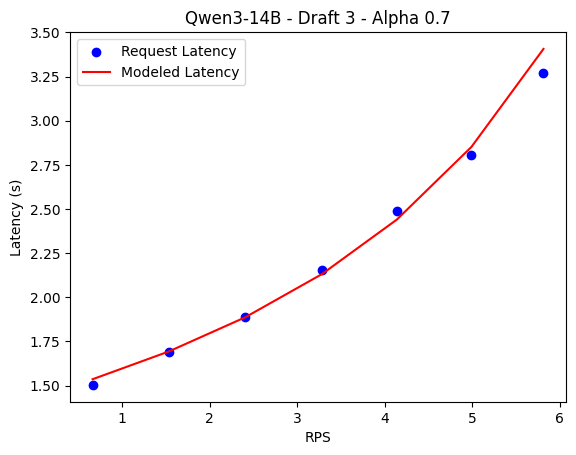

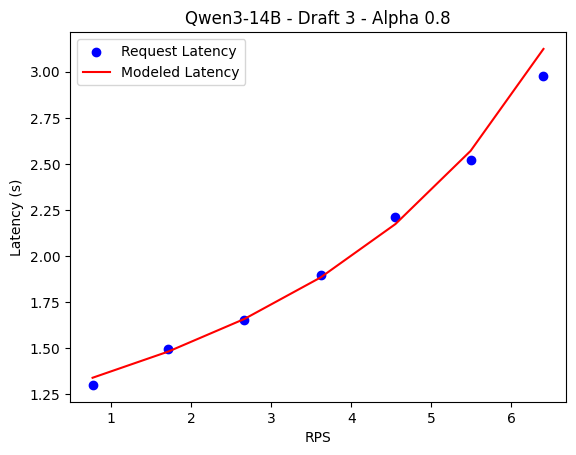

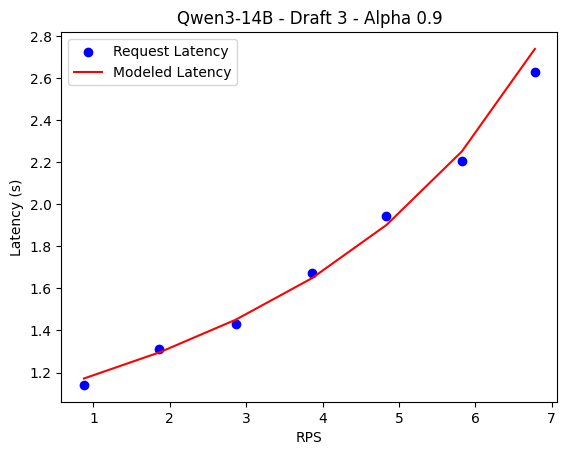

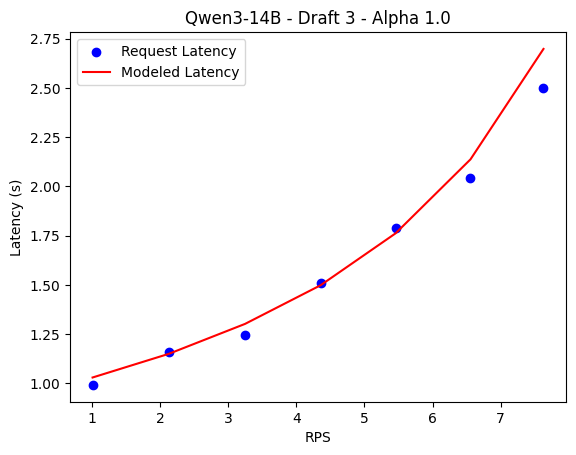

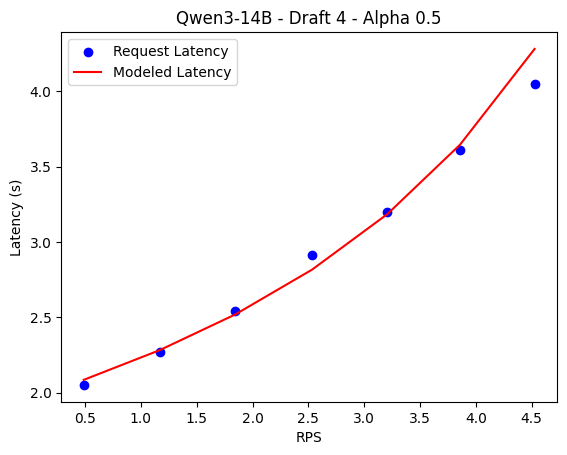

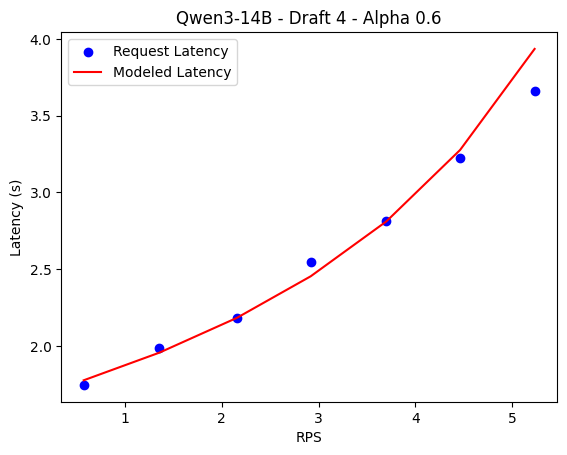

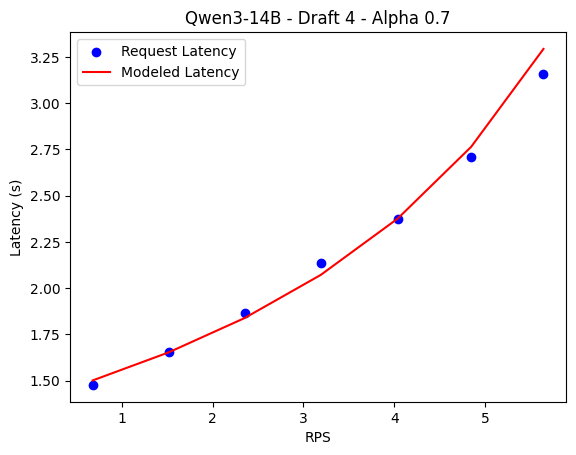

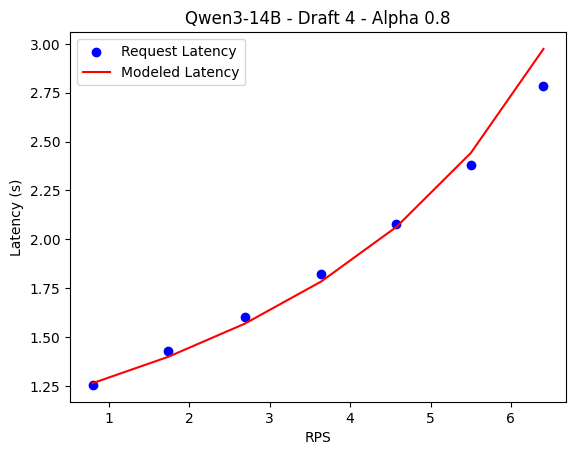

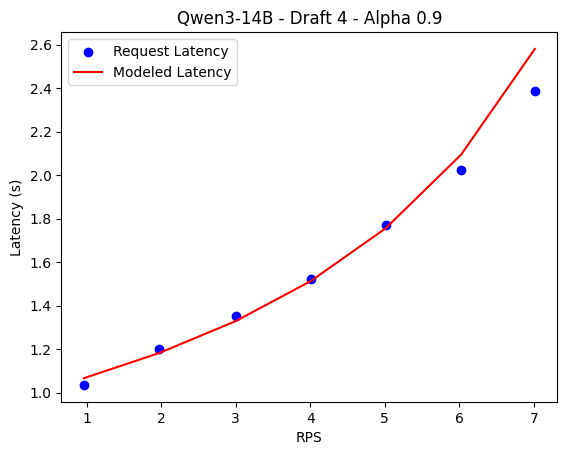

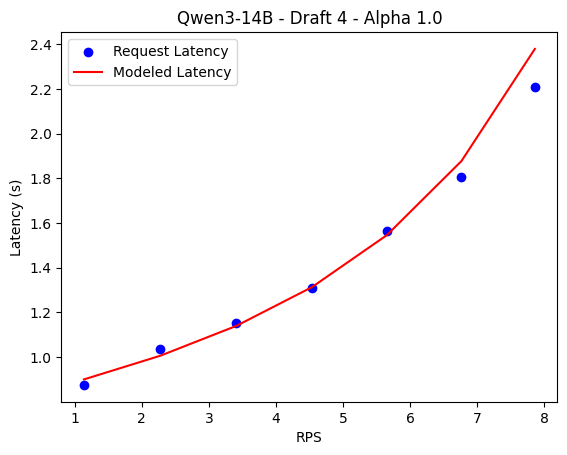

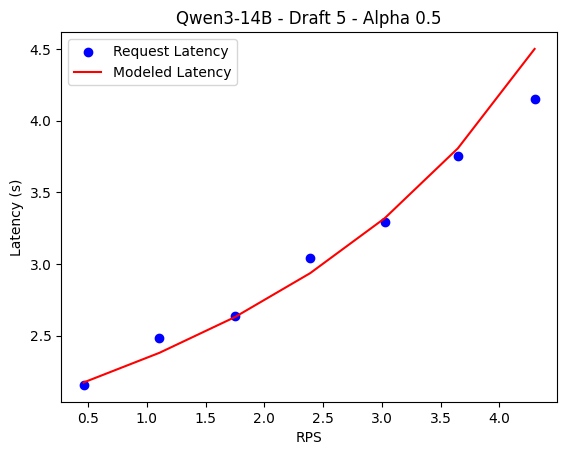

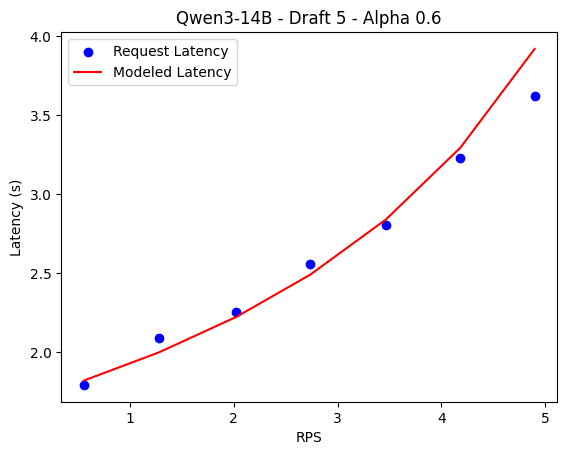

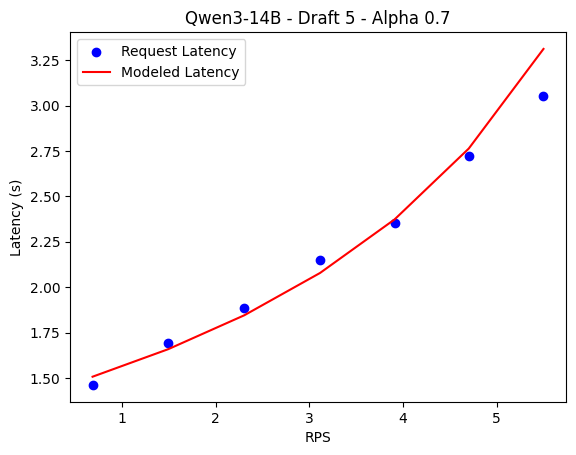

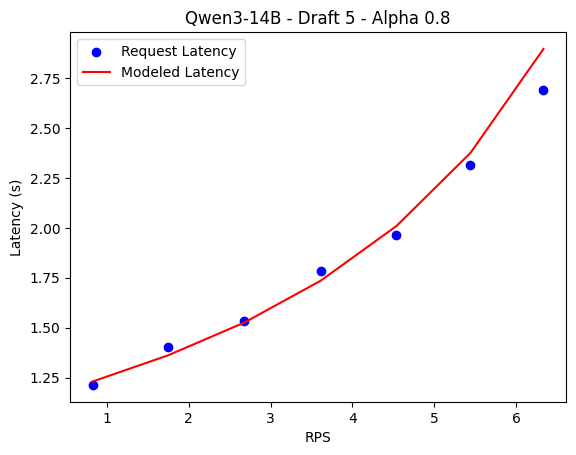

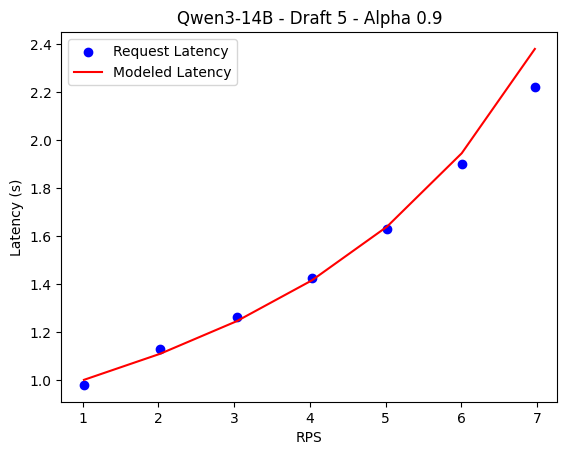

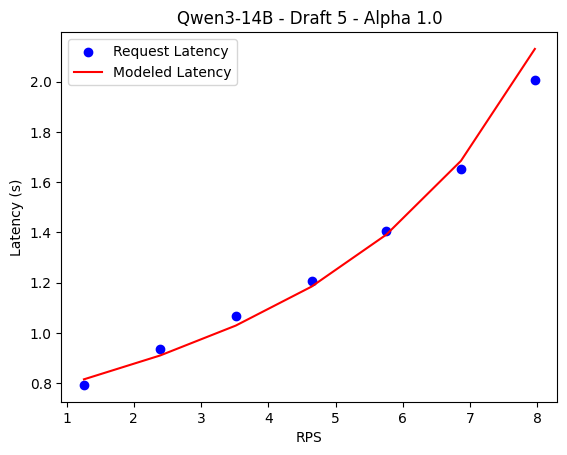

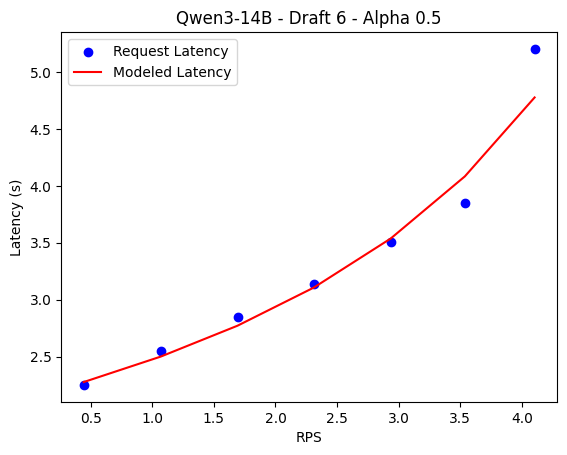

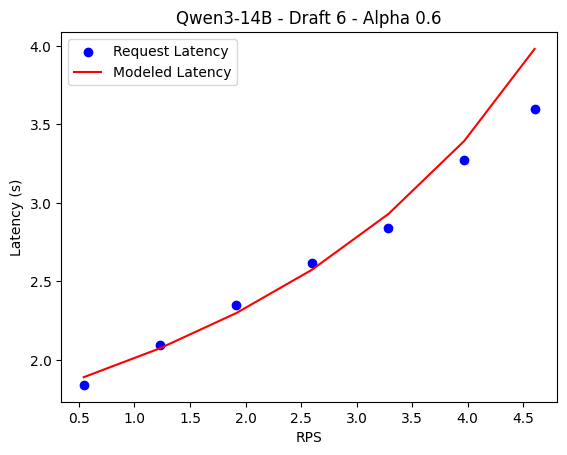

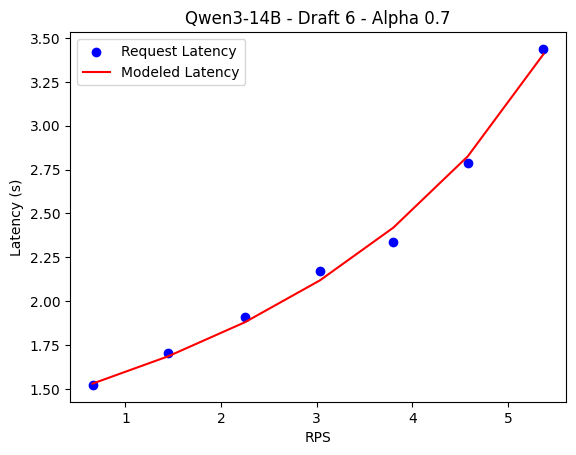

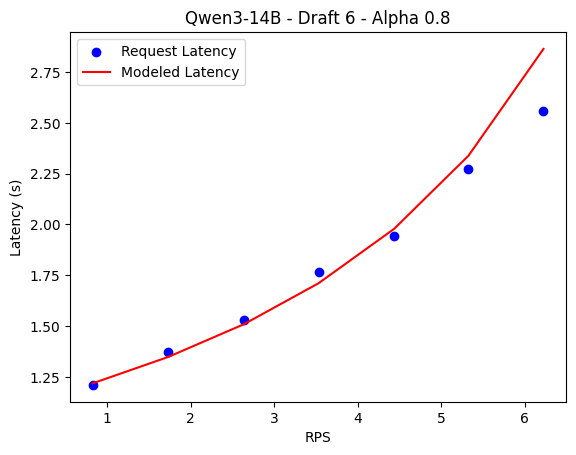

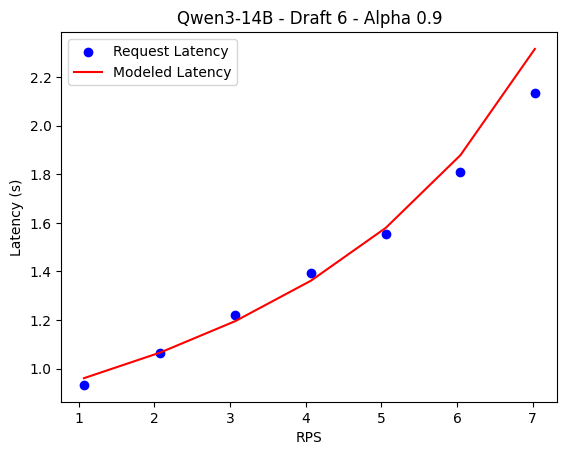

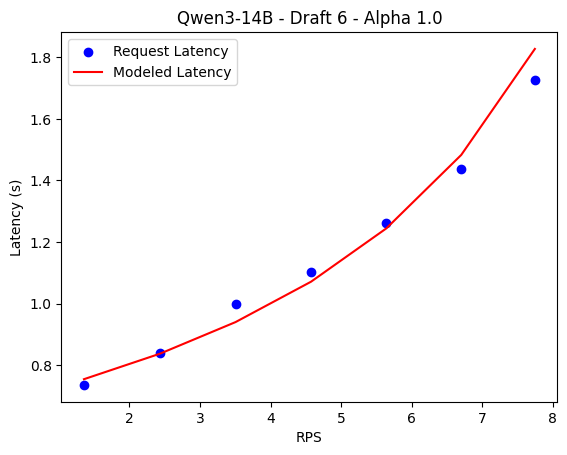

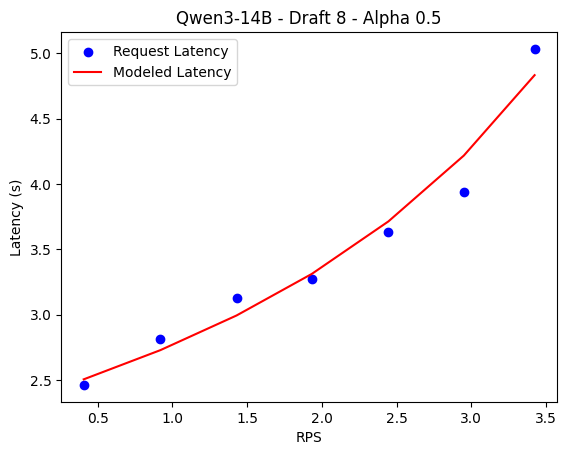

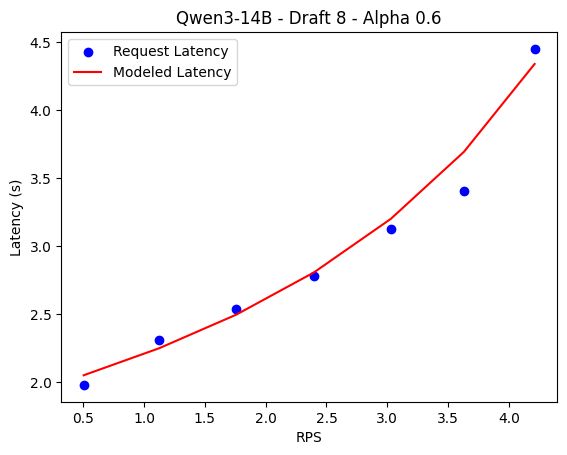

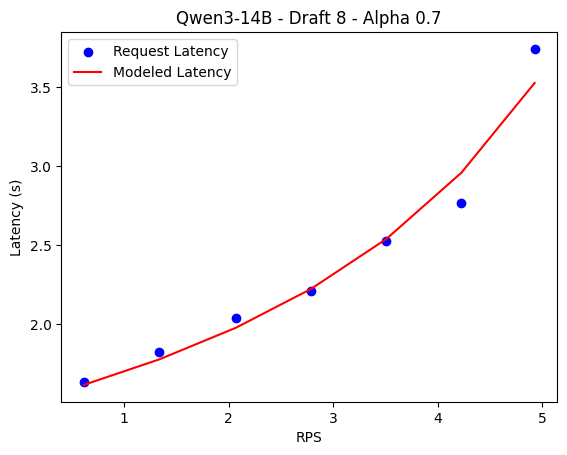

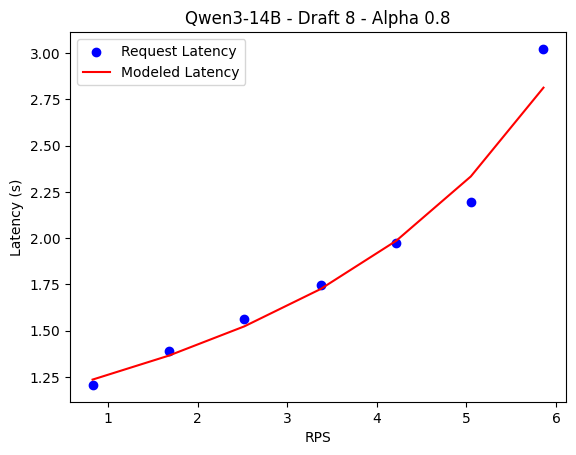

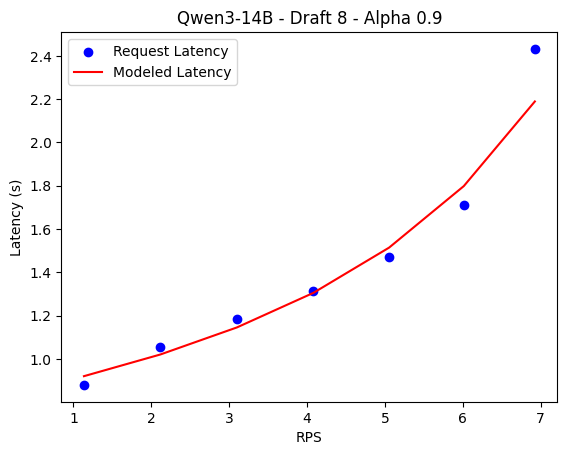

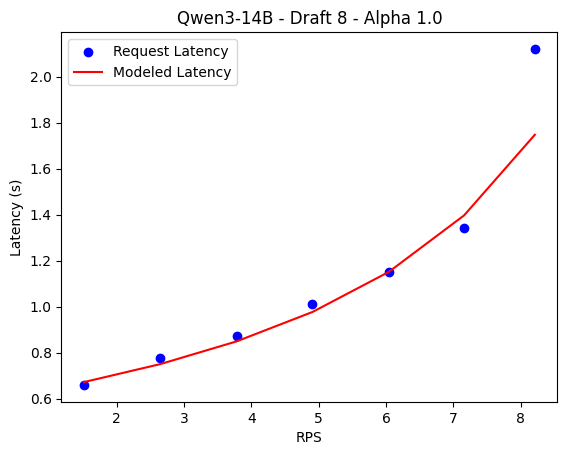

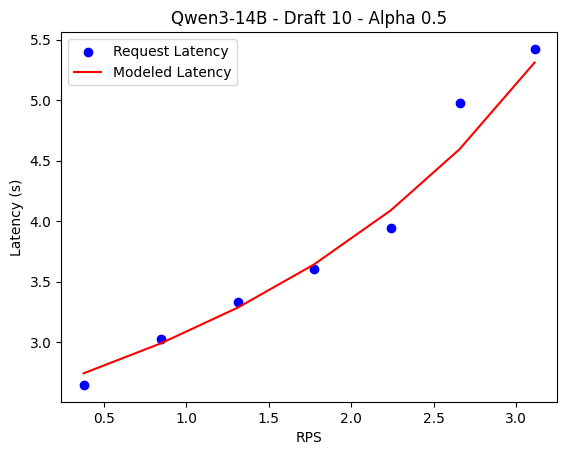

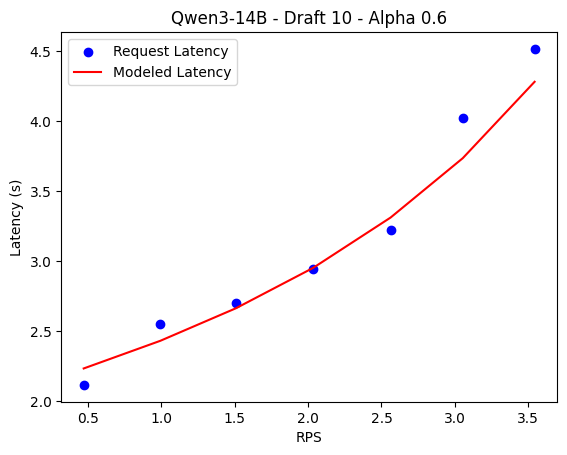

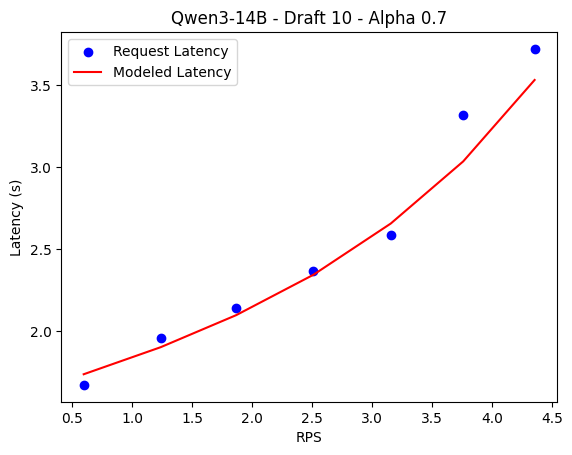

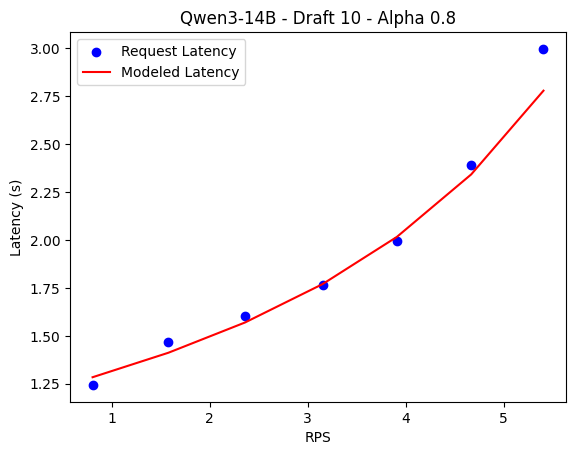

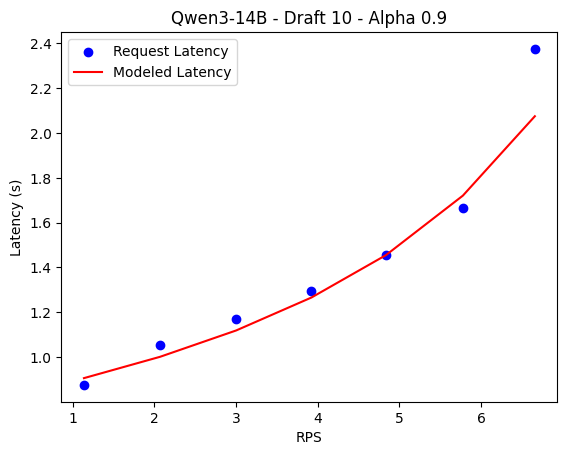

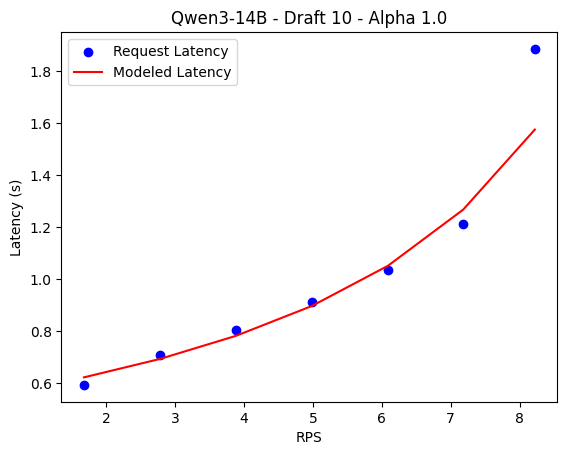

 83%|████████▎ | 5/6 [00:12<00:02,  2.58s/it]

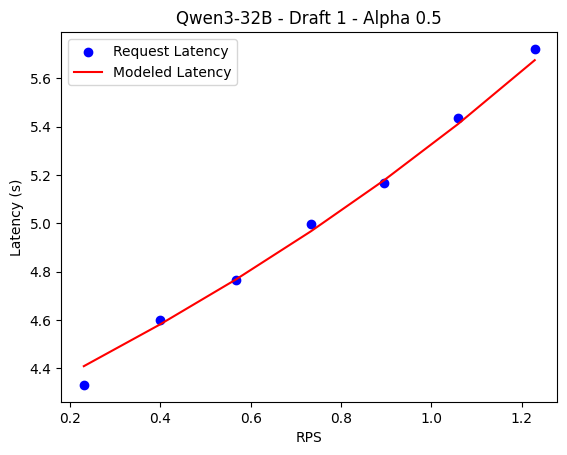

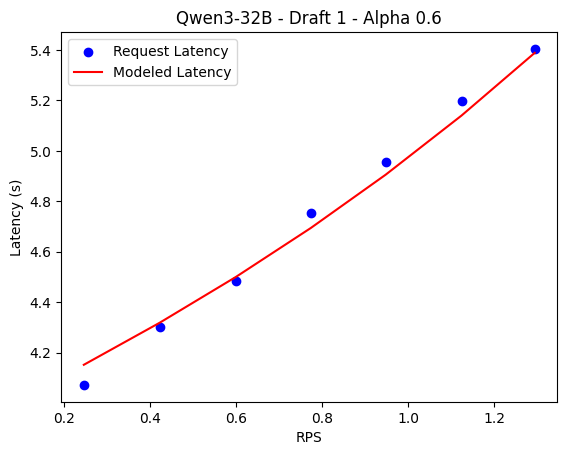

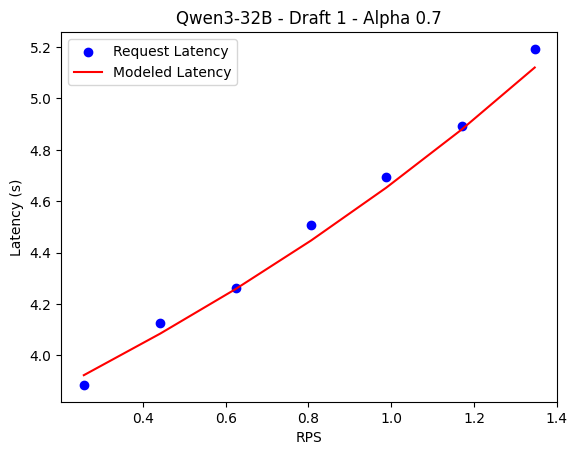

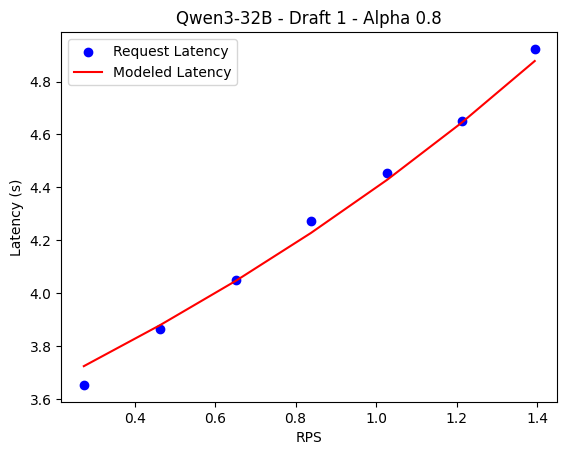

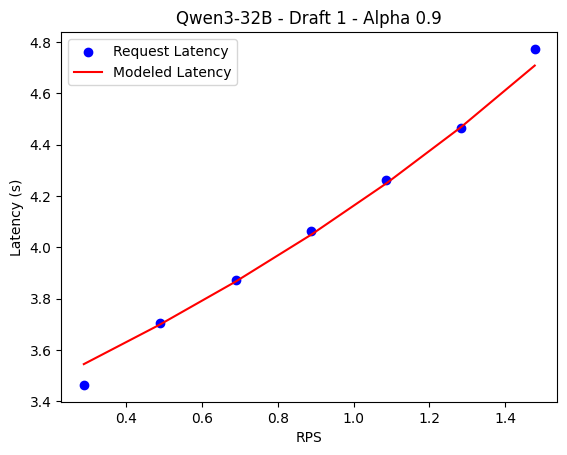

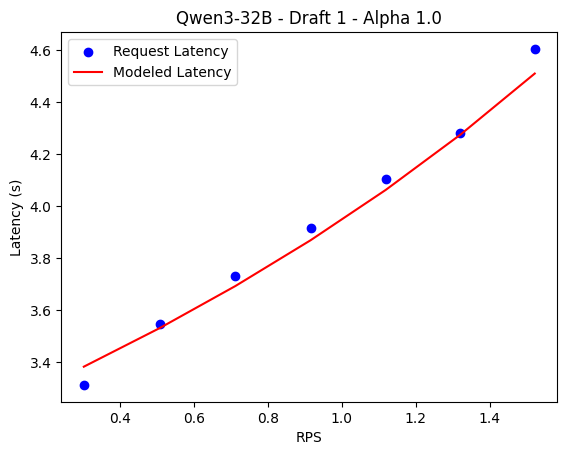

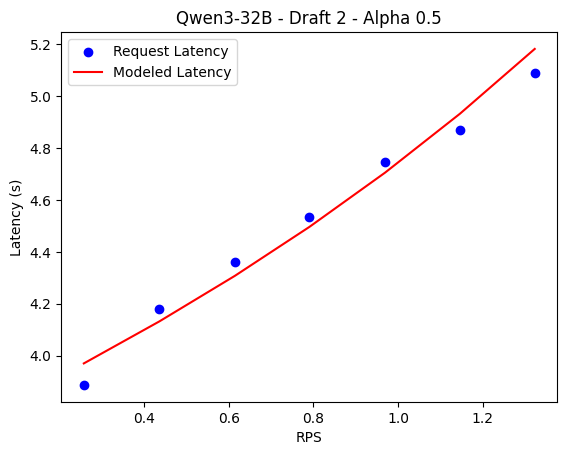

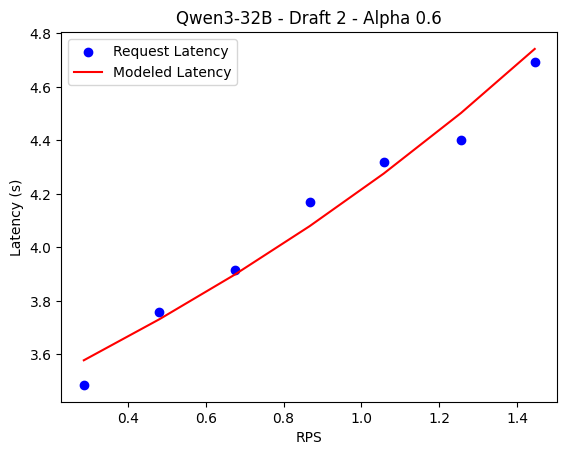

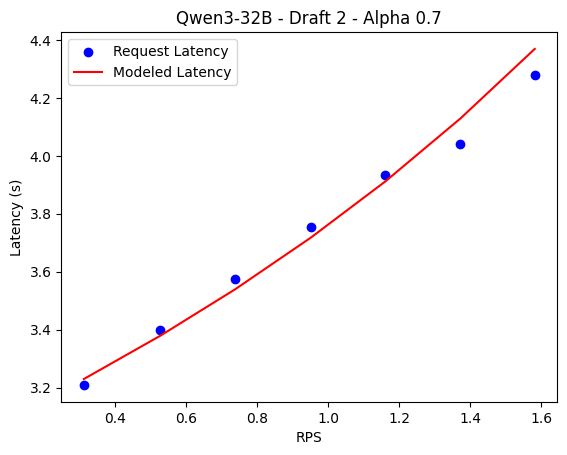

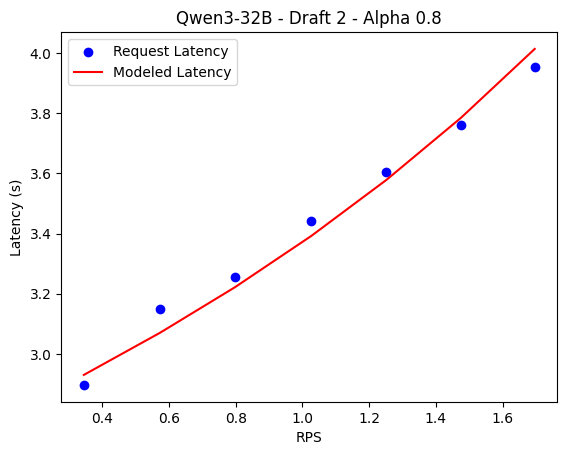

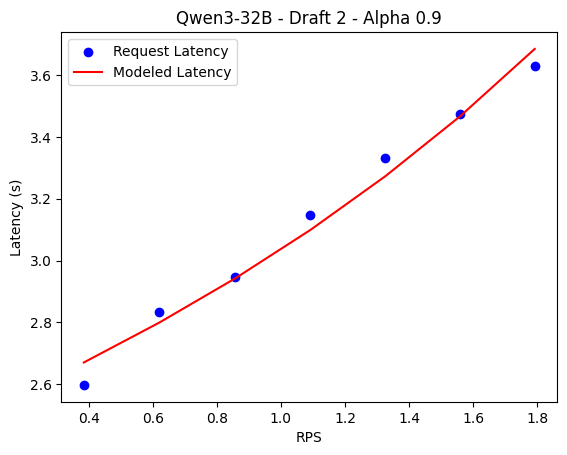

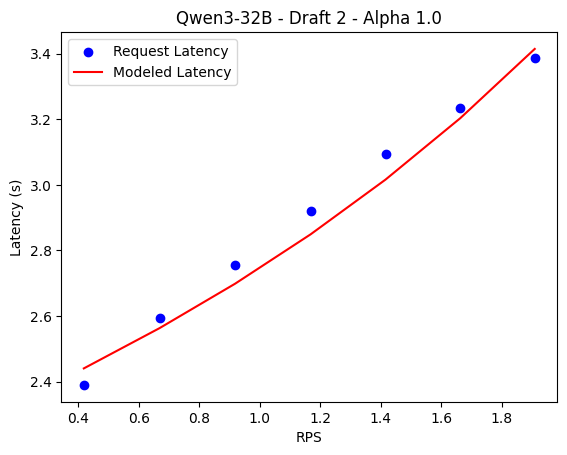

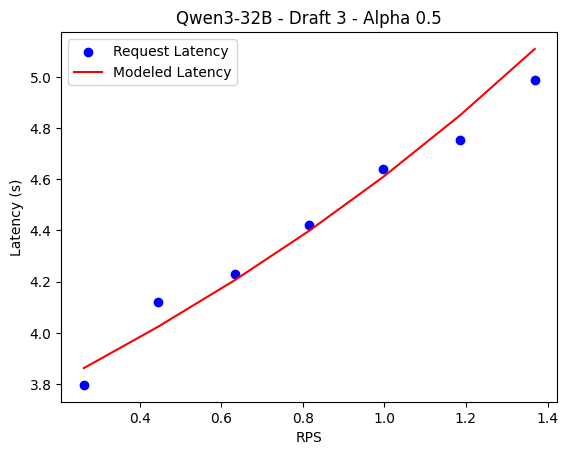

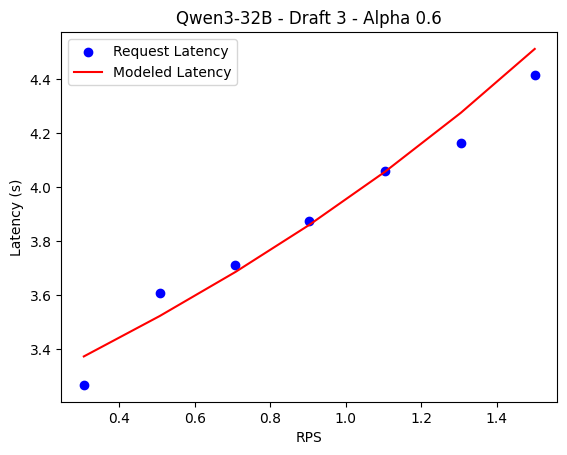

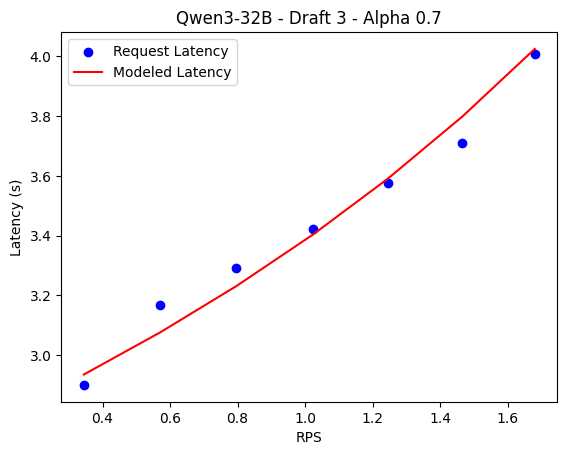

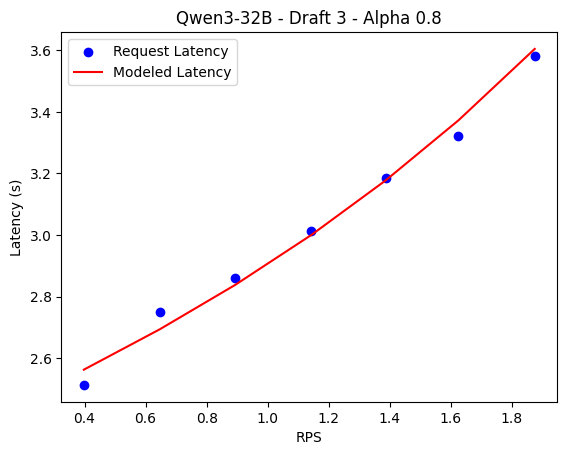

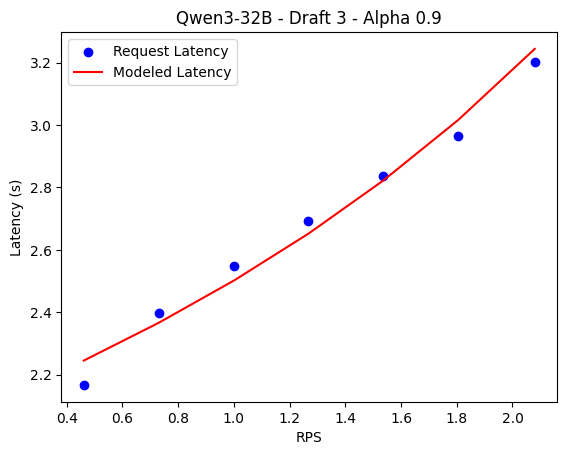

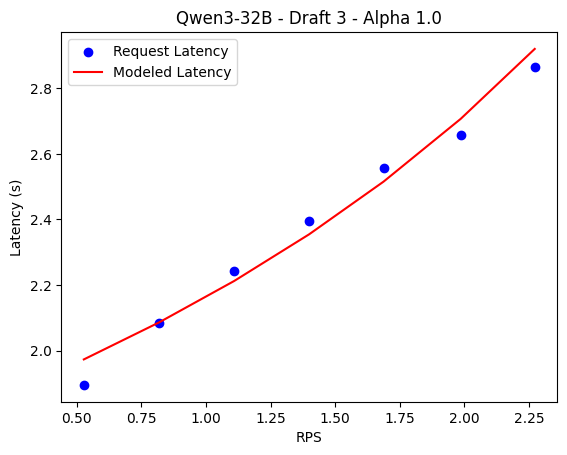

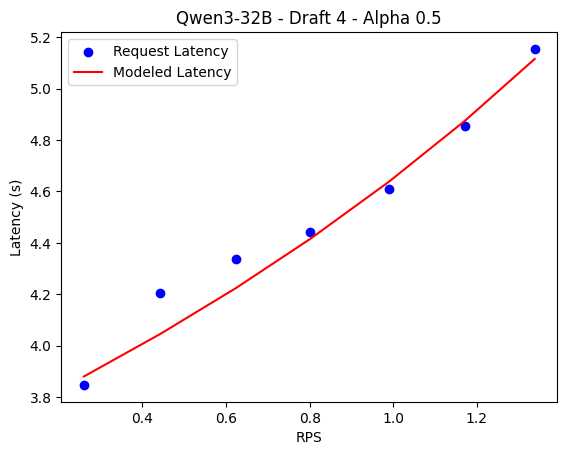

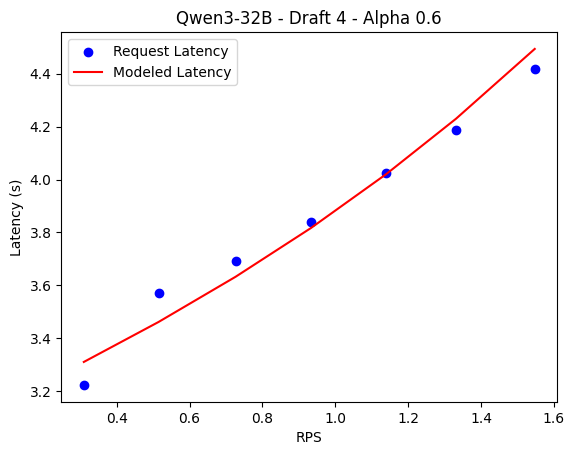

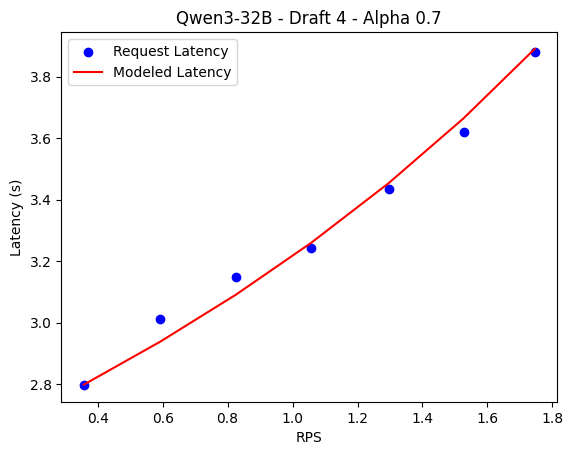

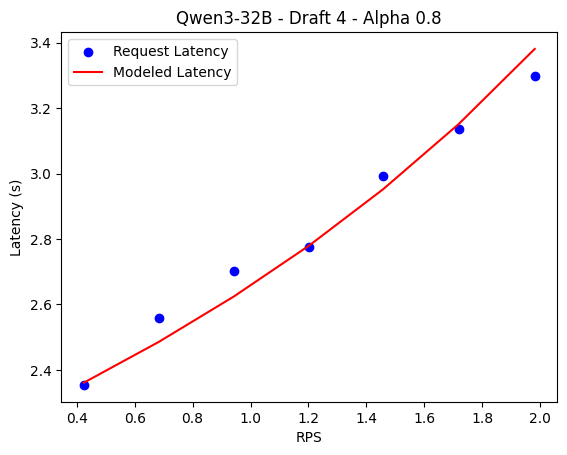

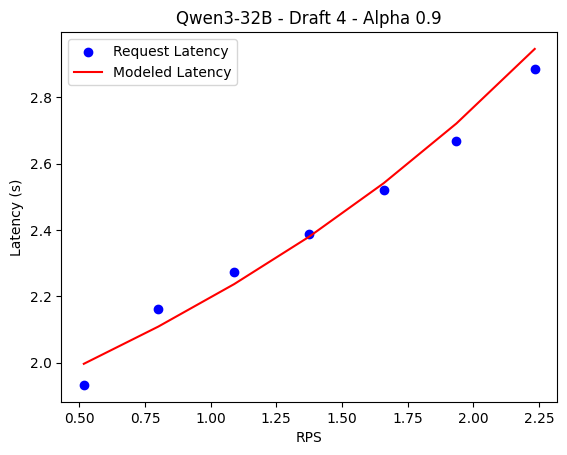

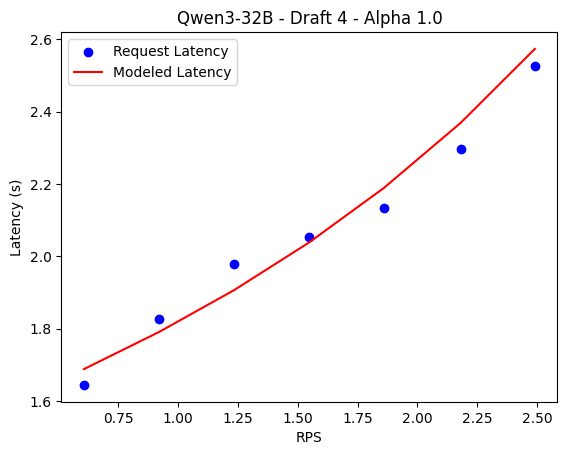

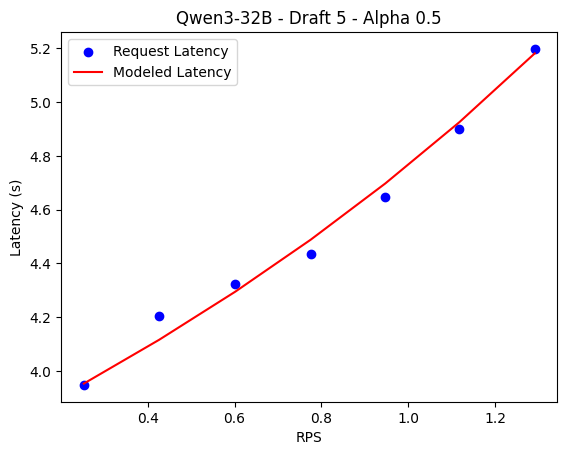

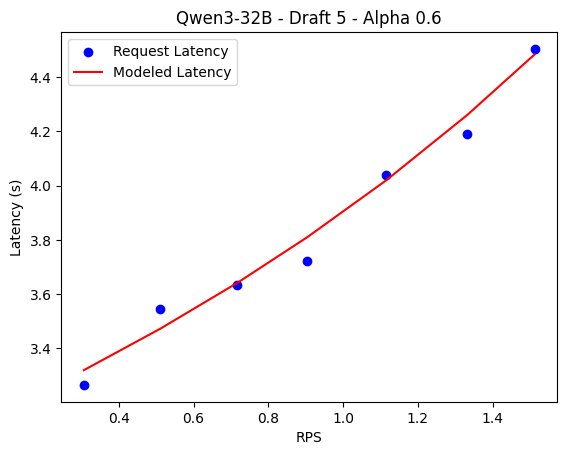

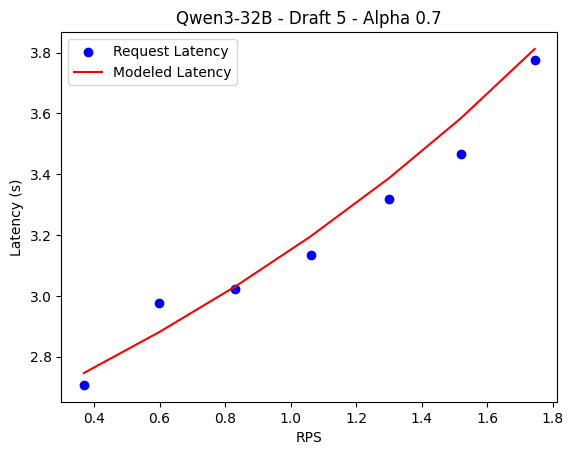

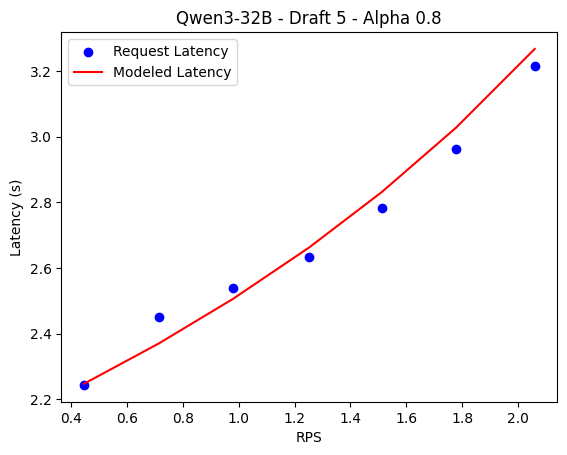

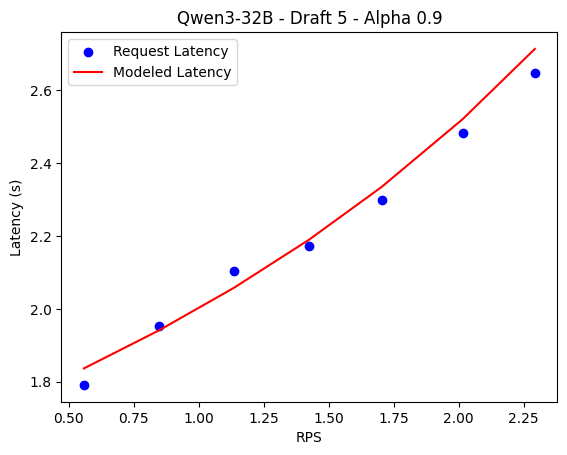

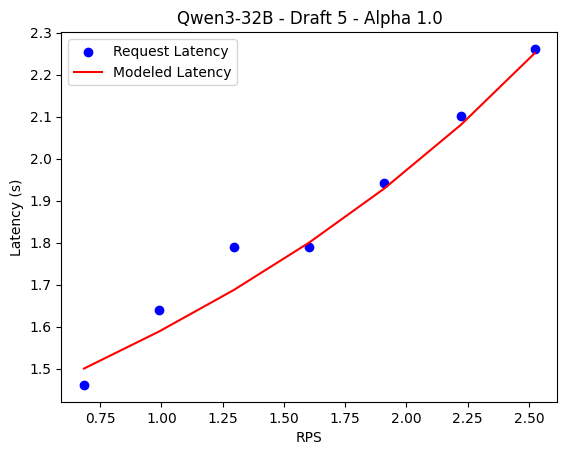

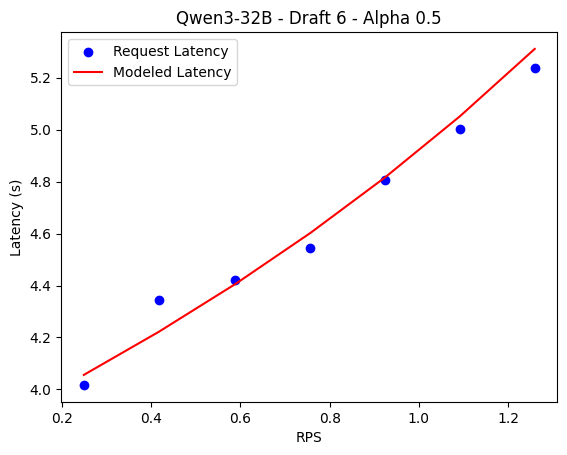

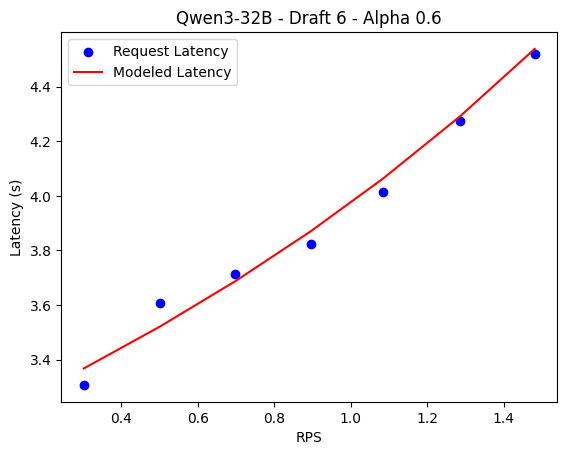

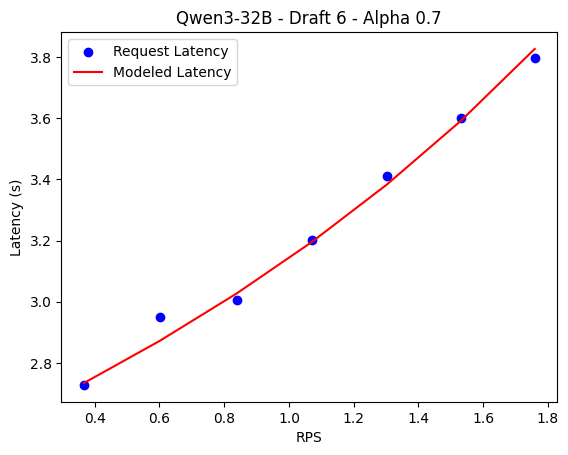

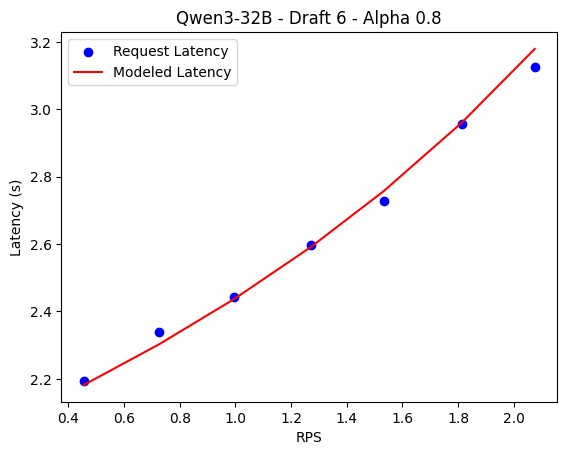

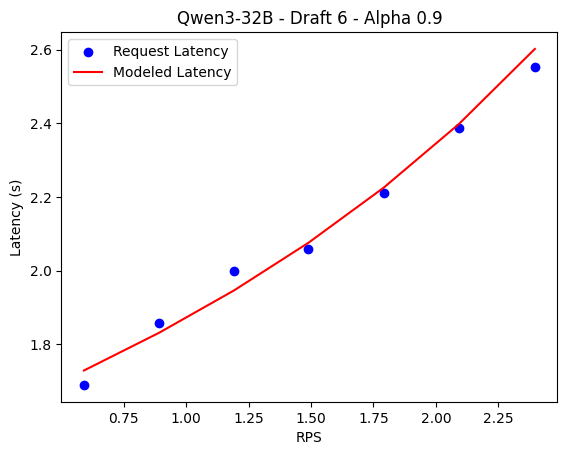

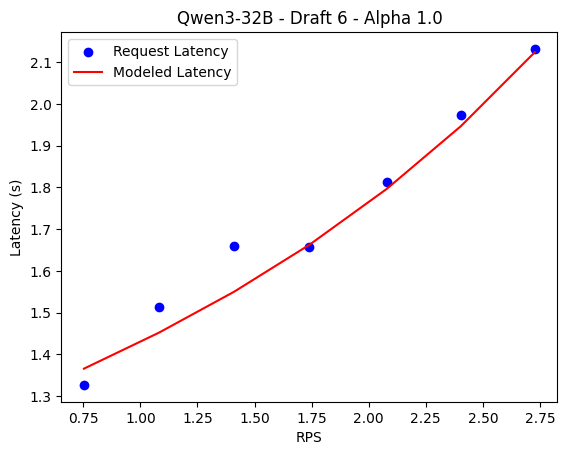

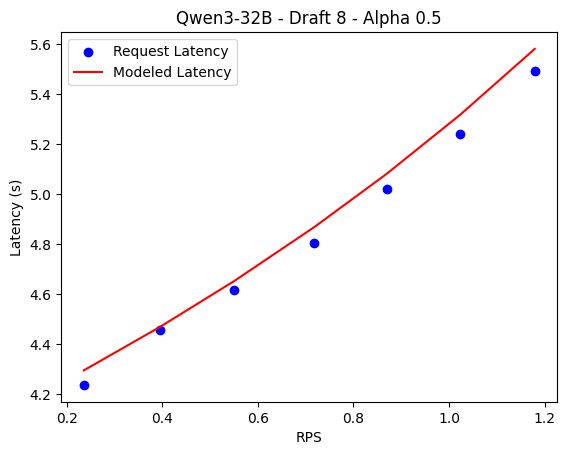

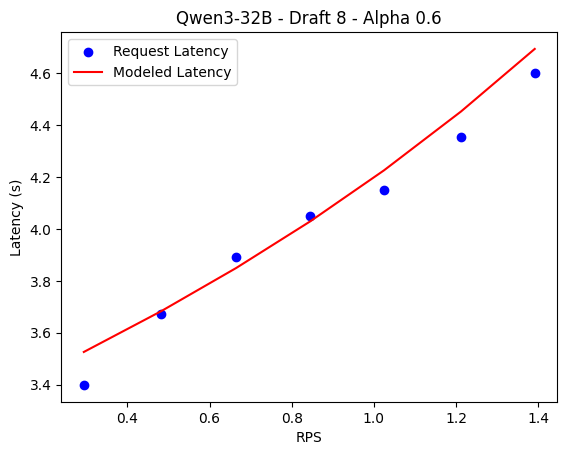

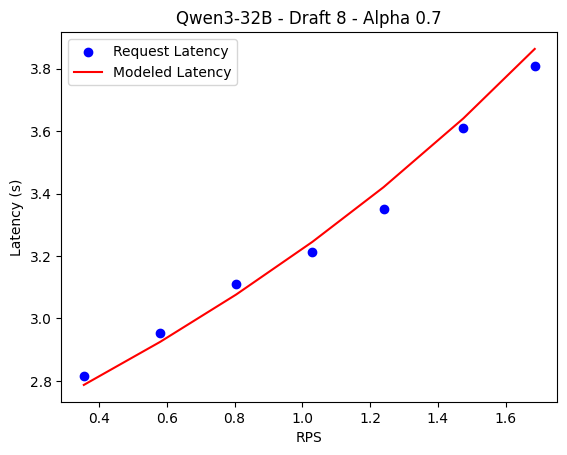

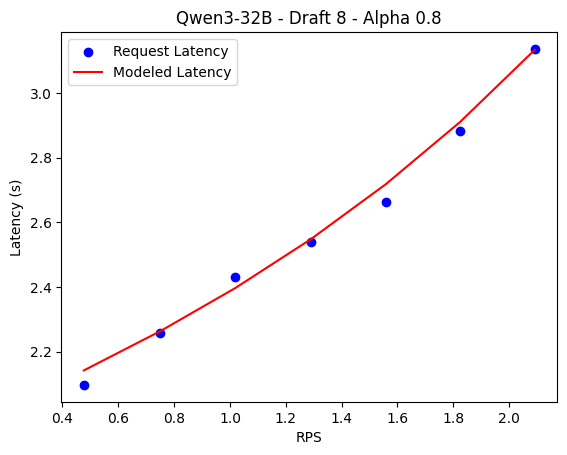

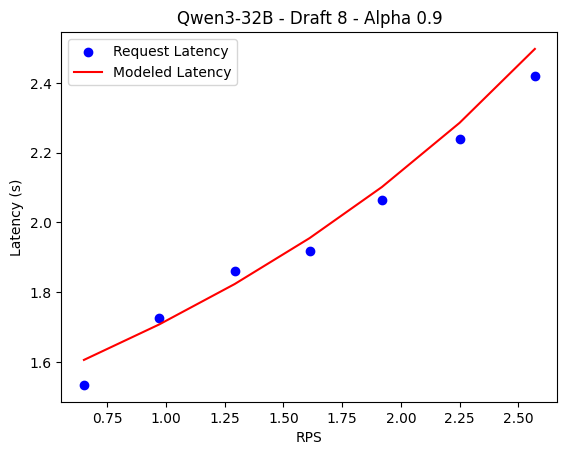

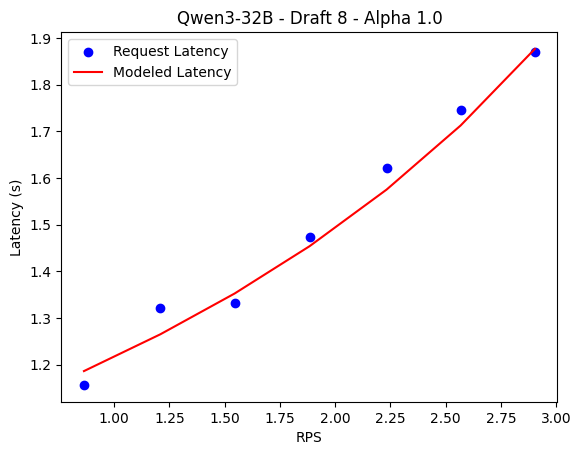

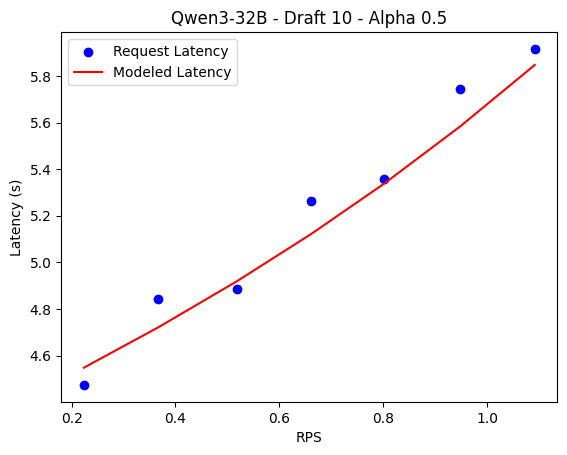

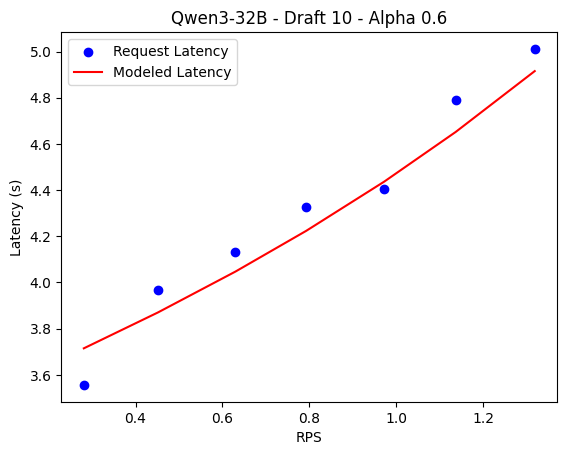

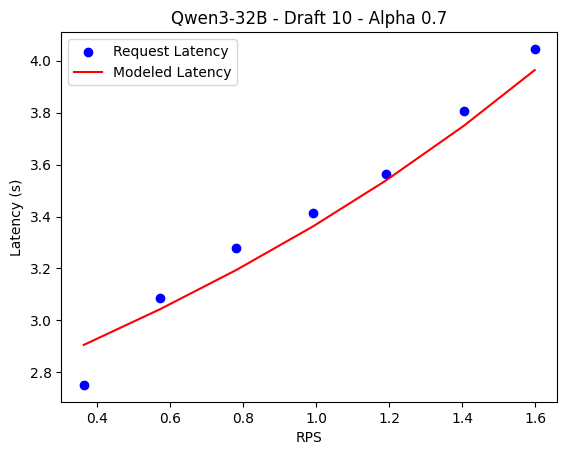

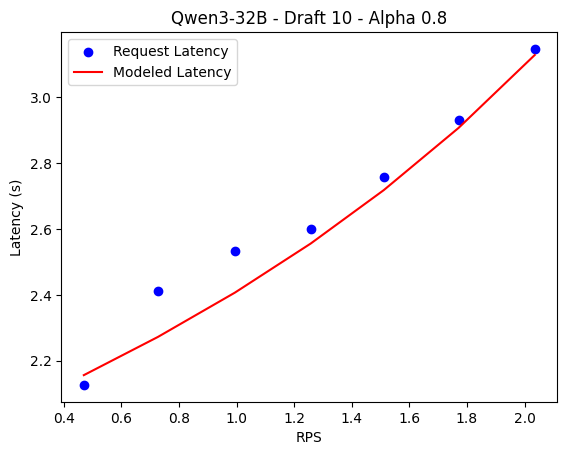

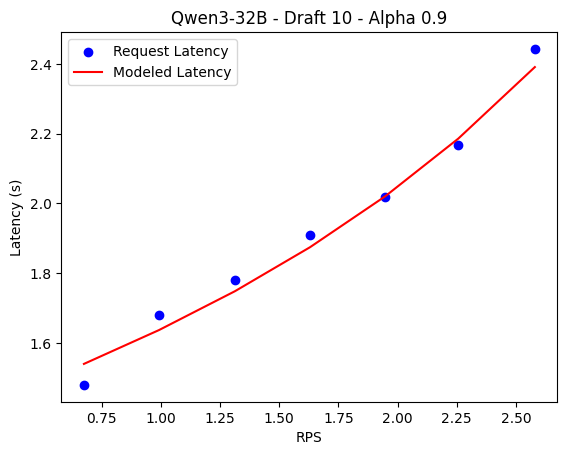

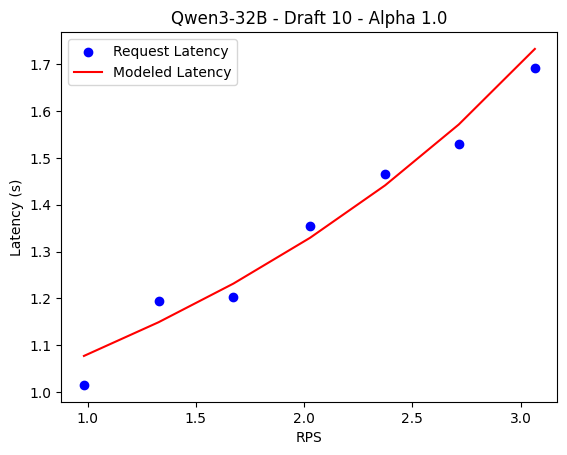

100%|██████████| 6/6 [00:15<00:00,  2.55s/it]


In [6]:
pmodels = {}
visualize_models = True

for model_size in tqdm(model_sizes):
    rpsc = None
    latc = None
    alphac = None
    kc = None
    for j, draft in enumerate(drafts):
        for i, alpha in enumerate(alphas):
            path = f"{DATA_DIR}/output_Qwen3-{model_size}_FS_alpha-{alpha:.2f}_draft-{draft}_prompt-512_output-128_concurrency-128_reduced.json"
            rps_, lat_ = getRequestLatency(path)
            k_ = np.ones_like(rps_) * draft
            alpha_ = np.ones_like(rps_) * alpha
            if rpsc is None:
                rpsc = rps_
                latc = lat_
                kc = k_
                alphac = alpha_
            else:
                rpsc = np.concatenate((rpsc, rps_))
                latc = np.concatenate((latc, lat_))
                kc = np.concatenate((kc, k_))
                alphac = np.concatenate((alphac, alpha_))
    
    model = PerSizeModel()
    model.fit_model(kc, alphac, rpsc, latc)
    pmodels[model_size] = model

    if visualize_models:
        for j, draft in enumerate(drafts):
            for i, alpha in enumerate(alphas):
                path = f"{DATA_DIR}/output_Qwen3-{model_size}_FS_alpha-{alpha:.2f}_draft-{draft}_prompt-512_output-128_concurrency-128_reduced.json"
                rps_, lat_ = getRequestLatency(path)
        
                plt.scatter(rps_, lat_, label='Request Latency', color='blue')
                plt.plot(rps_, model.latency(draft, alpha, rps_), label='Modeled Latency', color='red')
                plt.title(f"Qwen3-{model_size} - Draft {draft} - Alpha {alpha}")
                plt.xlabel(r"RPS")
                plt.ylabel(r"Latency (s)")
                plt.legend()
                plt.show()


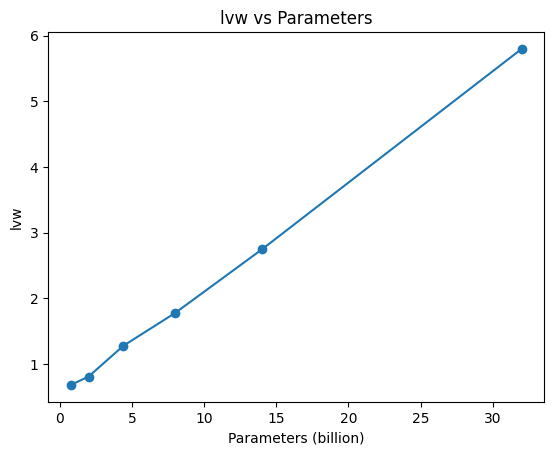

In [14]:
p = [parameters[size] for size in range(len(model_sizes))]
ellpw = [pmodels[model_size].ellvw for model_size in model_sizes]
plt.plot(p, ellpw, '-o')
plt.title("lvw vs Parameters")
plt.xlabel("Parameters (billion)")
plt.ylabel("lvw")
plt.show()


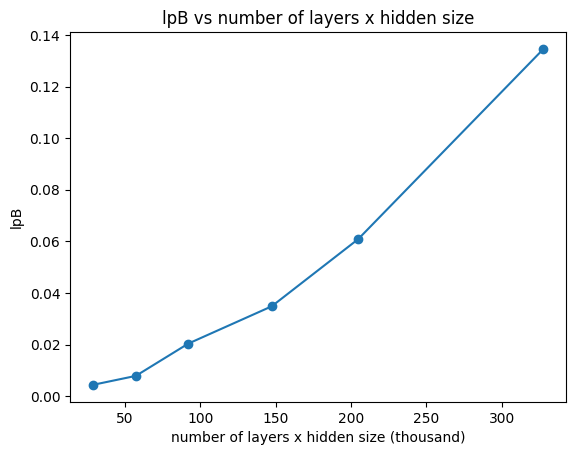

In [13]:
hidden_sizes = [h[size] for size in range(len(model_sizes))]
nl = [nlayers[size] for size in range(len(model_sizes))]
nh = [hidden_sizes[i] * nl[i] / 1e3 for i in range(len(model_sizes))]
ellpb = [pmodels[model_size].ellpB for model_size in model_sizes]
plt.plot(nh, ellpb, '-o')
plt.title("lpB vs number of layers x hidden size")
plt.xlabel("number of layers x hidden size (thousand)")
plt.ylabel("lpB")
plt.show()
